# Computational Identification of Regeneration-Organizing Cells in Xenopus Tail

This notebook implements the computational pipeline for identifying Regeneration-Organizing Cells (ROCs) in *Xenopus* tail tissue through single-cell RNA sequencing analysis. The analysis includes:

- **Highly Variable Gene (HVG) Selection**: Fano factor-based approach
- **UMAP Embedding**: Cosine distance metric with fuzzy simplicial set construction
- **Clustering**: Walktrap (graph-based) and Leiden (modularity optimization)
- **ROC Identification**: Enrichment analysis and marker gene selection
- **Quality Assessment**: Clustering metrics, denoising impact, and batch integration
- **Validation**: Comparison with published markers from Aztekin et al. (2019)

**Dataset**: 13,199 cells × 31,535 genes from intact and regenerating *Xenopus* tail tissue

In [1]:
# @title Install dependencies
!pip -q install scanpy anndata umap-learn python-igraph leidenalg harmonypy bbknn openpyxl scikit-learn matplotlib-venn

# TODO: See if I can make this a requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 40.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 121.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 110.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 5.3 MB/s eta 0:00:00


In [2]:
# @title Imports
# Standard library imports
import json
import math
import os
import re
import warnings

# Third-party imports
import anndata as ad
import bbknn
import harmonypy as hm
import igraph as ig
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
from google.colab import drive
from IPython.display import display
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MaxNLocator
from matplotlib_venn import venn2
from scipy.sparse import issparse
from scipy.stats import hypergeom
from sklearn.metrics import (adjusted_rand_score, rand_score,
                              silhouette_score, silhouette_samples)
from sklearn.neighbors import NearestNeighbors
from umap.umap_ import fuzzy_simplicial_set

warnings.filterwarnings("ignore")

In [3]:
# @title Mount Google Drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
# @title Paths and figure settings
sc.set_figure_params(dpi=120, figsize=(5, 4))
H5AD_PATH = "/content/drive/MyDrive/STAT4243/cleaned_processed_frogtail.h5ad"
TABLE_S3_XLSX = "/content/drive/MyDrive/STAT4243/aav9996_tables3.xlsx"
OUTPUT_DIR = "/content/drive/MyDrive/STAT4243/roc_outputs_final"

# Create organized output subdirectories
DIR_CLUSTERING = os.path.join(OUTPUT_DIR, "01_clustering")
DIR_ROC = os.path.join(OUTPUT_DIR, "02_roc_identification")
DIR_MARKERS = os.path.join(OUTPUT_DIR, "03_markers")
DIR_VALIDATION = os.path.join(OUTPUT_DIR, "04_validation")
DIR_DENOISING = os.path.join(OUTPUT_DIR, "05_denoising")
DIR_BATCH = os.path.join(OUTPUT_DIR, "06_batch_integration")
DIR_FIGURES = os.path.join(OUTPUT_DIR, "07_figures_publication")
DIR_SUMMARY = os.path.join(OUTPUT_DIR, "08_summary")

for d in [OUTPUT_DIR, DIR_CLUSTERING, DIR_ROC, DIR_MARKERS, DIR_VALIDATION,
          DIR_DENOISING, DIR_BATCH, DIR_FIGURES, DIR_SUMMARY]:
    os.makedirs(d, exist_ok=True)

print("H5AD:", H5AD_PATH, "| Table S3:", TABLE_S3_XLSX)
print("Output directories created in:", OUTPUT_DIR)

H5AD: /content/drive/MyDrive/STAT4243/cleaned_processed_frogtail.h5ad | Table S3: /content/drive/MyDrive/STAT4243/aav9996_tables3.xlsx
Output directories created in: /content/drive/MyDrive/STAT4243/roc_outputs_final


In [5]:
# @title Load .h5ad (clean baseline; do not mutate source)
ad0 = sc.read_h5ad(H5AD_PATH)
ad0.var_names_make_unique()
print("Loaded:", ad0.shape, "| layers:", list(ad0.layers.keys()))
print("obs columns:", list(ad0.obs.columns))

Loaded: (13199, 31535) | layers: []
obs columns: ['barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch']


## Highly Variable Genes (HVG) Selection via Fano Factor

Following the Fano factor approach from Aztekin et al. (2019), we:

1. **Normalize** to counts per 10K (CP10K) for variance statistics
2. **Calculate Fano factor** $F_i = \sigma^2_i / \mu_i$ for each gene
3. **Filter genes** with mean expression in 5th–80th percentiles
4. **Select HVGs** with Fano factor > 65th percentile of filtered genes

The working matrix is set to **log2(1 + CP10K)** for HVGs (used for embedding/clustering), while **all genes** are stored in `.raw` for differential expression analysis.

**Result**: 2,308 highly variable genes from 31,535 total genes

In [6]:
# @title HVGs by Fano + `.raw`

# Extract counts matrix
counts = ad0.layers["counts"] if "counts" in ad0.layers else ad0.X
X = counts.toarray() if issparse(counts) else counts
X = X.astype(np.float32, copy=False)

# Normalize to CP10K
lib = X.sum(axis=1, keepdims=True) + 1e-12
Xnorm = (X / lib) * 1e4
log2_all = np.log2(1.0 + Xnorm).astype(np.float32, copy=False)

# Calculate gene statistics
gmean = Xnorm.mean(axis=0)
gvar = Xnorm.var(axis=0, ddof=1)
fano = np.divide(gvar, gmean, out=np.zeros_like(gvar), where=gmean > 0)

# Apply Fano factor filtering
p5, p80 = np.percentile(gmean, [5, 80])
mask_mean = (gmean >= p5) & (gmean <= p80)
thr = np.percentile(fano[mask_mean], 65)
hvg_mask = mask_mean & (fano > thr)

print(f"Cells: {ad0.n_obs} | Genes: {ad0.n_vars} | HVGs: {int(hvg_mask.sum())}")

# Create working AnnData with HVGs only
adata = ad.AnnData(
    log2_all[:, hvg_mask],
    obs=ad0.obs.copy(),
    var=ad0.var.iloc[hvg_mask].copy()
)
adata.layers["log2"] = adata.X.copy()

# Store all genes in .raw for DE analysis
adata.raw = ad.AnnData(log2_all, obs=ad0.obs.copy(), var=ad0.var.copy())

# Standard preprocessing: scale, PCA, neighbors, UMAP
sc.pp.scale(adata, zero_center=True, max_value=10)
sc.tl.pca(adata, n_comps=50, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=40, metric="cosine")
sc.tl.umap(adata, min_dist=0.5)

print("Working shapes:", adata.shape, "| raw:", adata.raw.shape)

Cells: 13199 | Genes: 31535 | HVGs: 8830
Working shapes: (13199, 8830) | raw: (13199, 31535)


In [7]:
# @title Map baseline clusters to broader categories
my_map = {
    # Skin
    "Alpha ionocyte": "Skin",
    "Beta ionocyte": "Skin",
    "Epidermis": "Skin",
    "Goblet cell": "Skin",
    "laminin-rich epidermis": "Skin",
    "Melanocyte": "Skin",
    "Melanocyte precursor": "Skin",
    "Melanocyte stem cell": "Skin",
    "ROCs": "Skin",
    "Small secretory cell": "Skin",

    # Neural
    "Differentiating neuron": "Neural",
    "Dopaminergic neurons": "Neural",
    "Floor plate": "Neural",
    "Interneuron 1": "Neural",
    "Interneuron 2": "Neural",
    "Interneuron 3": "Neural",
    "Interneuron 4": "Neural",
    "Motor neuron": "Neural",
    "Motor neuron (leptin+)": "Neural",
    "Oligodendrocyte": "Neural",
    "Spinal cord progenitor": "Neural",
    "Vulnerable Motor Neuron": "Neural",

    # Somite
    "Anterior notochord": "Somites",
    "Dermomyotome": "Somites",
    "Differentiating myocyte": "Somites",
    "Mesenchyme": "Somites",
    "Myotome": "Somites",
    "Posterior notochord": "Somites",
    "Satellite cell": "Somites",
    "Sclerotome": "Somites",
    "Skeletal muscle": "Somites",
    "Smooth muscle": "Somites",
    "Syndetome": "Somites",
    "Vascular endothelial cell": "Somites",

    # Immune system
    "Lymphoid 1 (Gata2-, Gata3+)": "Immune system",
    "Lymphoid 2 (Cxcr6+)": "Immune system",
    "Lymphoid 3": "Immune system",
    "Lymphoid 4 (Gata2+, Gata3-)": "Immune system",
    "Lymphoid 5 (CD19+)": "Immune system",
    "Lymphoid endothelial cells": "Immune system",
    "Myeloid 1": "Immune system",
    "Myeloid 2": "Immune system",

    # Red blood cells
    "Erythrocyte 1": "Red blood cells",
    "Erythrocyte 2": "Red blood cells",
    "Erythrocyte 3": "Red blood cells",
    "Erythrocyte 4": "Red blood cells",
}

adata.obs['category'] = adata.obs['cluster'].map(my_map)
adata.obs['category'].value_counts()

category
Red blood cells    4737
Skin               4212
Somites            1716
Neural             1539
Immune system       995
Name: count, dtype: int64

In [8]:
cluster_color_map = {
    "Goblet cell": "salmon",
    "ROCs": "red",
    "Epidermis": "moccasin",
    "laminin-rich epidermis": "gold",
    "Small secretory cell": "darksalmon",
    "Alpha ionocyte": "indianred3",
    "Beta ionocyte": "indianred4",
    "Melanocyte": "goldenrod",
    "Melanocyte precursor": "tan1",
    "Melanocyte stem cell": "sandybrown",
    "Lymphoid 1 (Gata2-, Gata3+)": "hotpink",
    "Lymphoid 2 (Cxcr6+)": "pink",
    "Lymphoid 3": "plum1",
    "Lymphoid 4 (Gata2+, Gata3-)": "orchid1",
    "Lymphoid 5 (CD19+)": "darkorchid1",
    "Myeloid 2": "magenta",
    "Myeloid 1": "violet",
    "Erythrocyte 1": "grey30",
    "Erythrocyte 2": "grey50",
    "Erythrocyte 3": "grey70",
    "Erythrocyte 4": "grey90",
    "Skeletal muscle": "greenyellow",
    "Sclerotome": "darkolivegreen",
    "Dermomyotome": "springgreen",
    "Myotome": "seagreen",
    "Mesenchyme": "palegreen",
    "Syndetome": "aquamarine",
    "Satellite cell": "chartreuse",
    "Smooth muscle": "darkgreen",
    "Differentiating myocyte": "yellowgreen",
    "Vascular endothelial cell": "peru",
    "Lymphoid endothelial cells": "lightsalmon4",
    "Posterior notochord": "gray10",
    "Anterior notochord": "gray30",
    "Floor plate": "cadetblue1",
    "Spinal cord progenitor": "darkslateblue",
    "Differentiating neuron": "navy",
    "Interneuron 1": "midnightblue",
    "Interneuron 2": "dodgerblue",
    "Interneuron 3": "deepskyblue",
    "Interneuron 4": "darkturquoise",
    "Dopaminergic neurons": "lightskyblue",
    "Motor neuron": "steelblue2",
    "Vulnerable Motor Neuron": "slategray2",
    "Motor neuron (leptin+)": "turquoise1",
    "Oligodendrocyte": "aquamarine",
}


In [9]:
# @title Set cluster color palette
# Ensure categorical type
adata.obs["cluster"] = adata.obs["cluster"].astype("category")
order = list(adata.obs["cluster"].cat.categories)
adata.uns["cluster_colors"] = [
    cluster_color_map.get(cl, "#999999") for cl in order
]

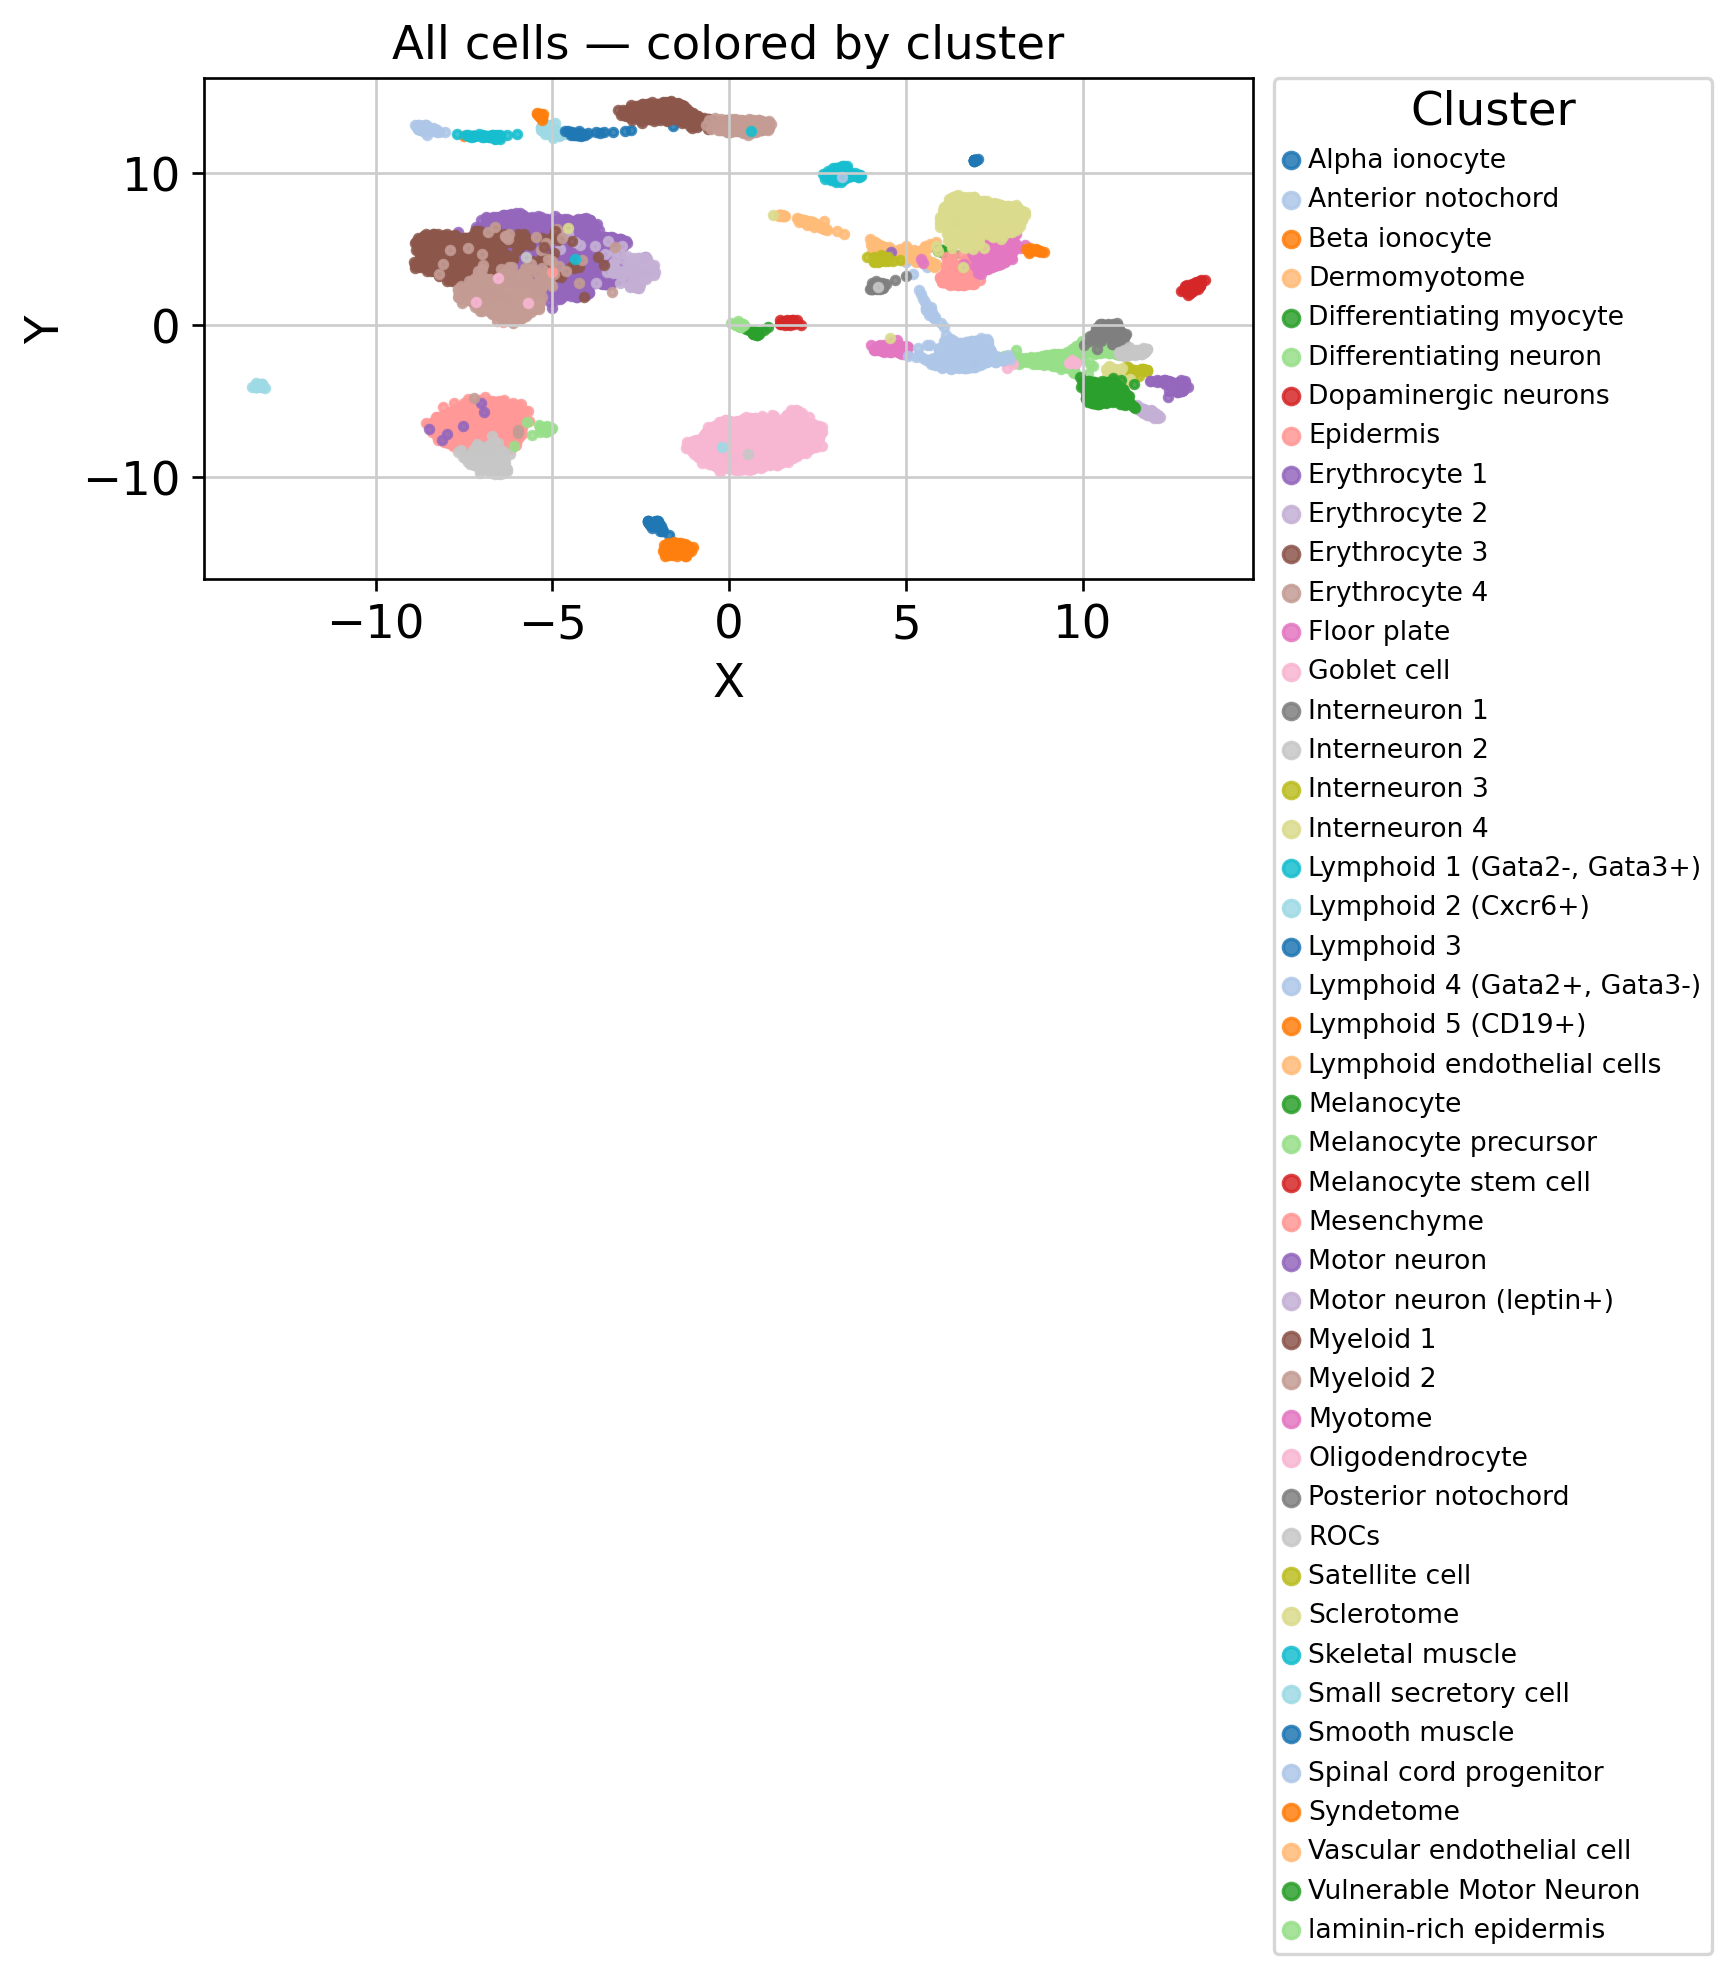

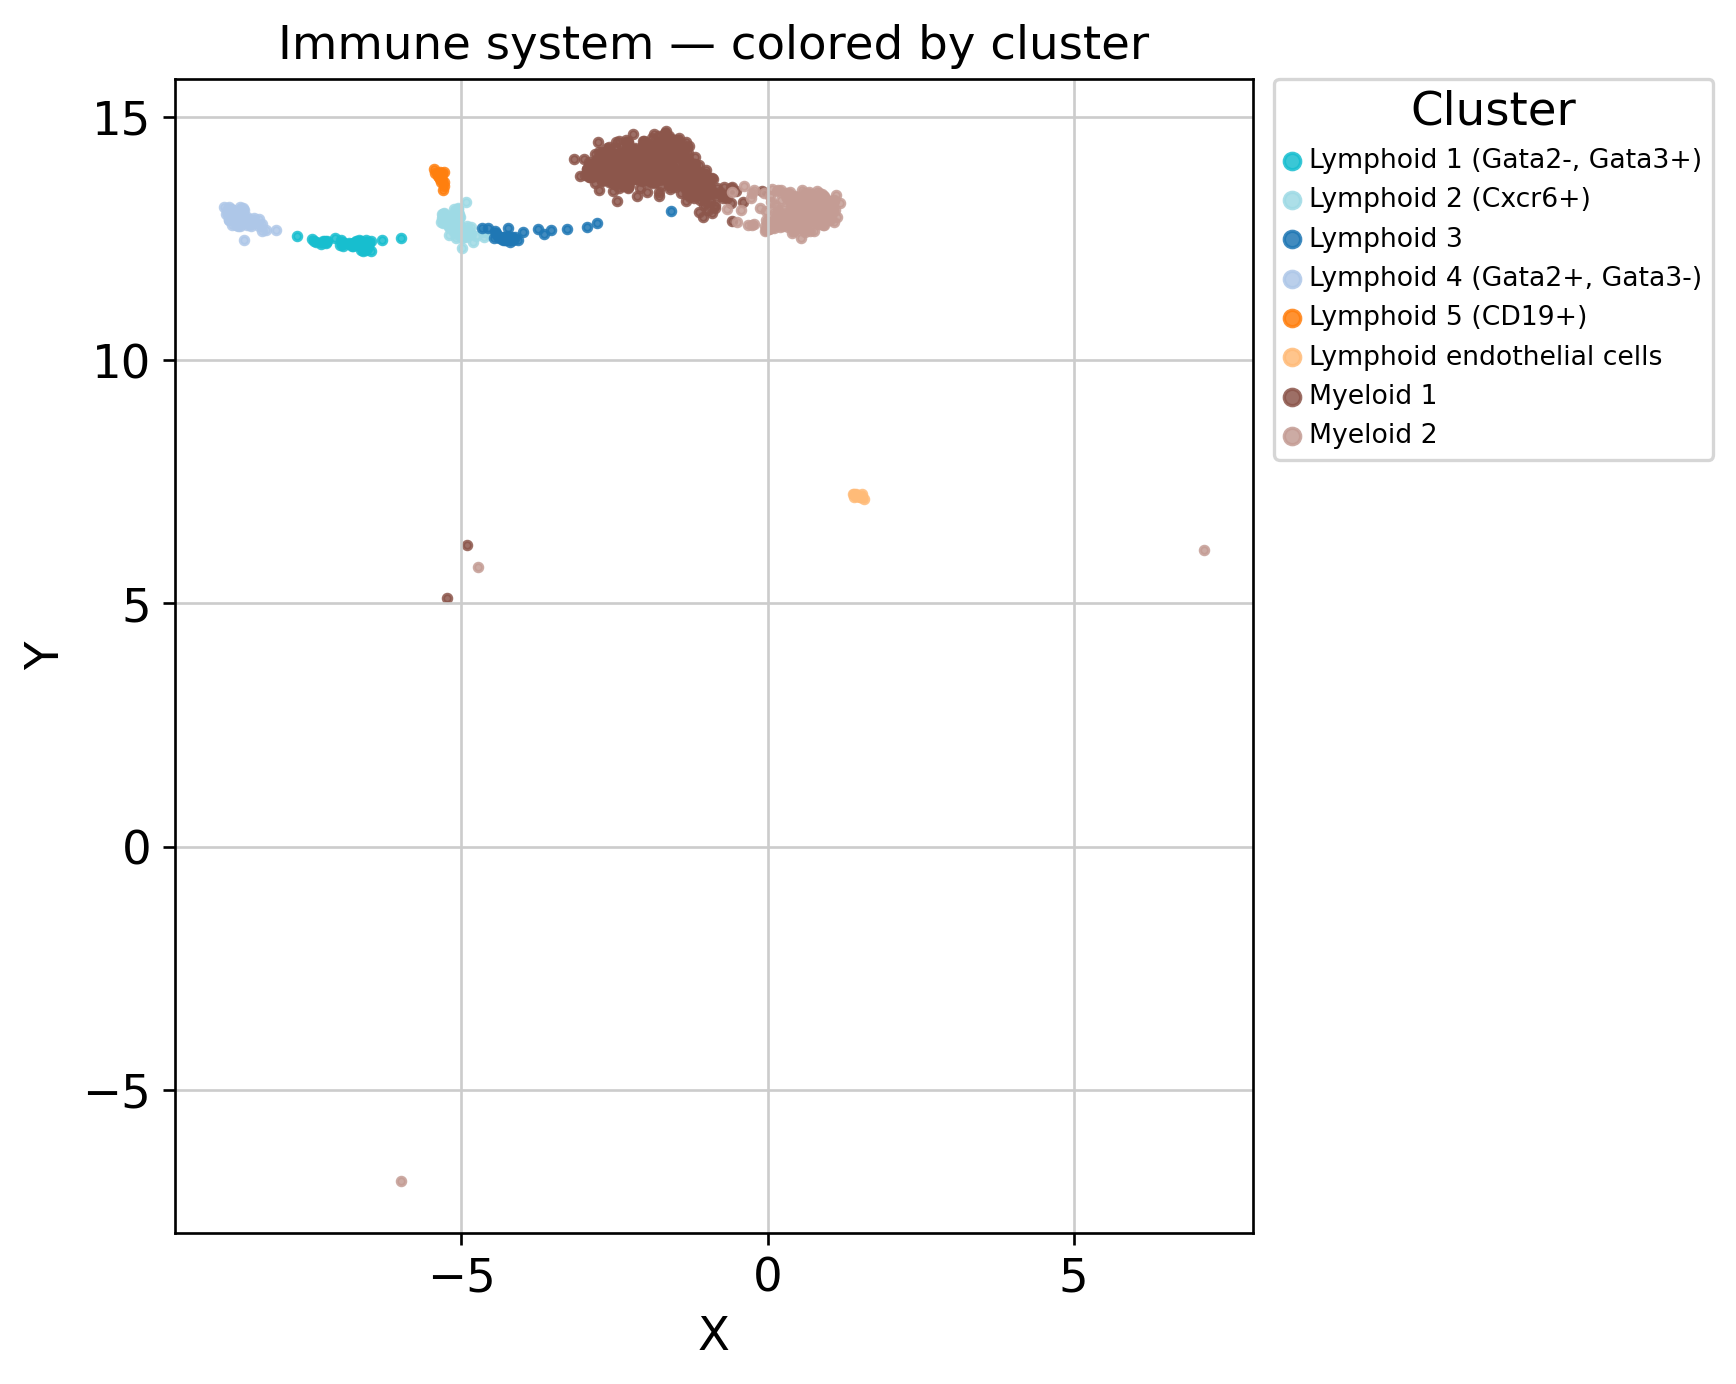

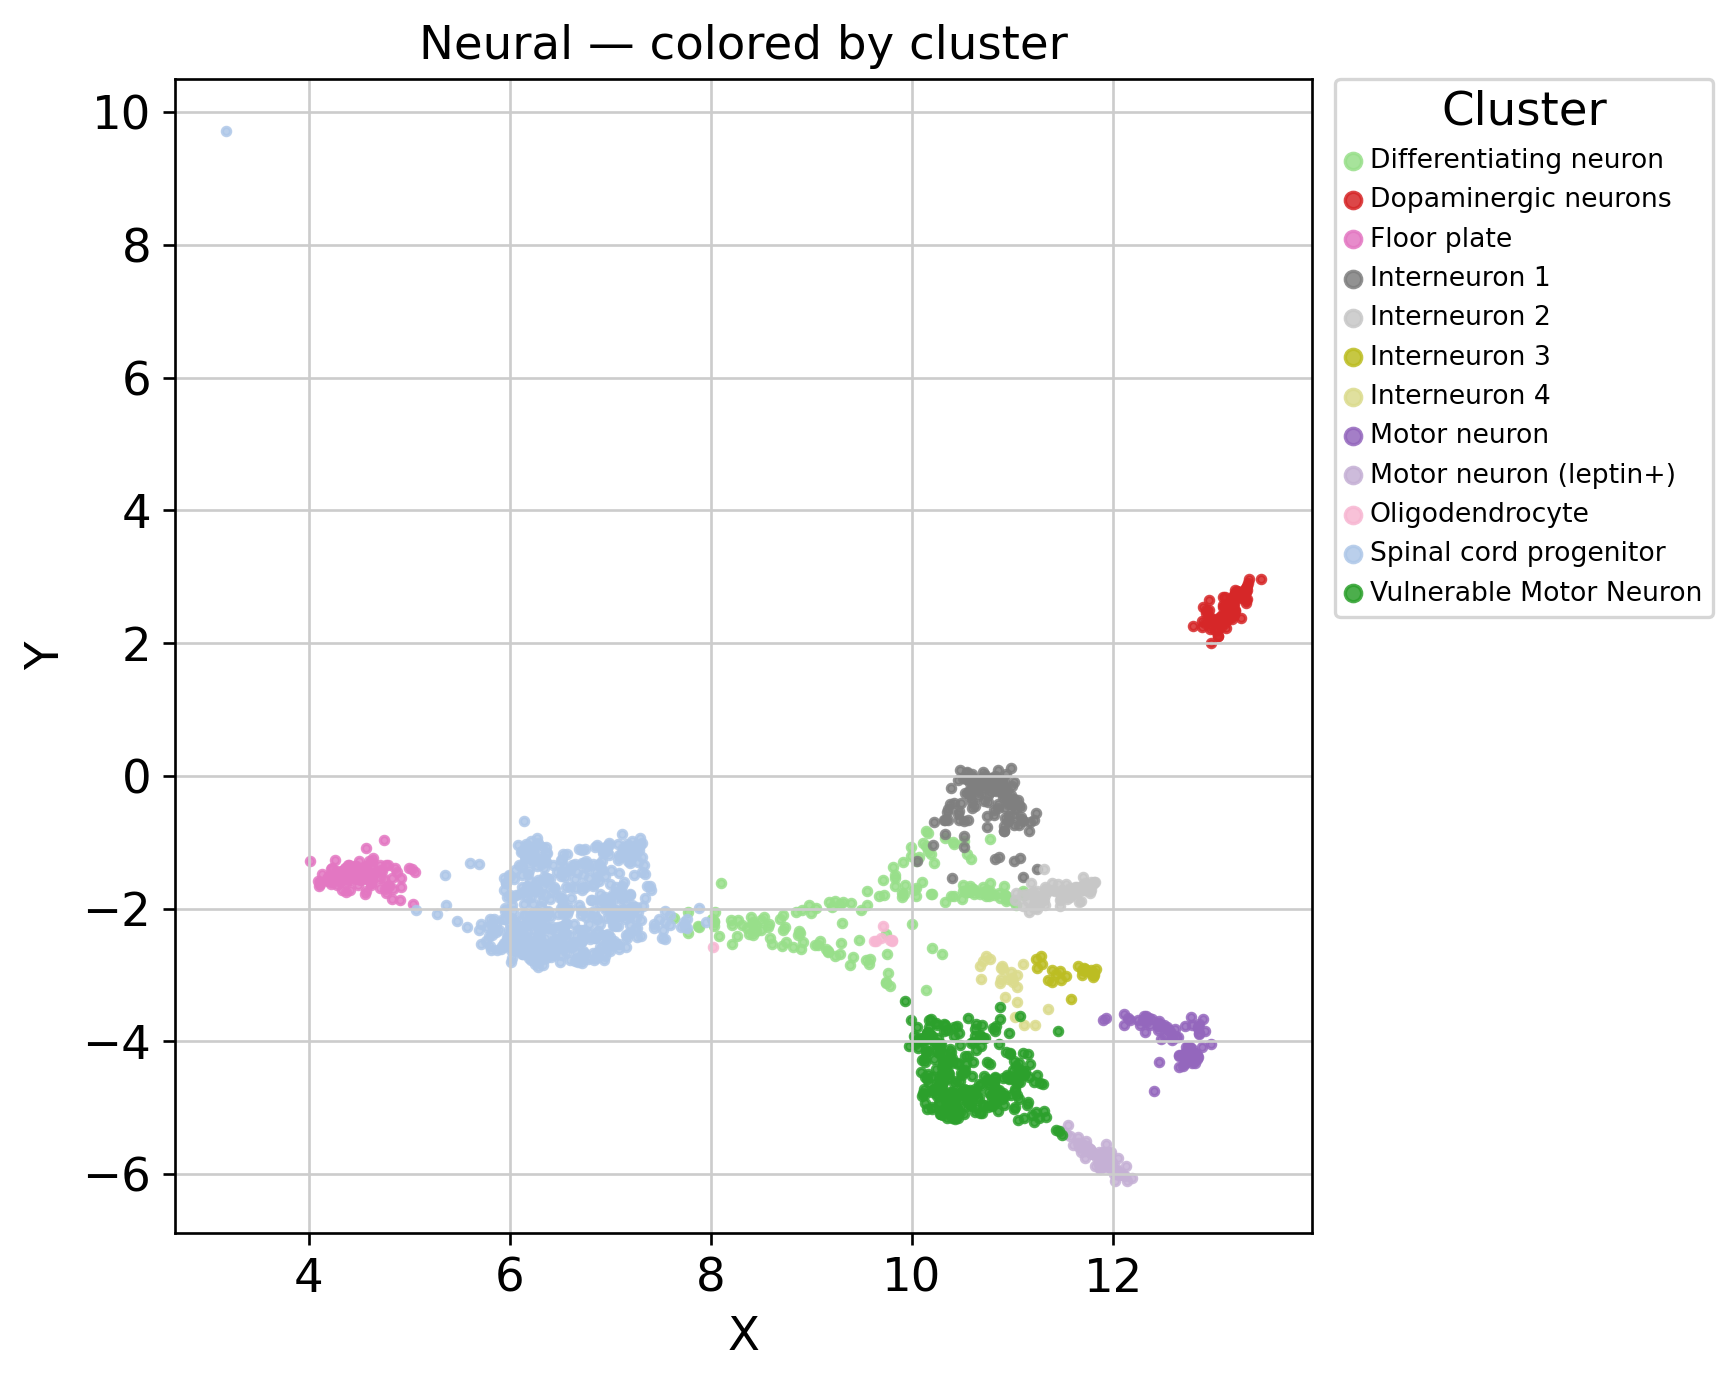

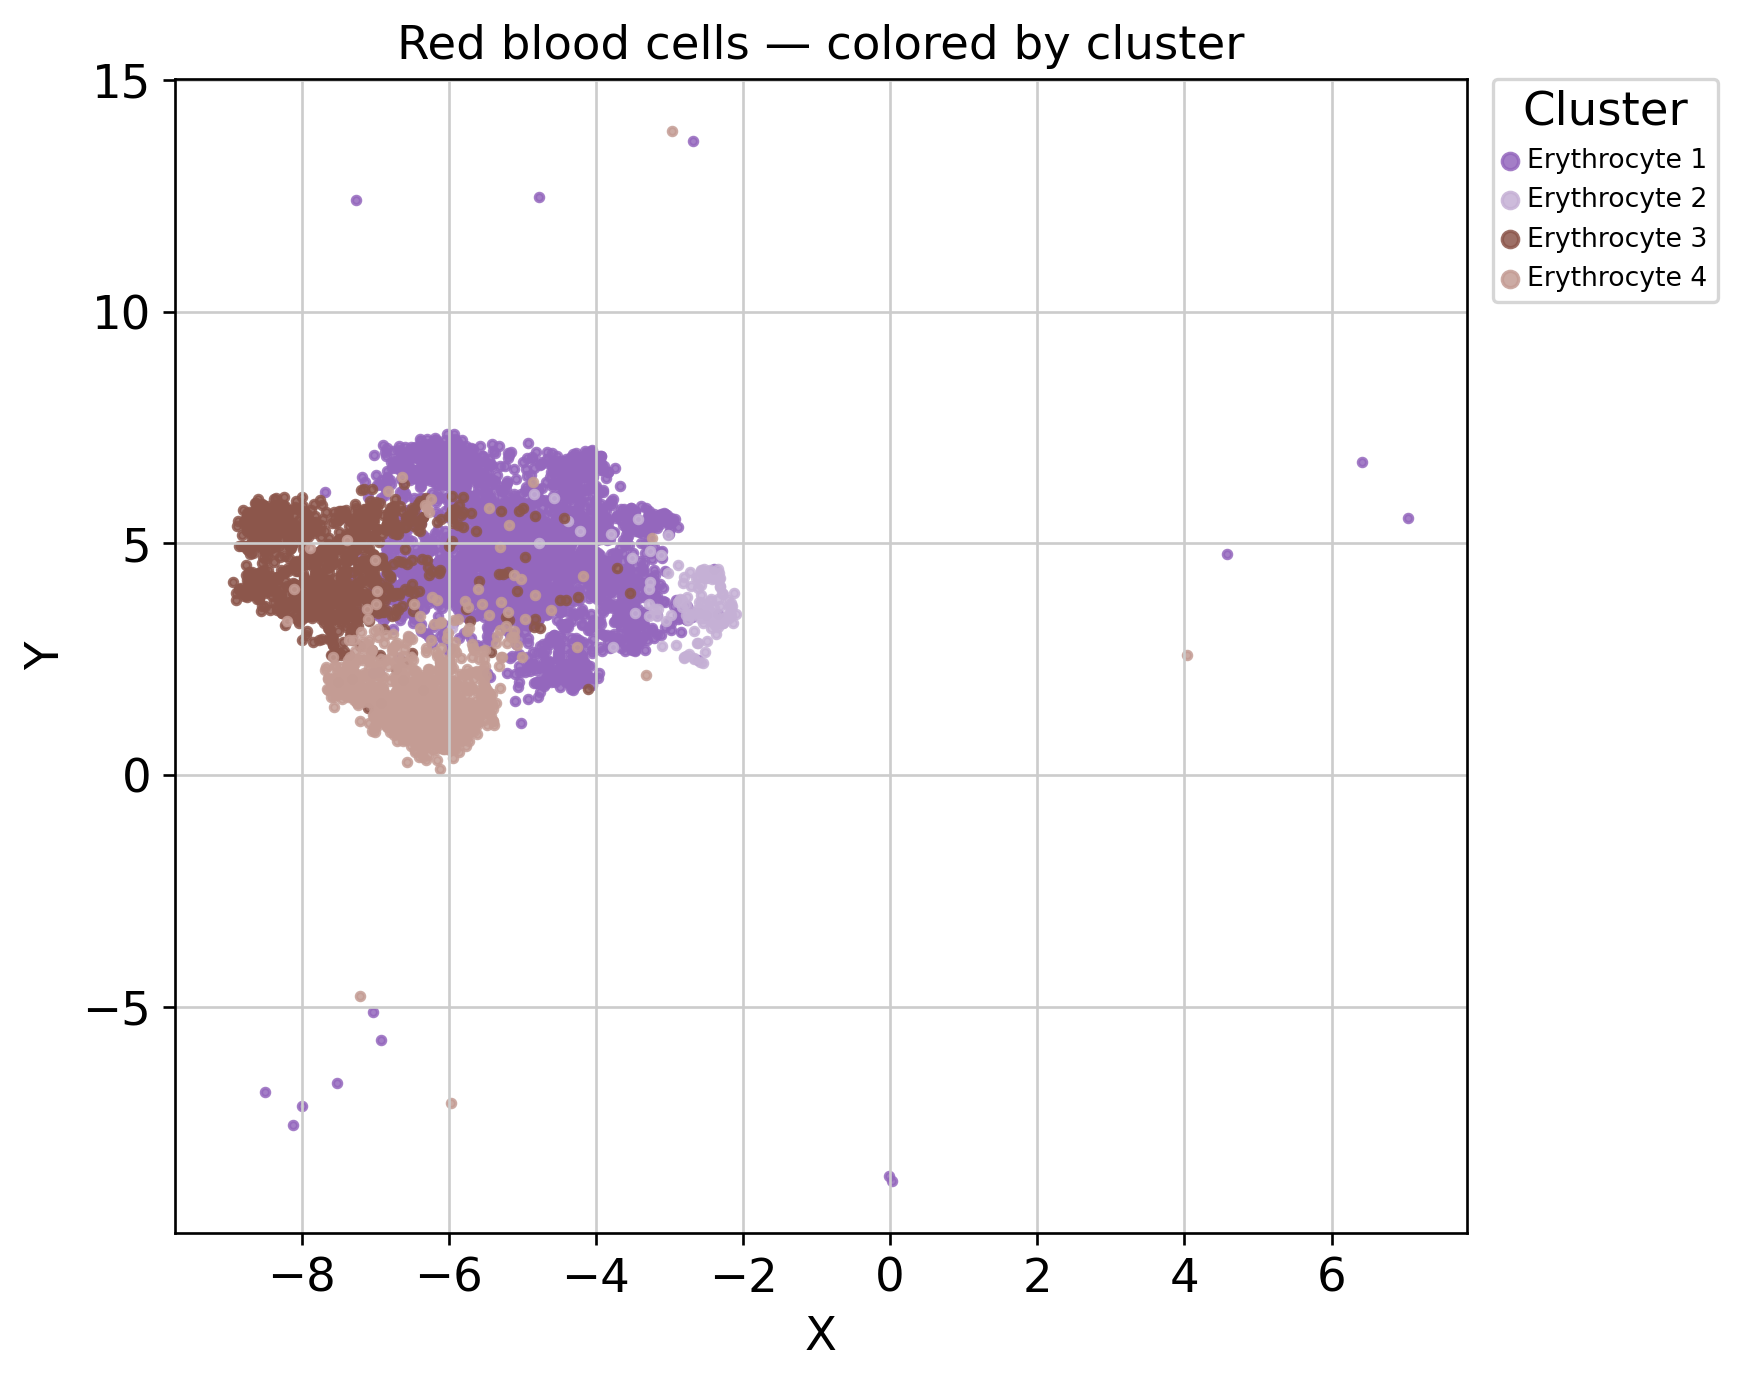

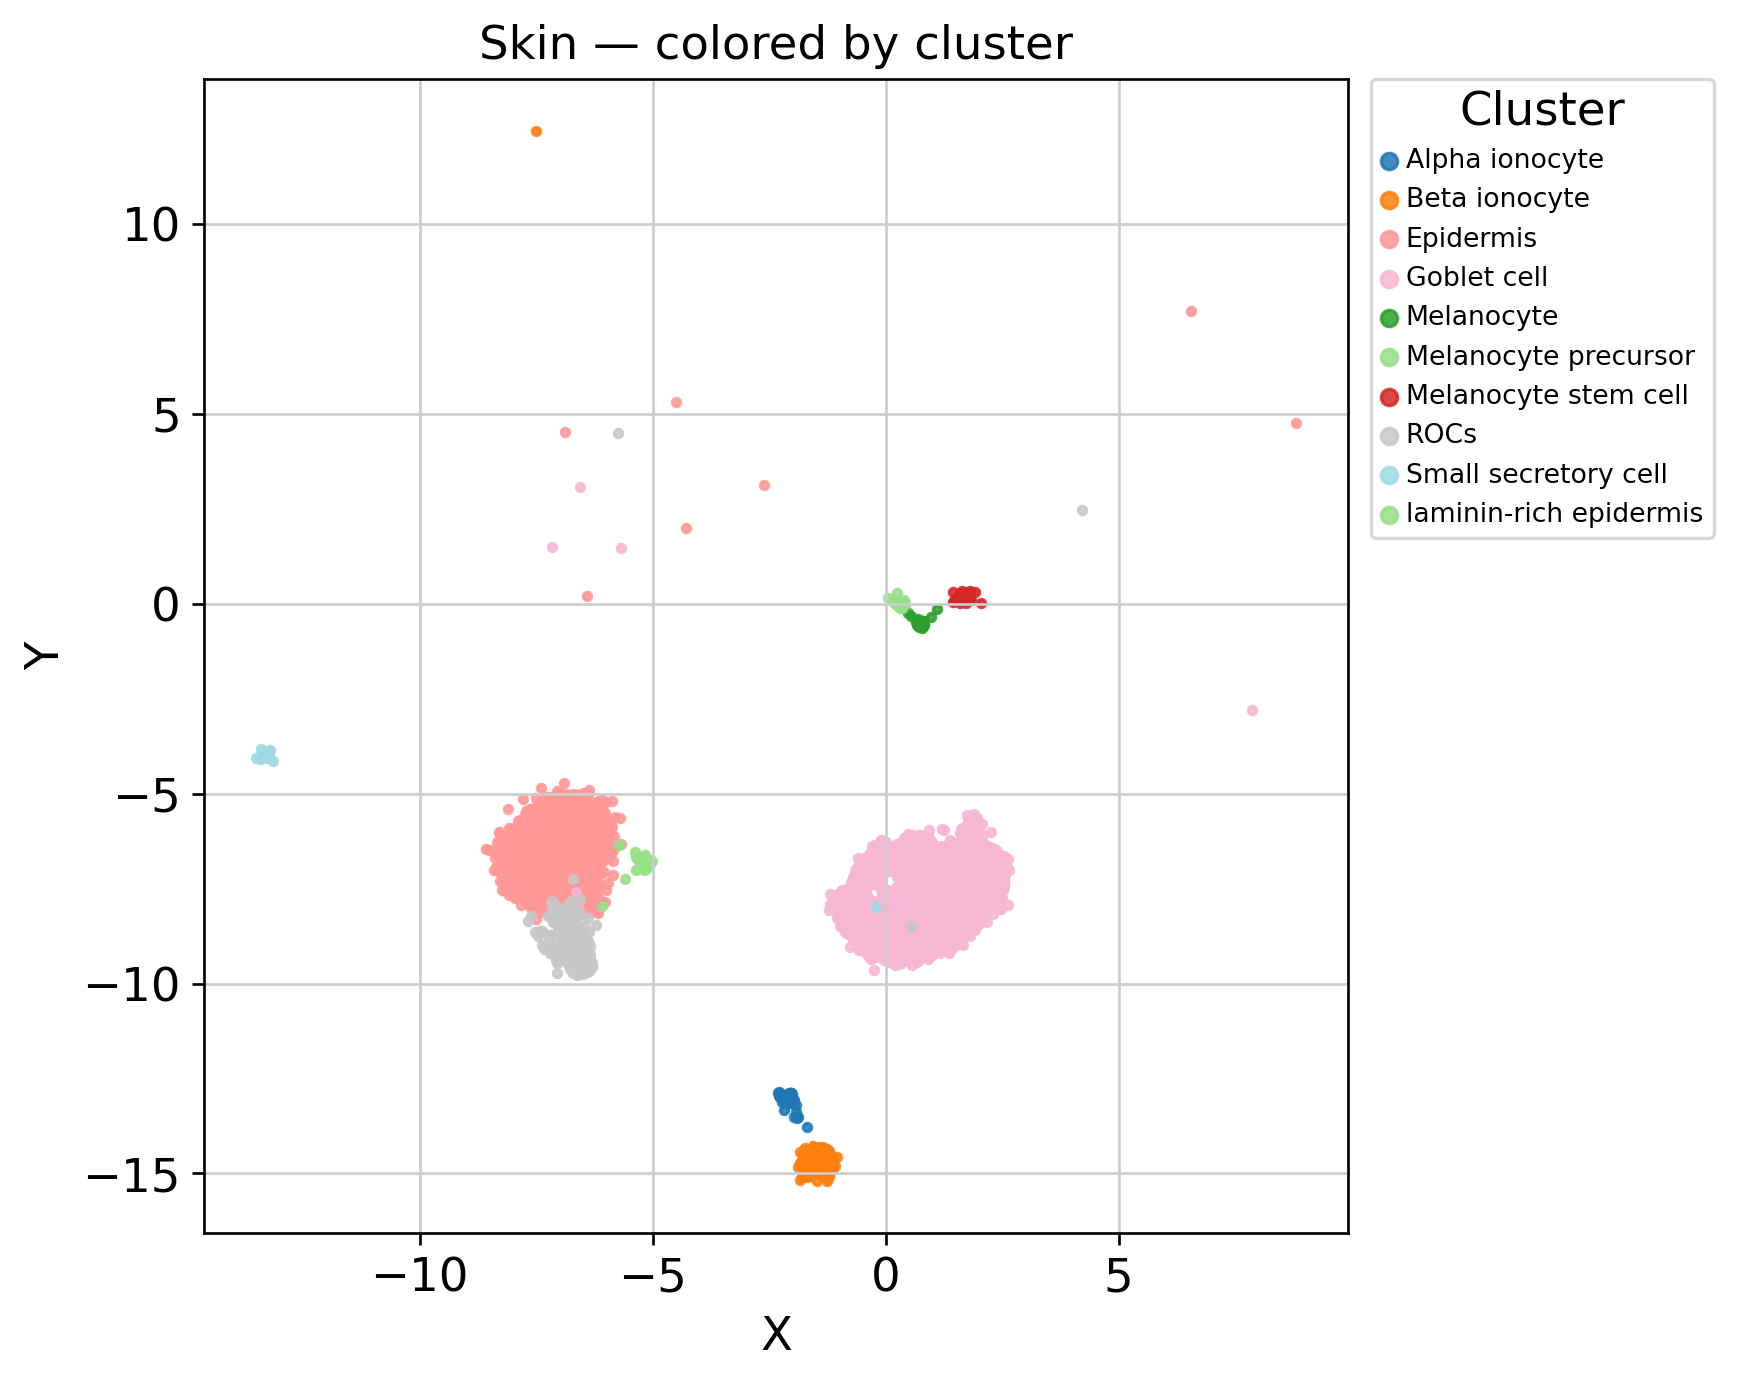

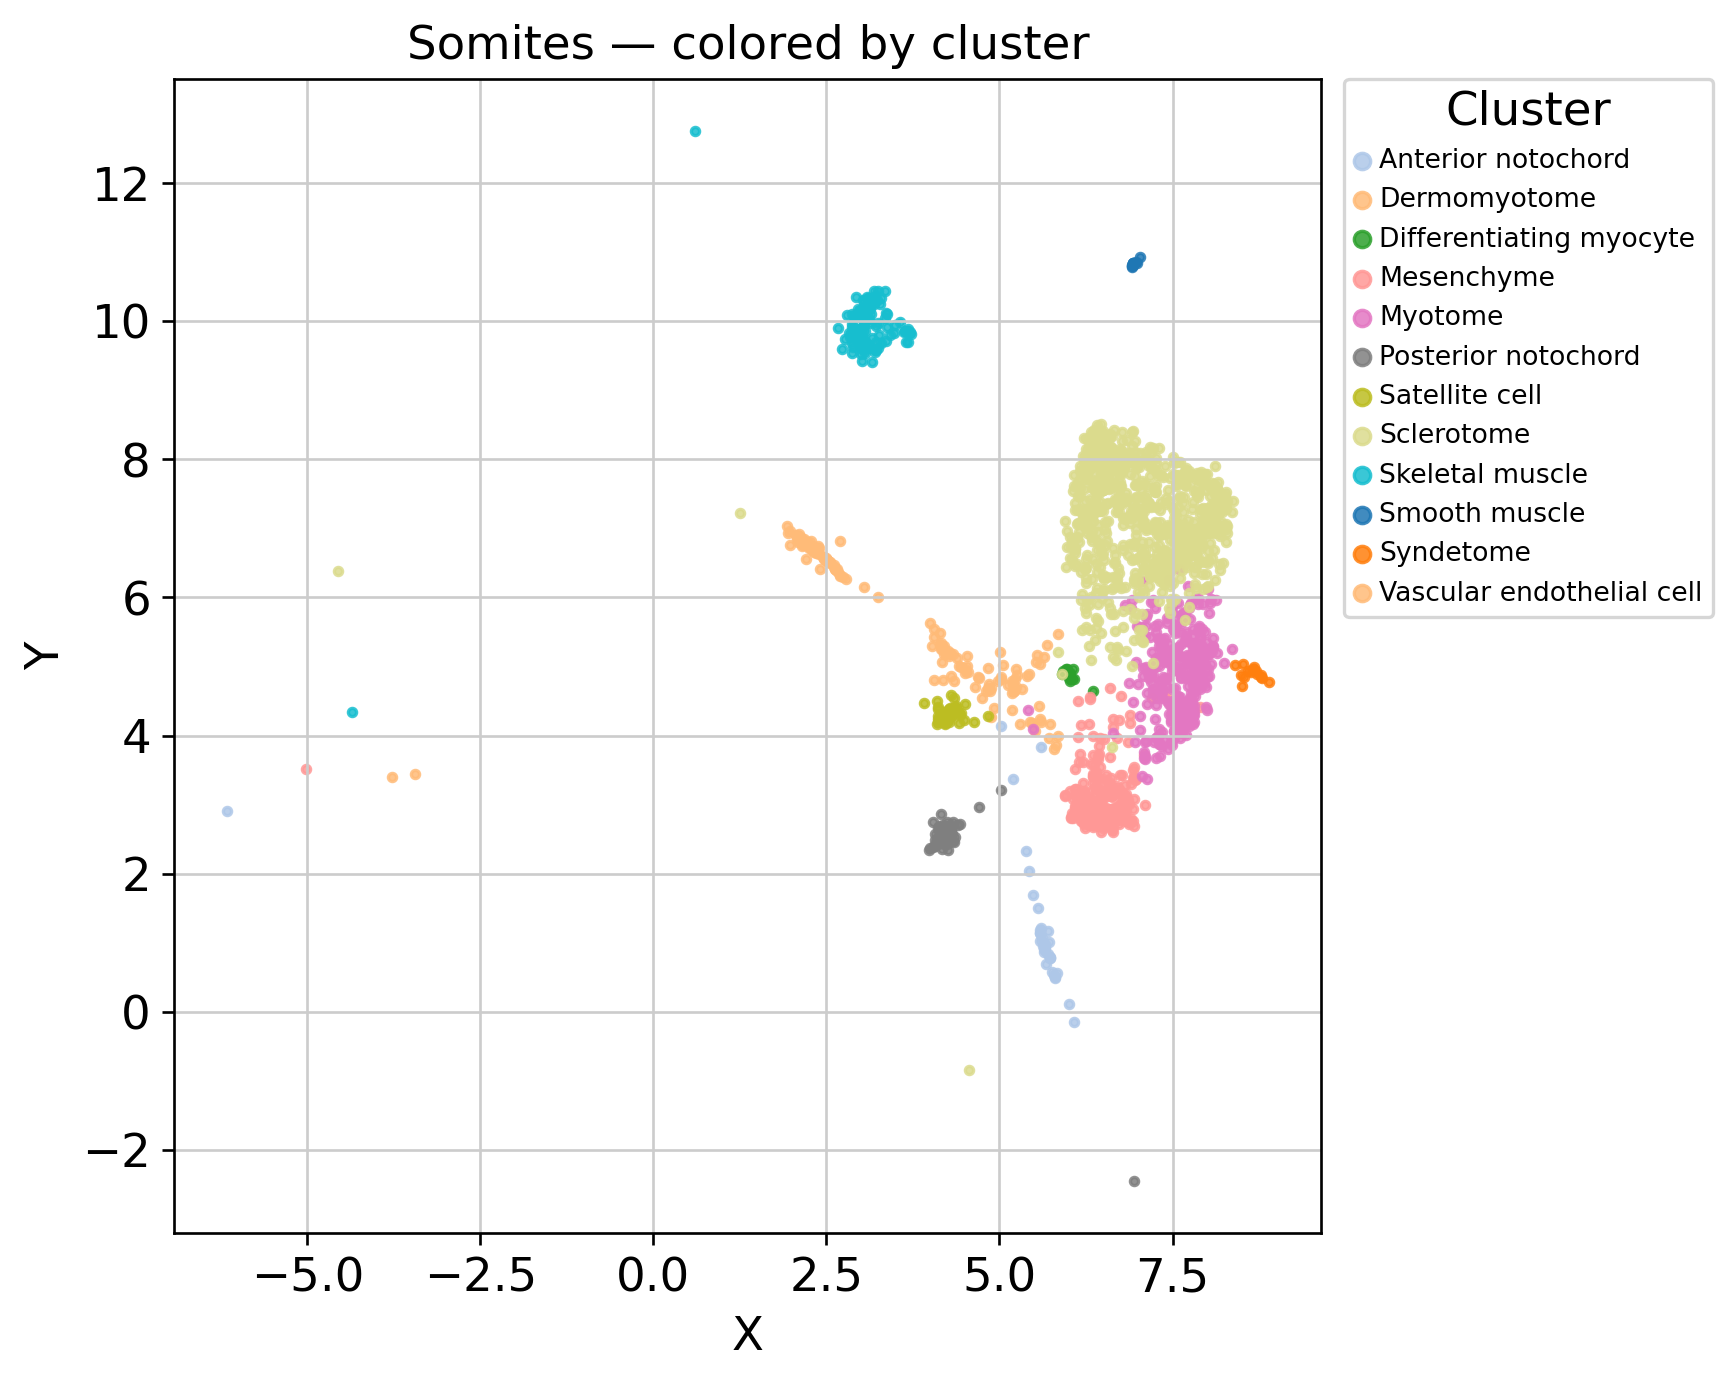

In [10]:
# @title Quick visualization
obs = adata.obs[['X', 'Y', 'cluster', 'category']].dropna(
    subset=['X', 'Y', 'cluster']
).copy()
obs['cluster'] = obs['cluster'].astype(str)

clusters = sorted(obs['cluster'].unique())
base = list(plt.cm.tab20.colors)
cluster_to_color = {cl: base[i % len(base)] for i, cl in enumerate(clusters)}


def scatter_by_cluster(df, title):
    """Create scatter plot colored by cluster."""
    plt.figure(figsize=(7.5, 6))
    for cl in clusters:
        sub = df[df['cluster'] == cl]
        if sub.empty:
            continue
        plt.scatter(
            sub['X'], sub['Y'],
            s=6,
            c=[cluster_to_color[cl]],
            label=cl,
            alpha=0.85
        )
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    leg = plt.legend(
        title="Cluster",
        bbox_to_anchor=(1.02, 1.0),
        loc="upper left",
        borderaxespad=0.,
        fontsize=8,
        markerscale=2
    )
    for h in getattr(leg, "legendHandles", []):
        try:
            h.set_sizes([20])
        except Exception:
            pass
    plt.tight_layout()
    plt.show()


scatter_by_cluster(obs, "All cells — colored by cluster")  # TODO: Fix the legend

for cat in sorted(obs['category'].dropna().unique()):
    scatter_by_cluster(obs[obs['category'] == cat], f"{cat} — colored by cluster")

## Clustering Method 1: Walktrap on UMAP Fuzzy Graph

**Algorithm**: Graph-based random walk clustering using UMAP's fuzzy simplicial set construction.

**Parameters**:
- k = 10 neighbors
- Metric: cosine distance
- Steps: 10 (random walk length)

**Evaluation**: Silhouette coefficient in native log2-HVG space with cosine metric

In [11]:
# @title Walktrap (UMAP fuzzy graph on log2 HVGs - as in the study)
# Build fuzzy simplicial set on unscaled log2 HVGs
X_log2 = adata.layers["log2"]
if hasattr(X_log2, "A"):
    X_log2 = X_log2.A

fs = fuzzy_simplicial_set(
    X=X_log2,
    n_neighbors=10,
    metric="cosine",
    random_state=np.random.RandomState(42),
    return_dists=False
)
fg = fs[0] if isinstance(fs, tuple) else fs

# Convert to igraph for Walktrap
coo = fg.tocoo()
g = ig.Graph(
    n=adata.n_obs,
    edges=list(zip(coo.row, coo.col)),
    directed=False
)
g.es["weight"] = coo.data.tolist()
g.simplify(combine_edges="sum", loops=False)

# Run Walktrap clustering
best_sil = -1.0
best_steps = None
best_labels = None
for steps in [10]:  # Paper hard set 10  # TODO: Remove?
    wt = g.community_walktrap(weights="weight", steps=steps).as_clustering()
    labels = np.array(wt.membership).astype(str)
    sil = float(silhouette_score(X_log2, labels, metric="cosine"))
    print(f"Walktrap steps={steps} → silhouette_native={sil:.3f}")
    if sil > best_sil:
        best_sil = sil
        best_steps = steps
        best_labels = labels

adata.obs["walktrap"] = best_labels

print(f"Chosen Walktrap: steps={best_steps}, silhouette_native={best_sil:.3f}")
Q = g.modularity(
    pd.Categorical(adata.obs["walktrap"]).codes,
    weights="weight"
)
print(f"Walktrap modularity on fuzzy graph: {Q:.3f}")

sc.pl.umap(
    adata,
    color="walktrap",
    legend_loc="on data",
    frameon=False,
    show=False
)
plt.savefig(
    f"{DIR_CLUSTERING}/clustering_umap_walktrap.png",

    bbox_inches="tight"
)
plt.close()

Walktrap steps=10 → silhouette_native=0.046
Chosen Walktrap: steps=10, silhouette_native=0.046
Walktrap modularity on fuzzy graph: 0.841


In [12]:
adata.obs['walktrap']

0        0
1        1
2        2
3        0
4        3
        ..
13194    0
13195    6
13196    6
13197    4
13198    6
Name: walktrap, Length: 13199, dtype: category
Categories (48, object): ['0', '1', '2', '3', ..., '44', '45', '46', '47']

Saved: /content/drive/MyDrive/STAT4243/roc_outputs_final/01_clustering/clustering_walktrap_quality_metrics.csv
Head(10):   cluster  n_cells    e_internal    a_strength  Q_contrib  count      mean  \
0       4     2536  13923.483911  30519.049380   0.133167   2536 -0.014516   
1       5     1861  11941.903153  24292.461512   0.121671   1861  0.008809   
2      10     1172   6696.460957  15439.507008   0.071533   1172  0.030564   
3       3     1011   6022.209185  13319.484112   0.065651   1011  0.023563   
4       0      910   5341.825037  12019.017600   0.058695    910  0.061182   
5       7      700   4290.003965   8962.889468   0.048413    700  0.073690   
6       6      744   4104.637103   9499.698593   0.045843    744  0.020922   
7       9      505   3207.763991   6538.321072   0.036818    505  0.041504   
8       1      489   3055.058530   6213.750701   0.035141    489  0.089432   
9       8      351   1860.114866   4255.208791   0.021589    351  0.021470   

     median       mi

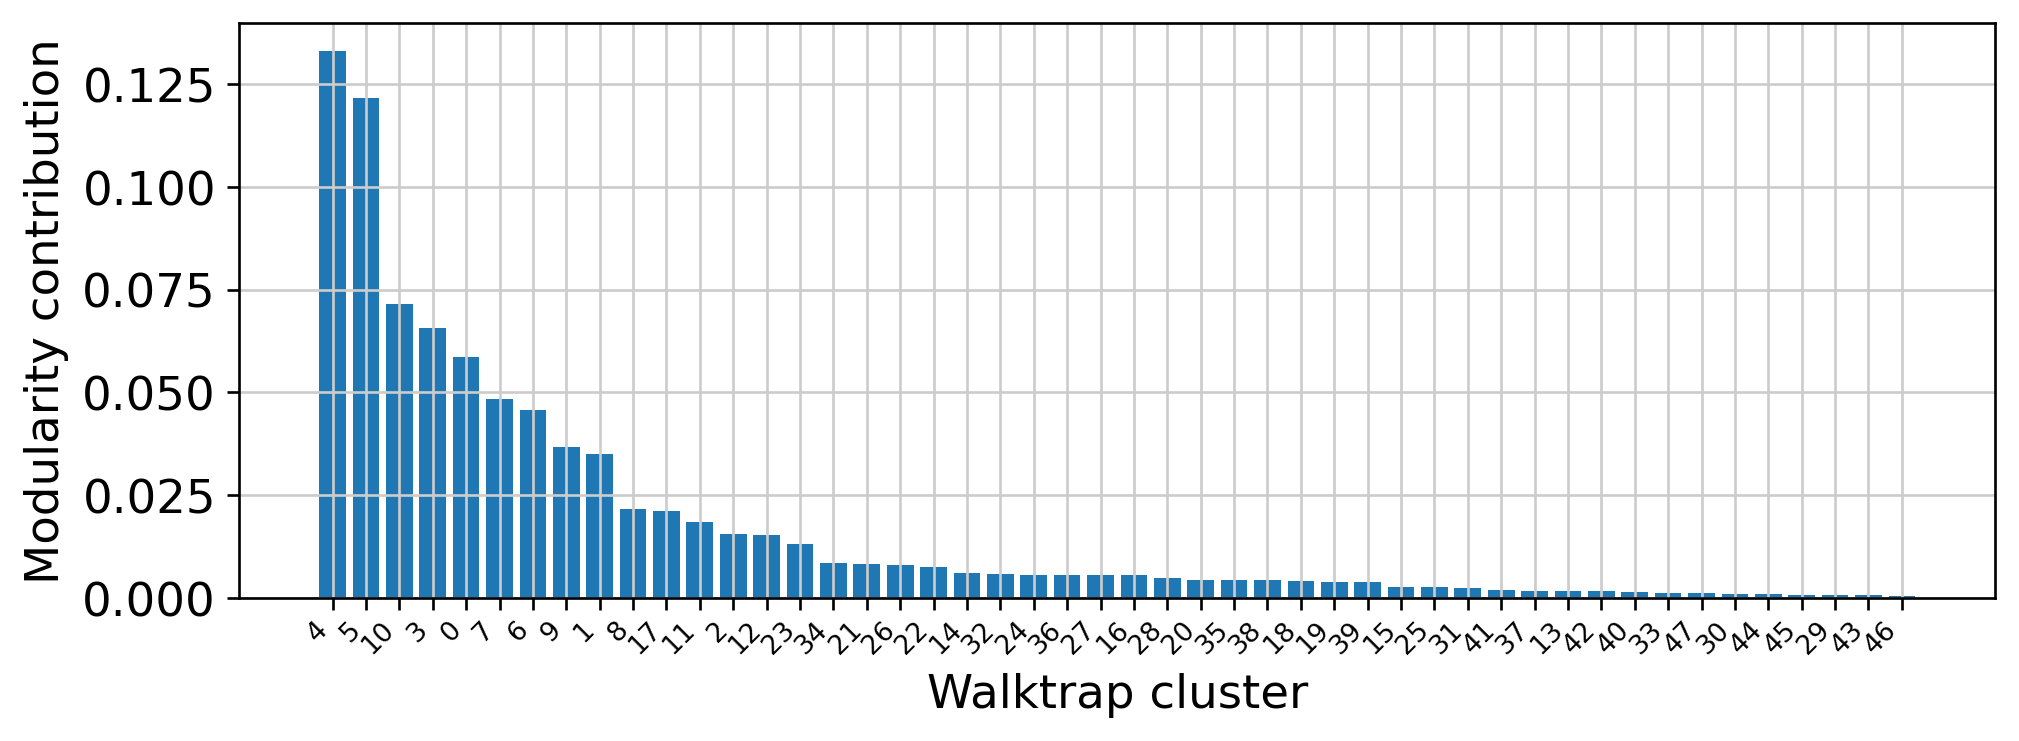

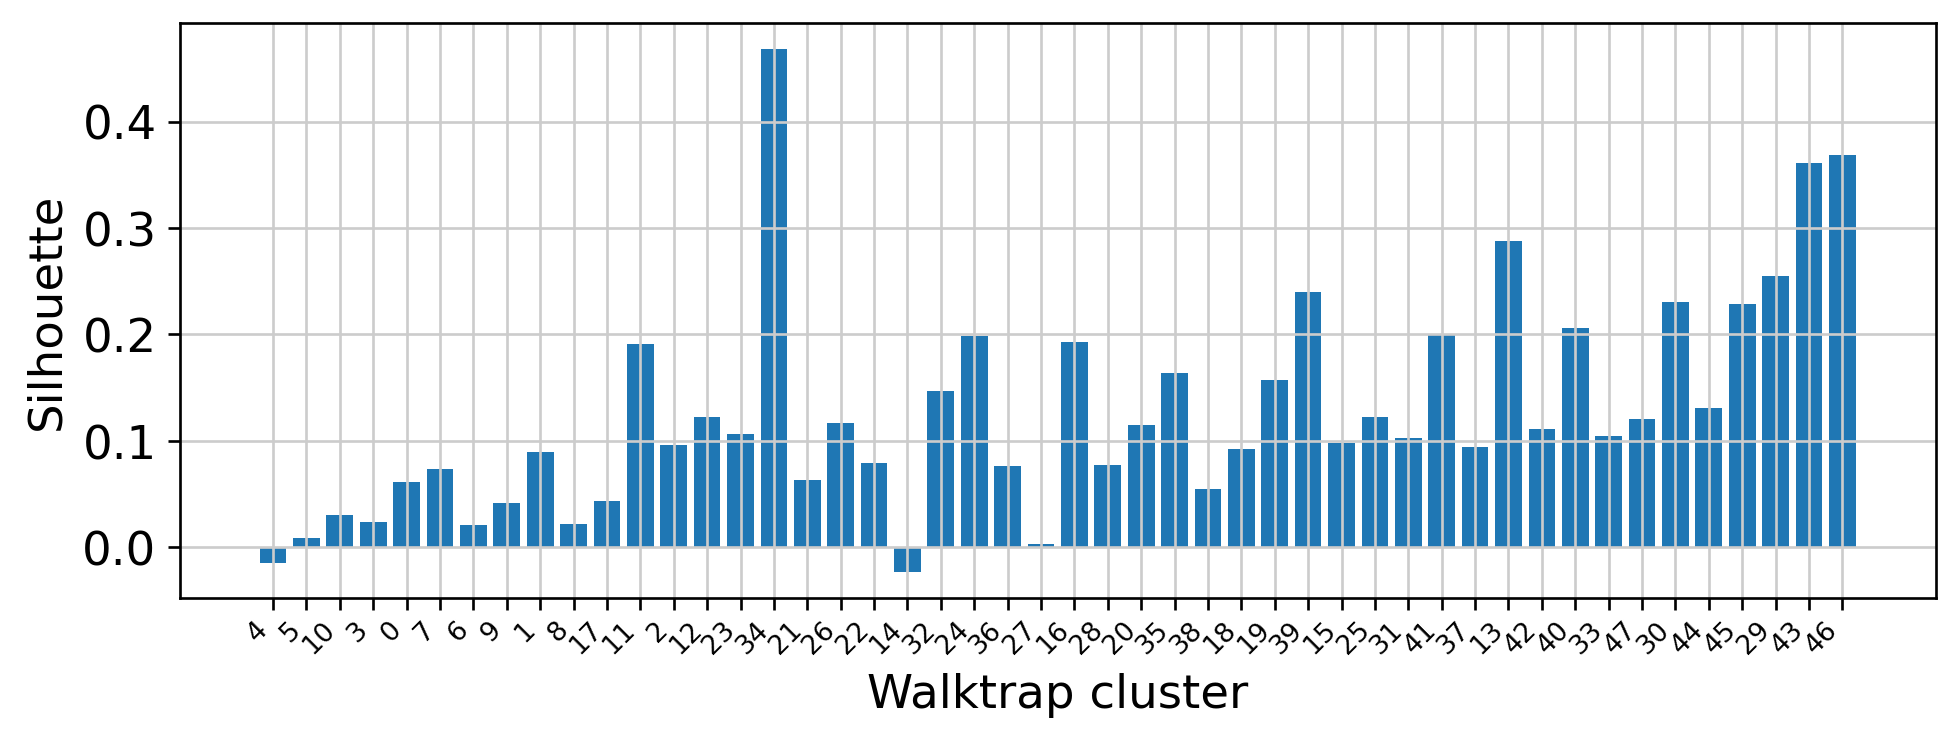

In [13]:
# @title Walktrap per-cluster quality: native-space silhouette + modularity

# TODO: Can probably remove this
assert "walktrap" in adata.obs.columns, "You didn't set adata.obs['walktrap']"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Native feature space (unscaled log2 HVGs) and labels
X_log2 = adata.layers["log2"]
if hasattr(X_log2, "A"):  # Sparse -> dense
    X_log2 = X_log2.A
labels = adata.obs["walktrap"].astype(str).to_numpy()

# Per-cell silhouette (native space), then aggregate by cluster
sil_cell = silhouette_samples(X_log2, labels, metric="cosine")
df_sil = pd.DataFrame({"cluster": labels, "silhouette": sil_cell})
sil_per = df_sil.groupby("cluster")["silhouette"].agg(
    ["count", "mean", "median", "min", "max"]
).reset_index()

# Build the UMAP fuzzy graph (k=10, cosine) and igraph
fs = fuzzy_simplicial_set(
    X=X_log2,
    n_neighbors=10,
    metric="cosine",
    random_state=np.random.RandomState(42),  # Ensure repeatability
    return_dists=False
)
fg = fs[0] if isinstance(fs, tuple) else fs
coo = fg.tocoo()
g = ig.Graph(n=adata.n_obs, edges=list(zip(coo.row, coo.col)), directed=False)
g.es["weight"] = coo.data.tolist()
g.simplify(combine_edges="sum", loops=False)

# Modularity contribution per cluster
# Q_c = (e_c / m) - (a_c / (2m))^2
# where m = total edge weight, e_c = internal edge weight within cluster c,
#       a_c = sum of strengths (weighted degrees) of nodes in c
ew = np.array(g.es["weight"], dtype=float)
ends = np.array(g.get_edgelist(), dtype=int)
m_total = ew.sum()  # Total weight (each undirected edge counted once)
strength = np.array(g.strength(weights="weight"), dtype=float)

labs_unique = pd.Index(pd.unique(labels))
lab_to_int = {lab: i for i, lab in enumerate(labs_unique)}
c_ids = np.array([lab_to_int[x] for x in labels], dtype=int)

# Internal weights per cluster
int_weight = {lab: 0.0 for lab in labs_unique}
for (u, v), w in zip(ends, ew):
    if c_ids[u] == c_ids[v]:
        int_weight[labs_unique[c_ids[u]]] += w

# Total strength per cluster
sum_strength = {
    lab: float(st) for lab, st in
    zip(
        labs_unique,
        np.bincount(c_ids, weights=strength, minlength=len(labs_unique))
    )
}

rows = []
for lab in labs_unique:
    e_c = int_weight[lab]
    a_c = sum_strength[lab]
    Q_c = (e_c / m_total) - (a_c / (2 * m_total)) ** 2
    n_c = int((labels == lab).sum())
    rows.append({
        "cluster": str(lab),
        "n_cells": n_c,
        "e_internal": e_c,
        "a_strength": a_c,
        "Q_contrib": Q_c
    })

mod_per = pd.DataFrame(rows).sort_values(
    "Q_contrib",
    ascending=False
).reset_index(drop=True)

# Merge, save CSV, and show in notebook + save plots
qual = pd.merge(mod_per, sil_per, on="cluster", how="left")

csv_path = os.path.join(
    DIR_CLUSTERING,
    "clustering_walktrap_quality_metrics.csv"
)
qual.to_csv(csv_path, index=False)
print("Saved:", csv_path)

print("Head(10):", qual.head(10))

# Bar: modularity contribution
fig, ax = plt.subplots(figsize=(9.5, 3.8))
ax.bar(qual["cluster"].astype(str), qual["Q_contrib"].values)
ax.set_xlabel("Walktrap cluster")
ax.set_ylabel("Modularity contribution")
plt.xticks(rotation=45, ha="right", fontsize=8)
ax.tick_params(axis="x", pad=2)
fig.subplots_adjust(bottom=0.28, right=0.95)
os.path.join(DIR_CLUSTERING, "clustering_walktrap_modularity_barplot.png"),
plt.show()
fig.savefig(
    os.path.join(OUTPUT_DIR, "walktrap_modularity_by_cluster.png"),
    dpi=200,
    bbox_inches="tight"
)
plt.close(fig)

# Bar: silhouette mean
fig, ax = plt.subplots(figsize=(9.5, 3.8))
ax.bar(qual["cluster"].astype(str), qual["mean"].values)
ax.set_xlabel("Walktrap cluster")
ax.set_ylabel("Silhouette")
plt.xticks(rotation=45, ha="right", fontsize=8)
ax.tick_params(axis="x", pad=2)
fig.subplots_adjust(bottom=0.28, right=0.95)
os.path.join(DIR_CLUSTERING, "clustering_walktrap_silhouette_barplot.png"),
plt.show()
fig.savefig(
    os.path.join(OUTPUT_DIR, "walktrap_silhouette_by_cluster.png"),
    dpi=200,

    bbox_inches="tight"
)
plt.close(fig)

## Clustering Method 2: Leiden (Modularity Optimization)

**Algorithm**: Modularity optimization on k-NN graph in PCA space.

**Parameters**:
- Resolution: 1.0
- k-NN graph: 20 neighbors on 40 PCs
- Metric: cosine distance

**Evaluation**: Silhouette coefficient in PCA space (first 20 components)

{
  "walktrap": {
    "silhouette_native_log2HVG_cosine": 0.04562202841043472
  },
  "leiden": {
    "silhouette_PCA_cosine": 0.2790376842021942
  },
  "walktrap~leiden": {
    "ARI": 0.5980099932684259,
    "Rand": 0.9392944684478971
  }
}


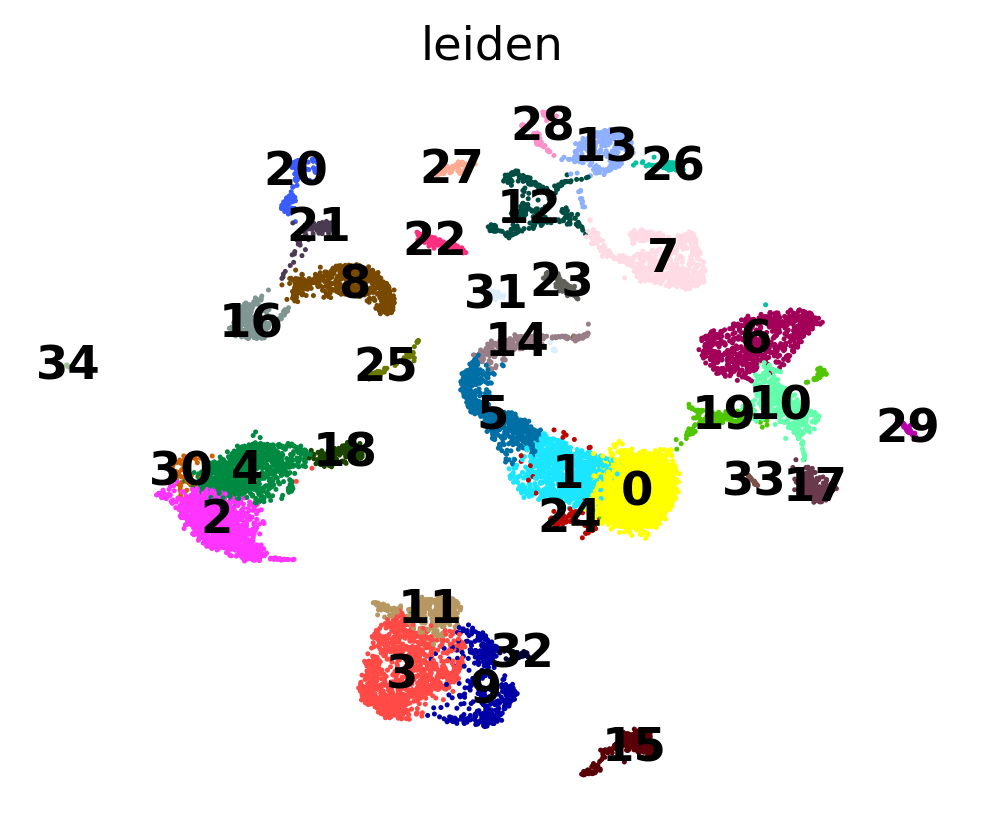

In [14]:
# @title Leiden + metrics
# Run Leiden clustering
sc.tl.leiden(adata, key_added="leiden", resolution=1.0)

# Calculate metrics in appropriate spaces
X_pca = adata.obsm["X_pca"][:, :20]
X_log2 = (adata.layers["log2"].A if hasattr(adata.layers["log2"], "A")
          else adata.layers["log2"])

sil_walktrap_native = float(
    silhouette_score(X_log2, adata.obs["walktrap"], metric="cosine")
)
sil_leiden_pca = float(
    silhouette_score(X_pca, adata.obs["leiden"], metric="cosine")
)
ari = float(adjusted_rand_score(adata.obs["walktrap"], adata.obs["leiden"]))
rand = float(rand_score(adata.obs["walktrap"], adata.obs["leiden"]))

metrics = {
    "walktrap": {"silhouette_native_log2HVG_cosine": sil_walktrap_native},
    "leiden": {"silhouette_PCA_cosine": sil_leiden_pca},
    "walktrap~leiden": {"ARI": ari, "Rand": rand}
}
print(json.dumps(metrics, indent=2))
open(f"{DIR_CLUSTERING}/clustering_metrics_baseline.json", "w").write(
    json.dumps(metrics, indent=2)
)

sc.pl.umap(
    adata,
    color="leiden",
    legend_loc="on data",
    frameon=False,
    show=False
)
plt.show()
plt.savefig(
    f"{DIR_CLUSTERING}/clustering_umap_leiden.png",
    bbox_inches="tight"
)
plt.close()

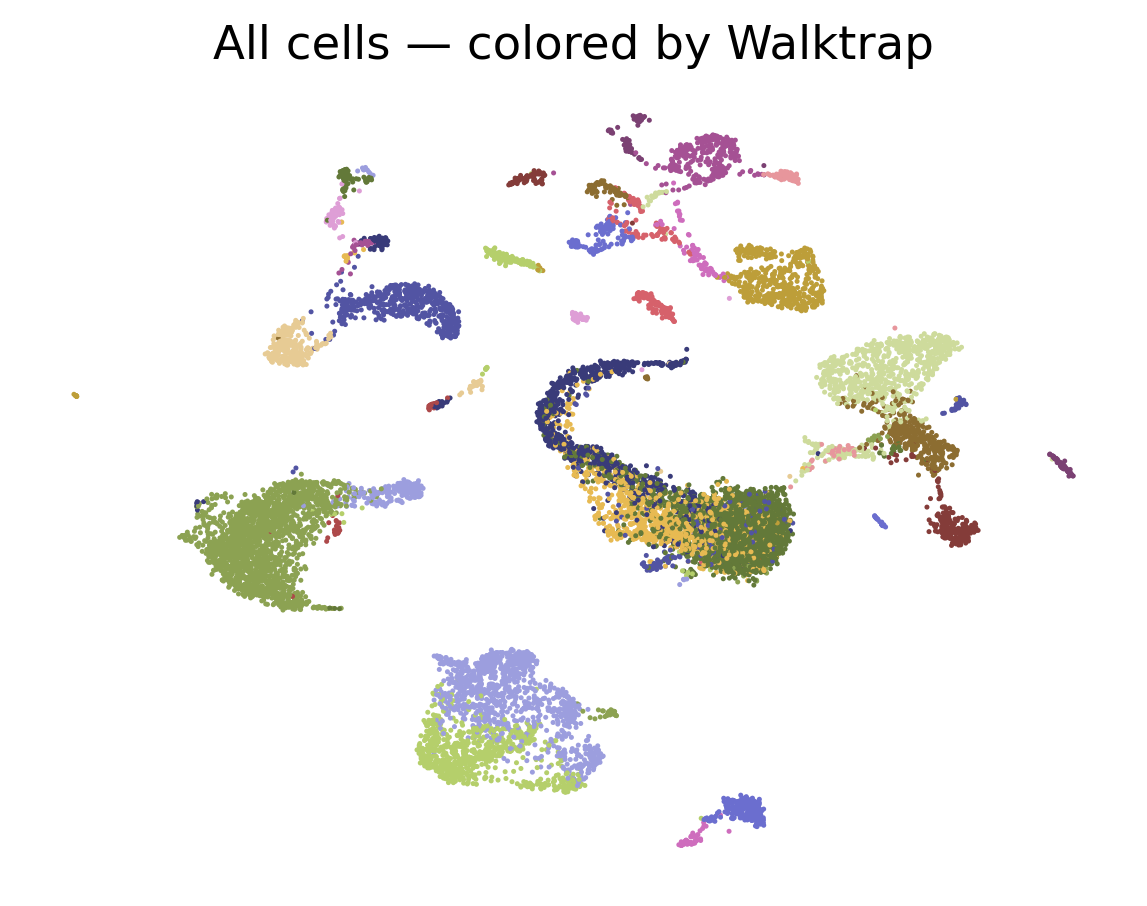

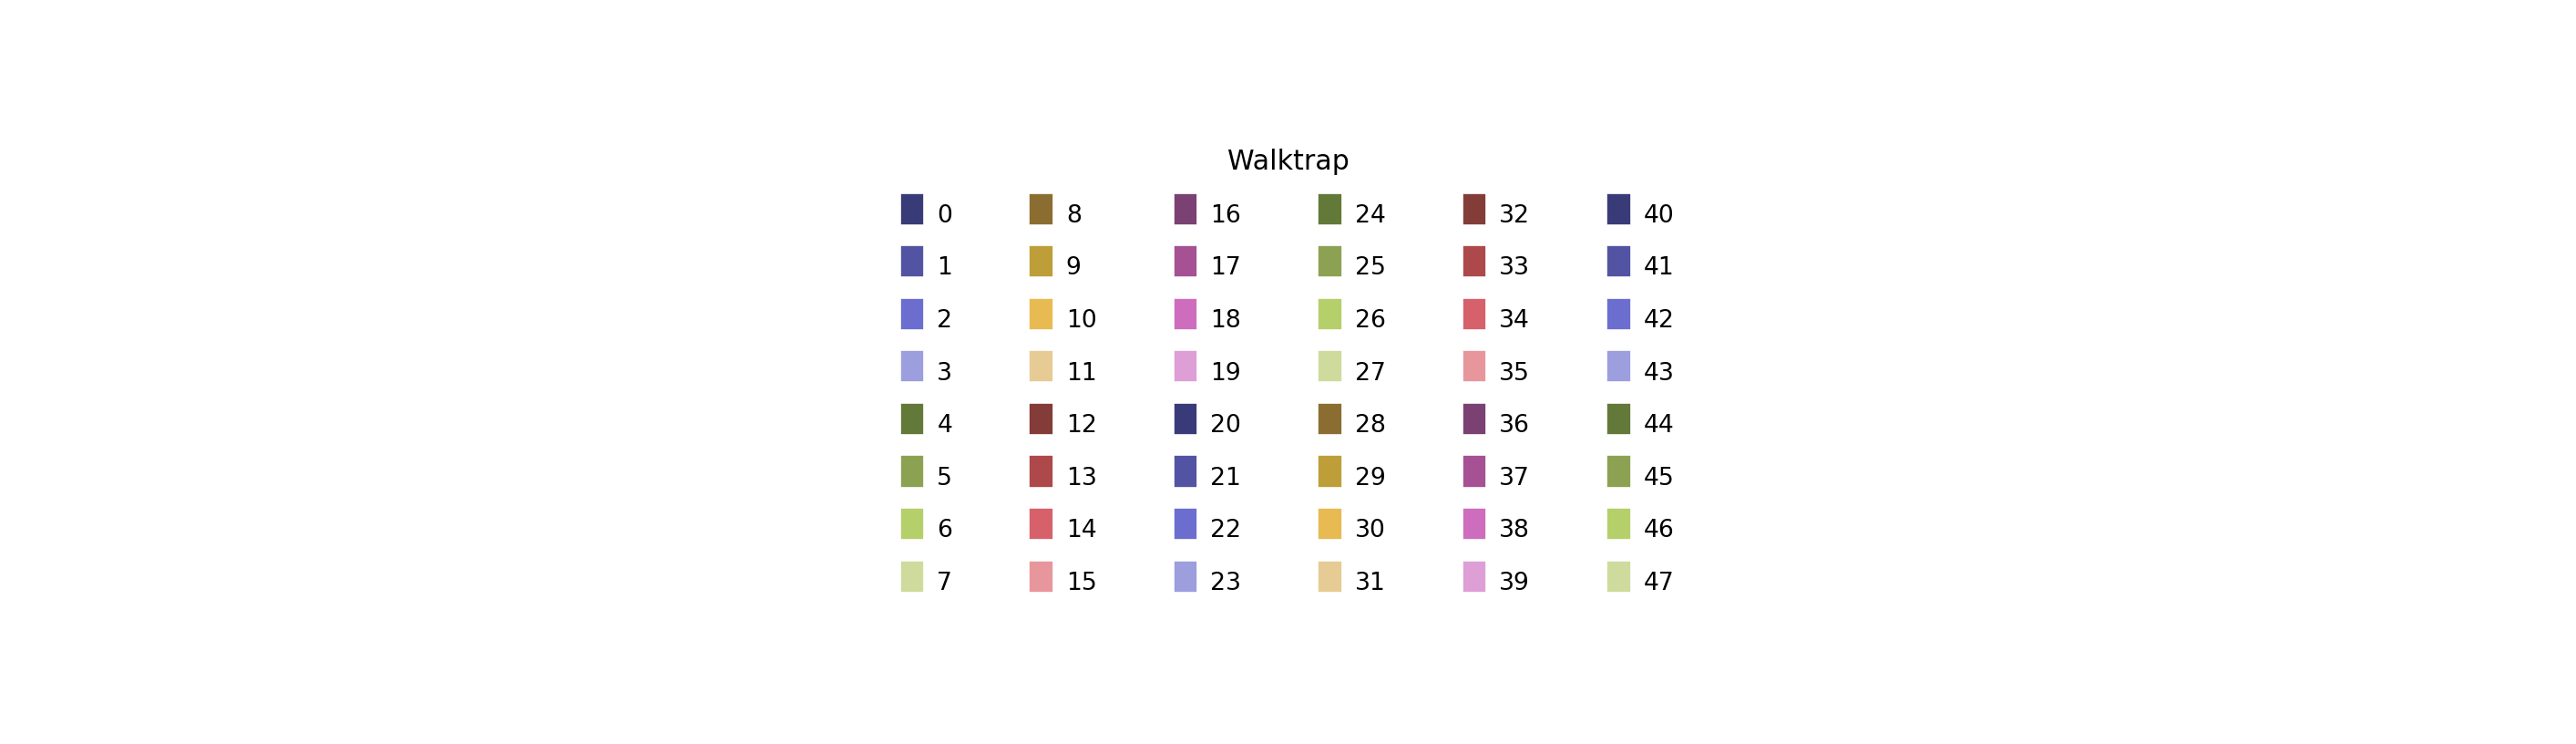

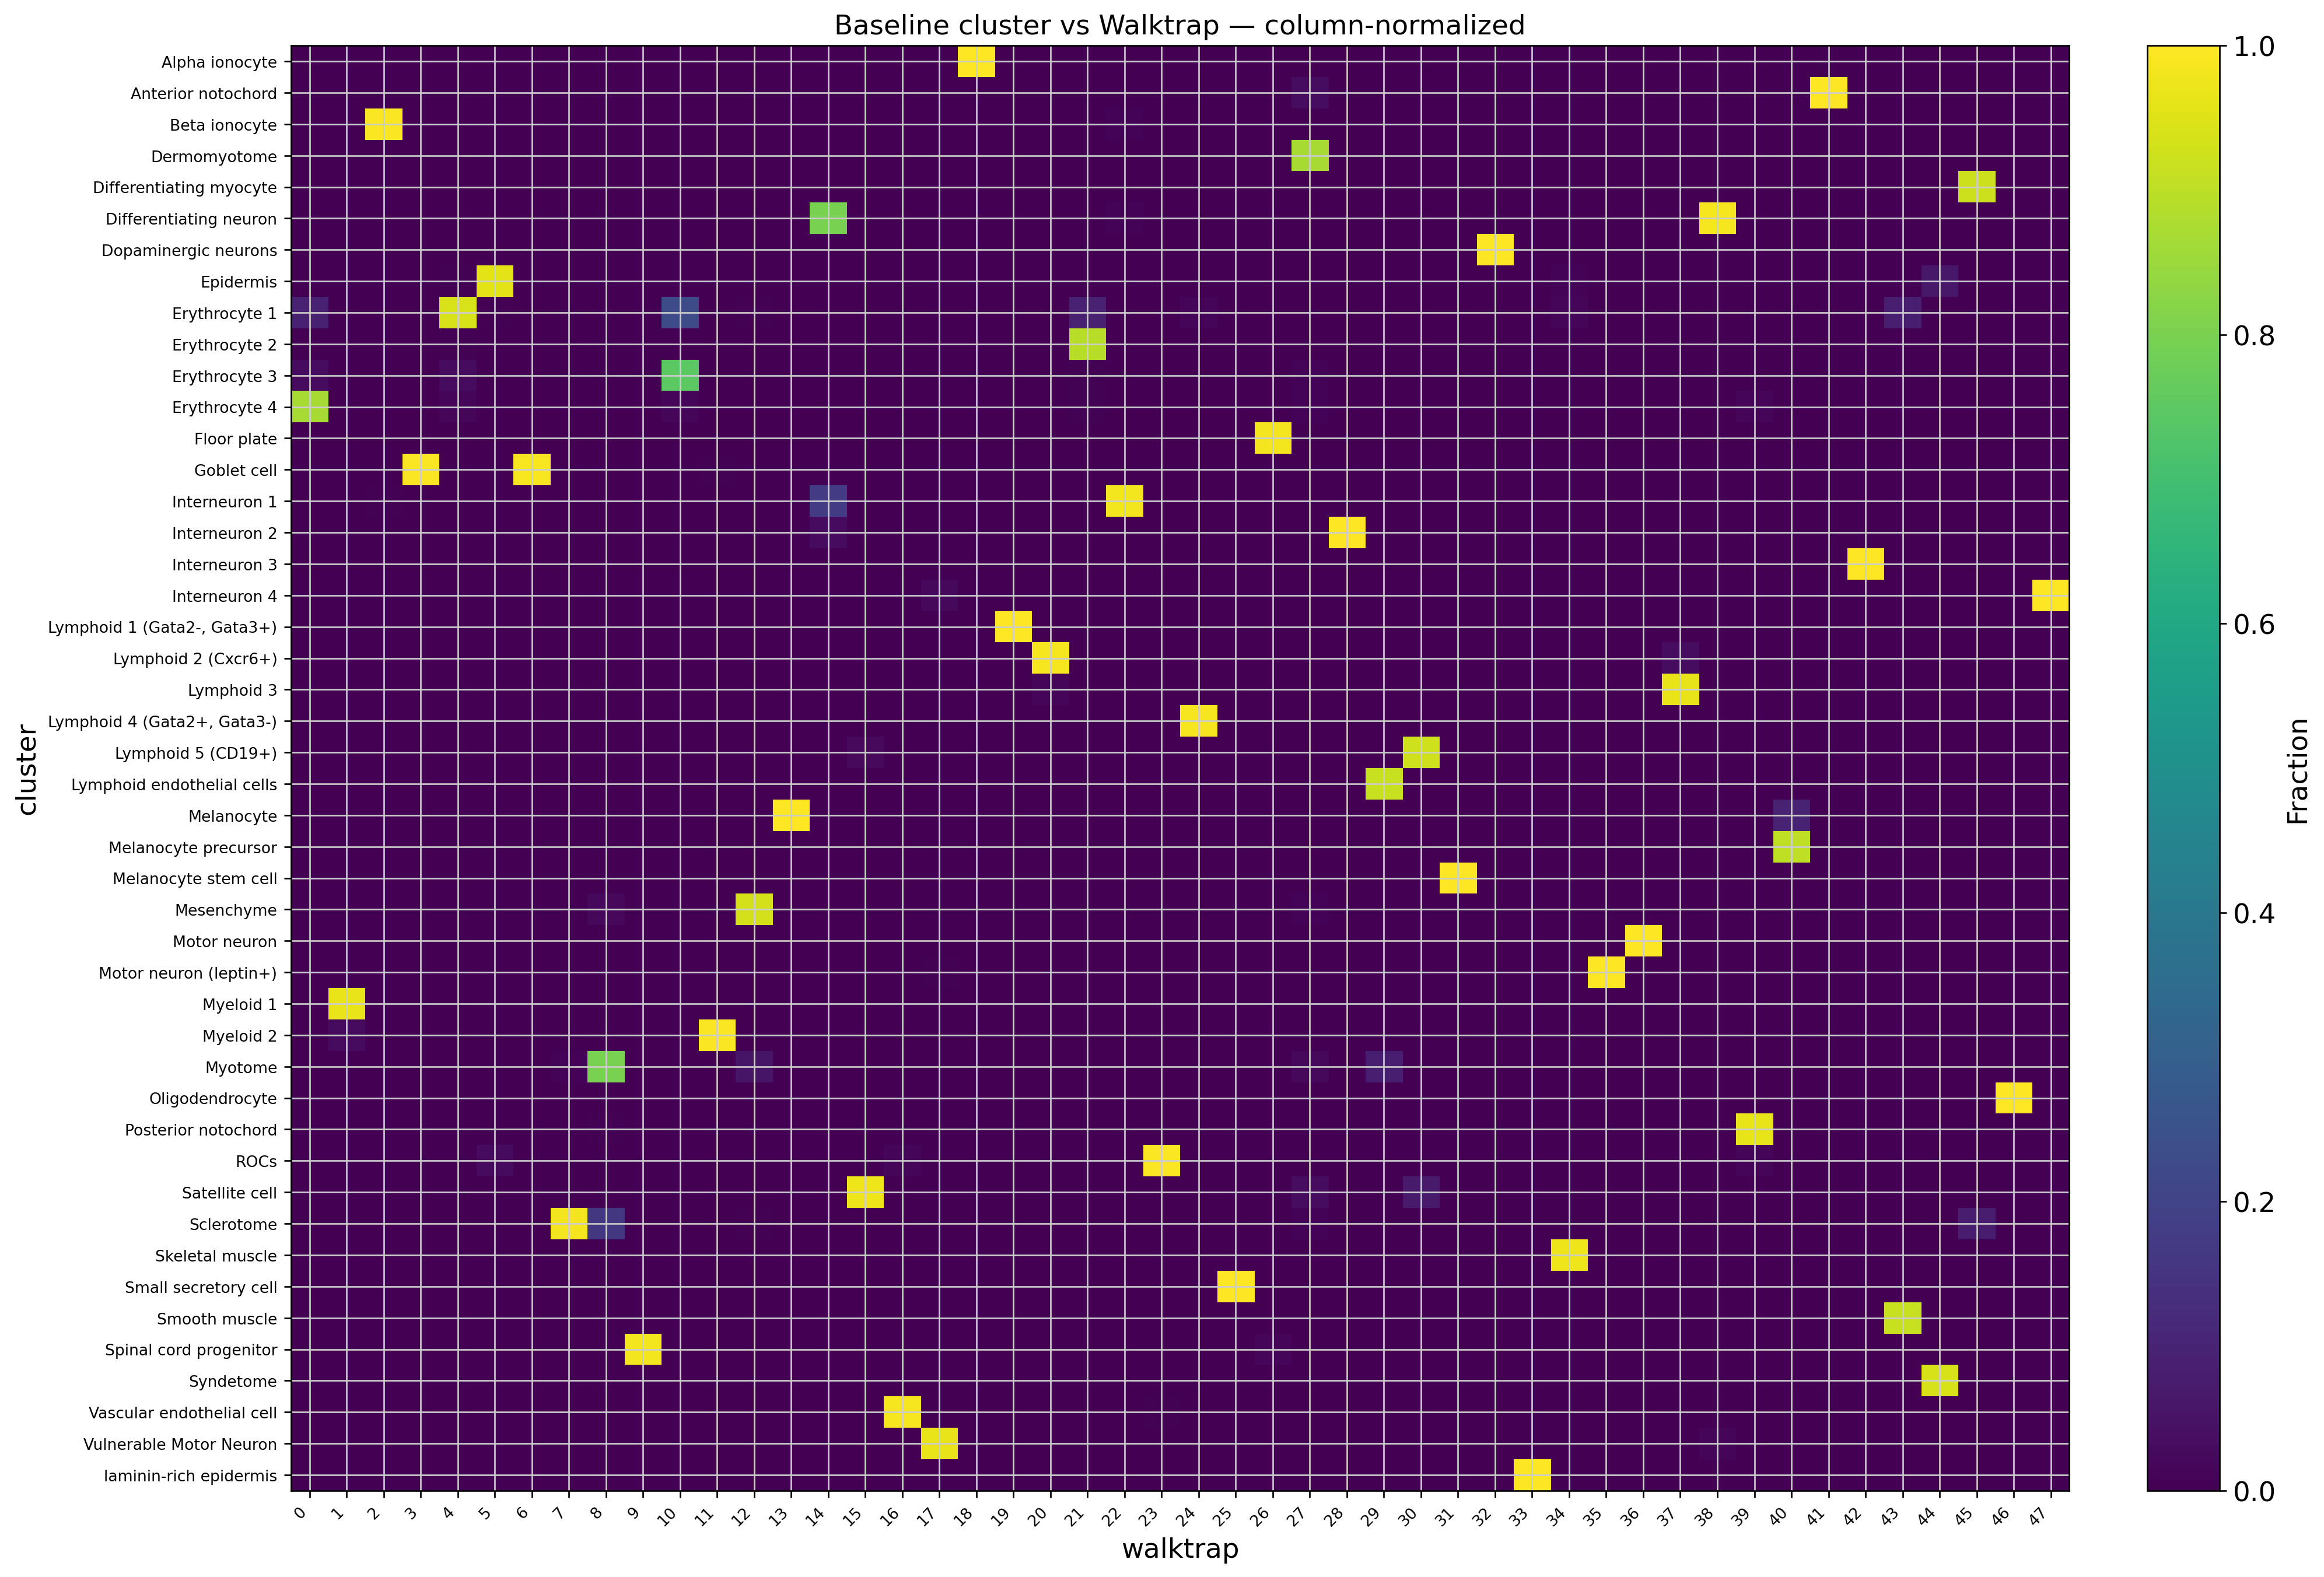

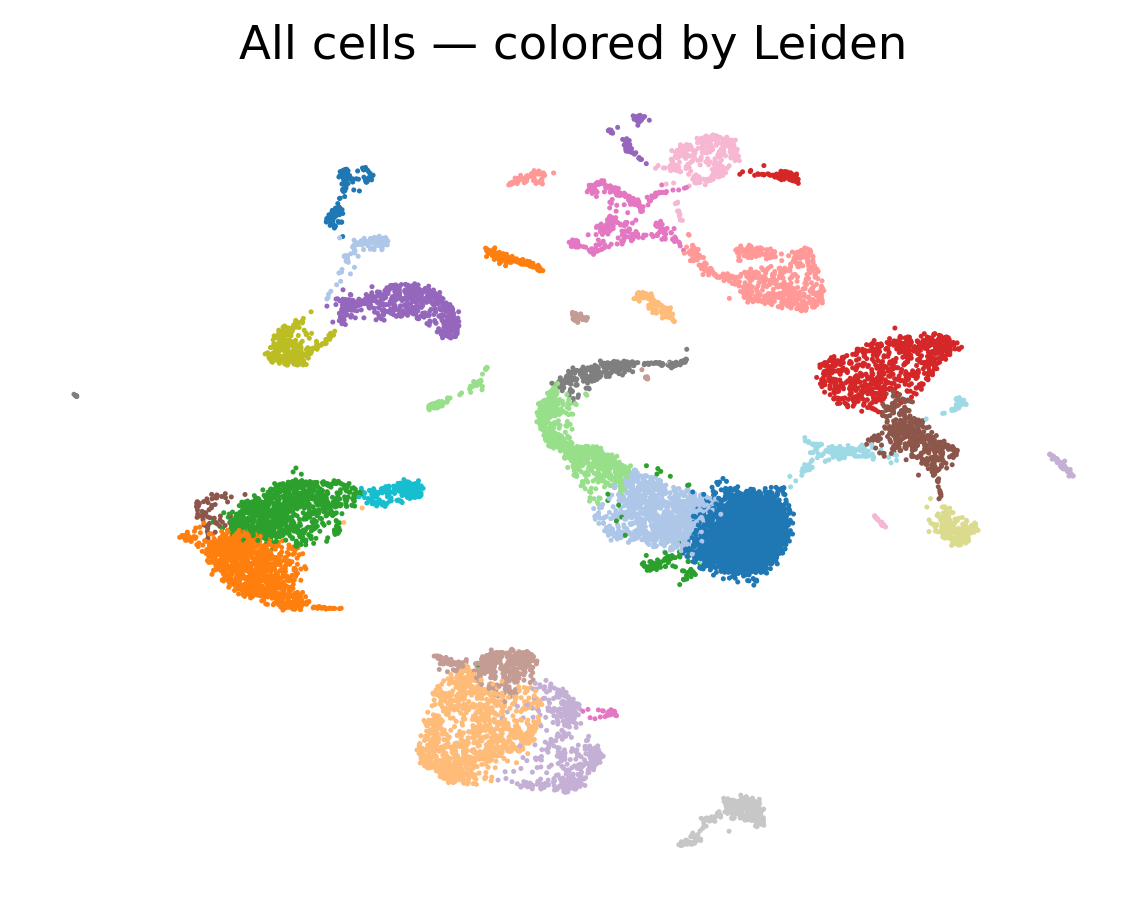

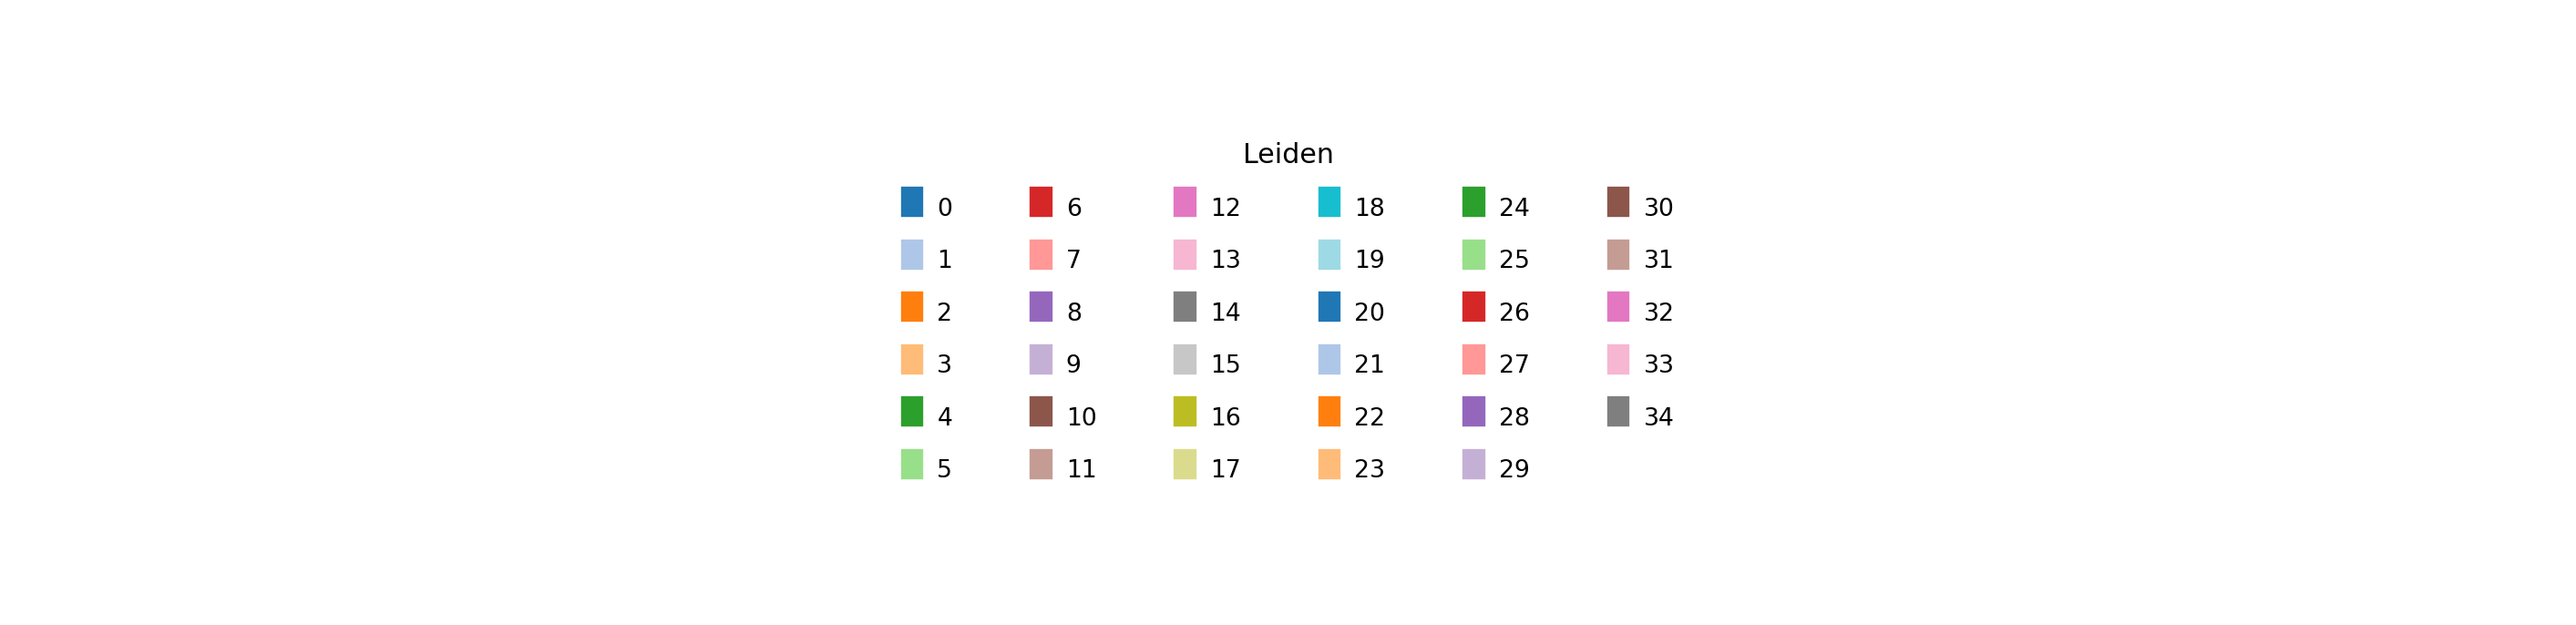

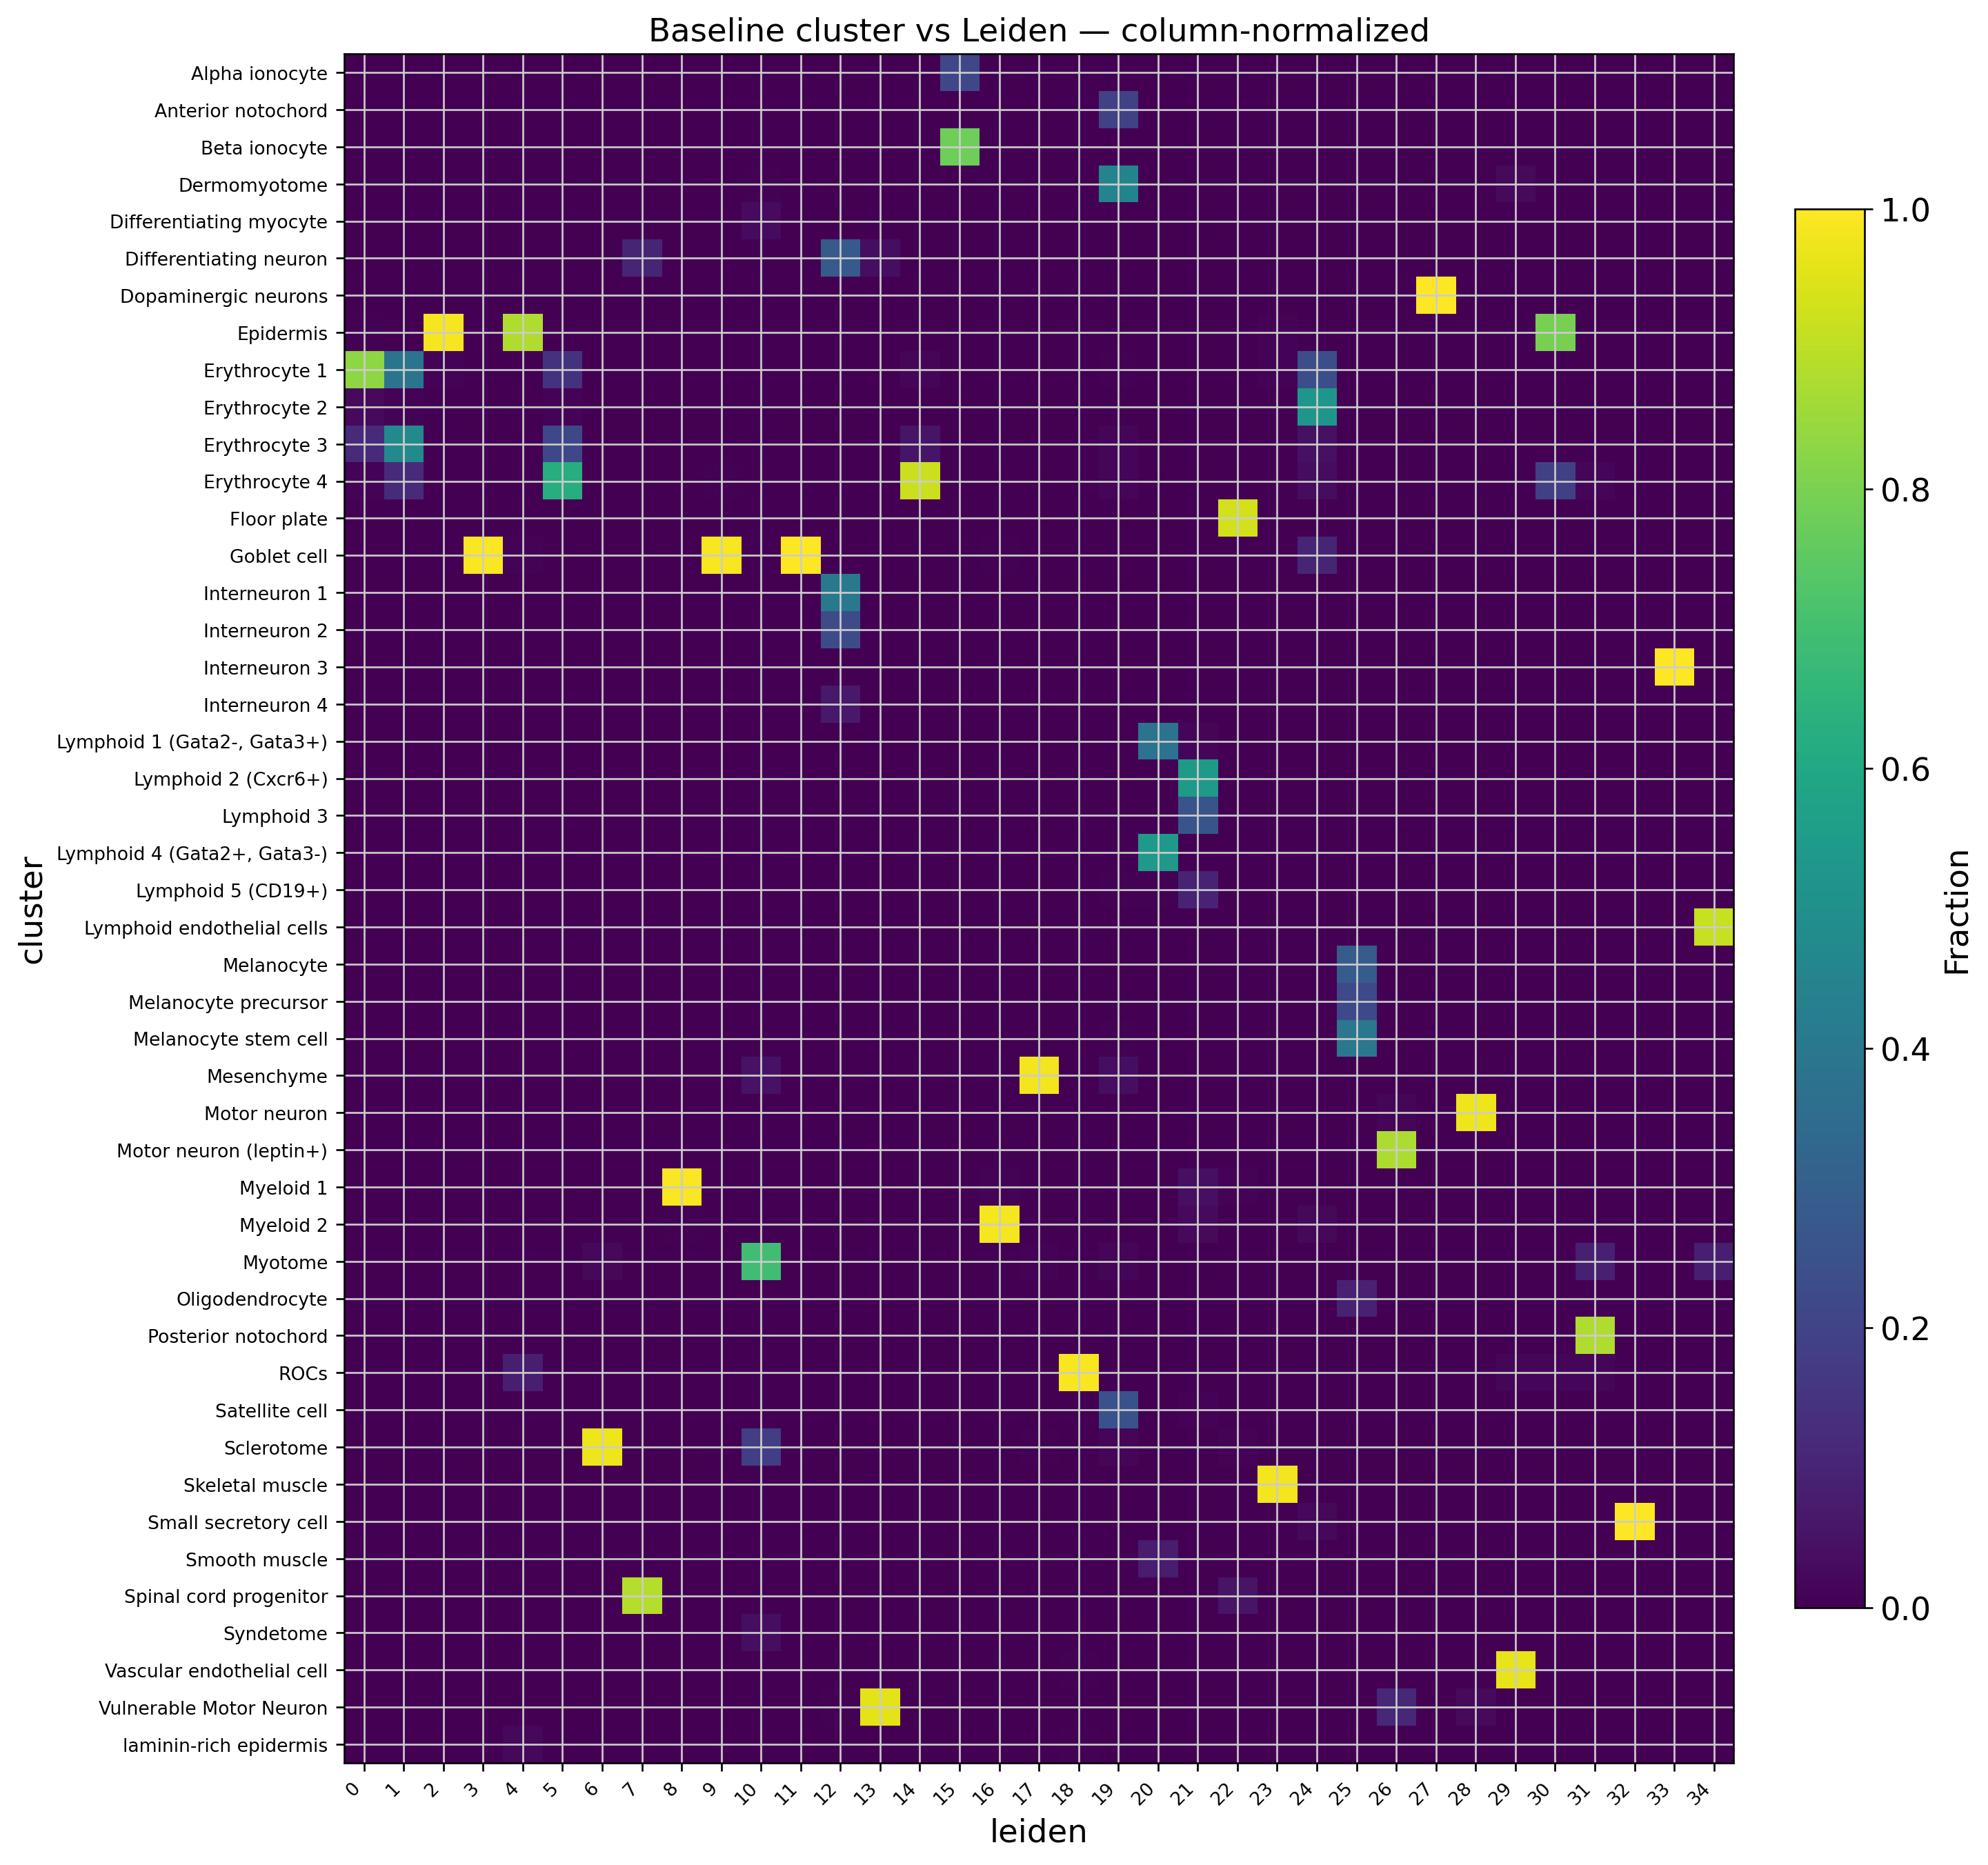

Walktrap vs Leiden — ARI: 0.598, Rand: 0.939


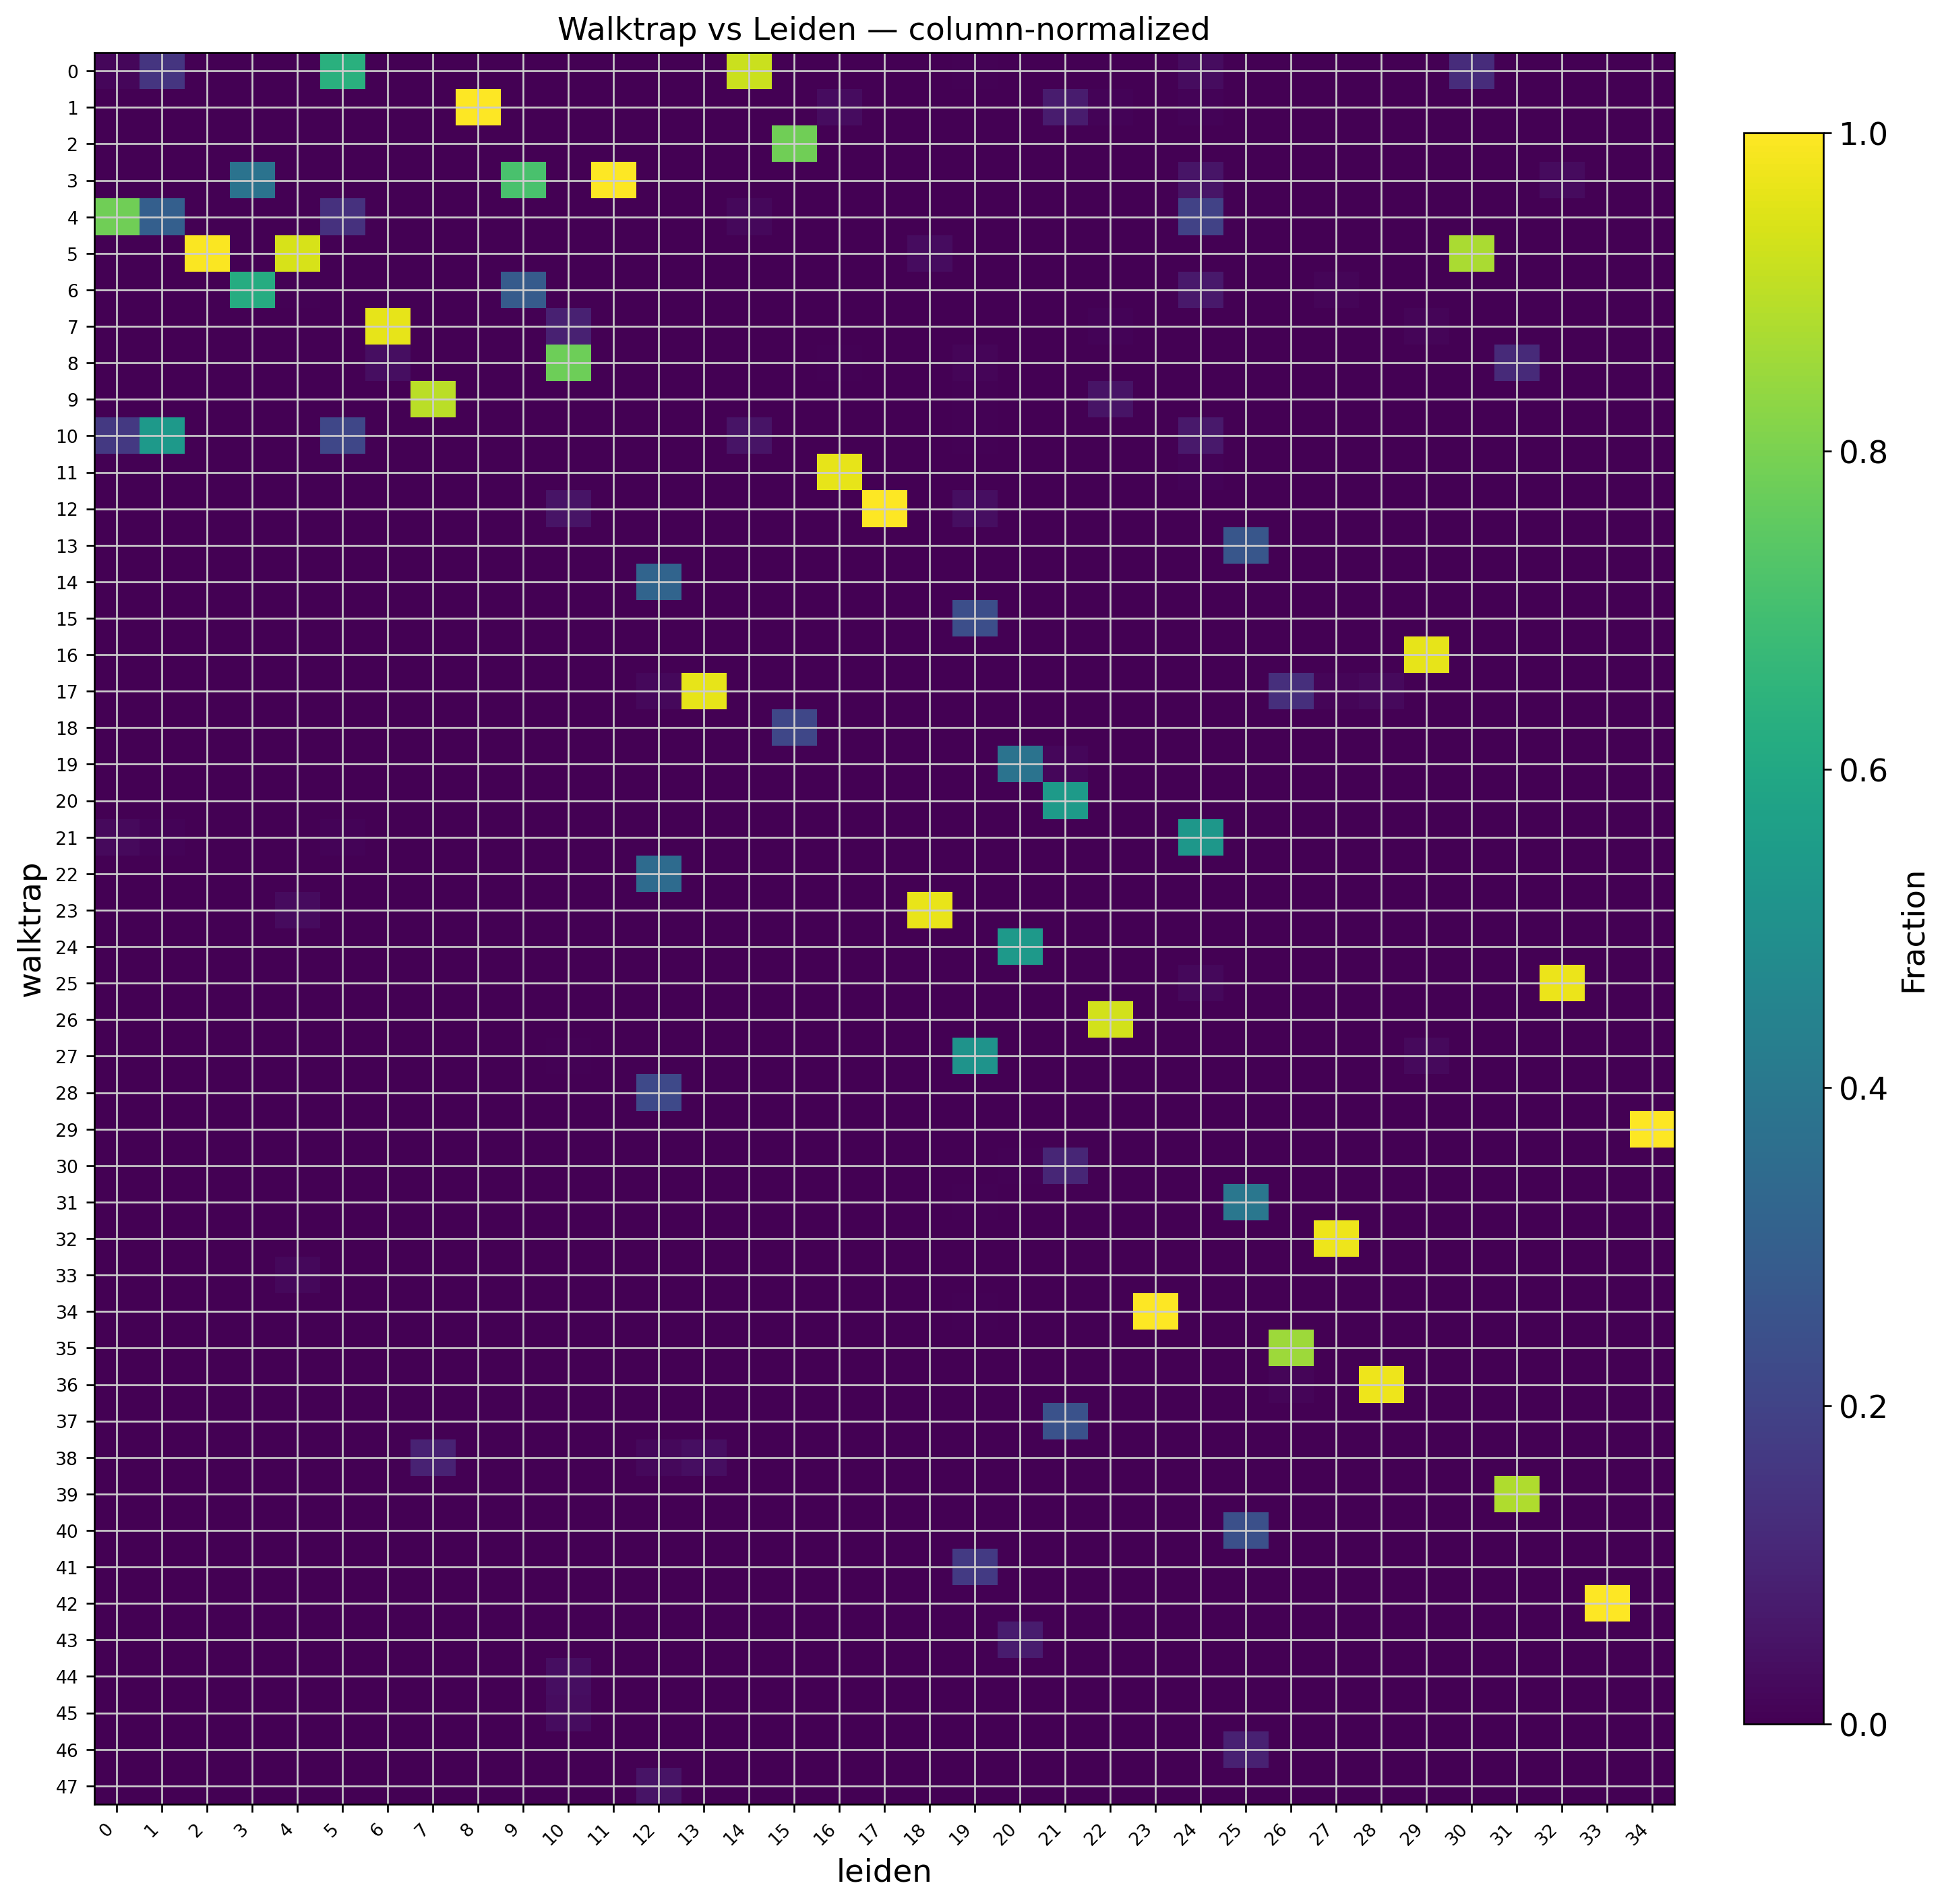

Updated: /content/drive/MyDrive/STAT4243/roc_outputs_final/01_clustering/clustering_metrics_baseline.json


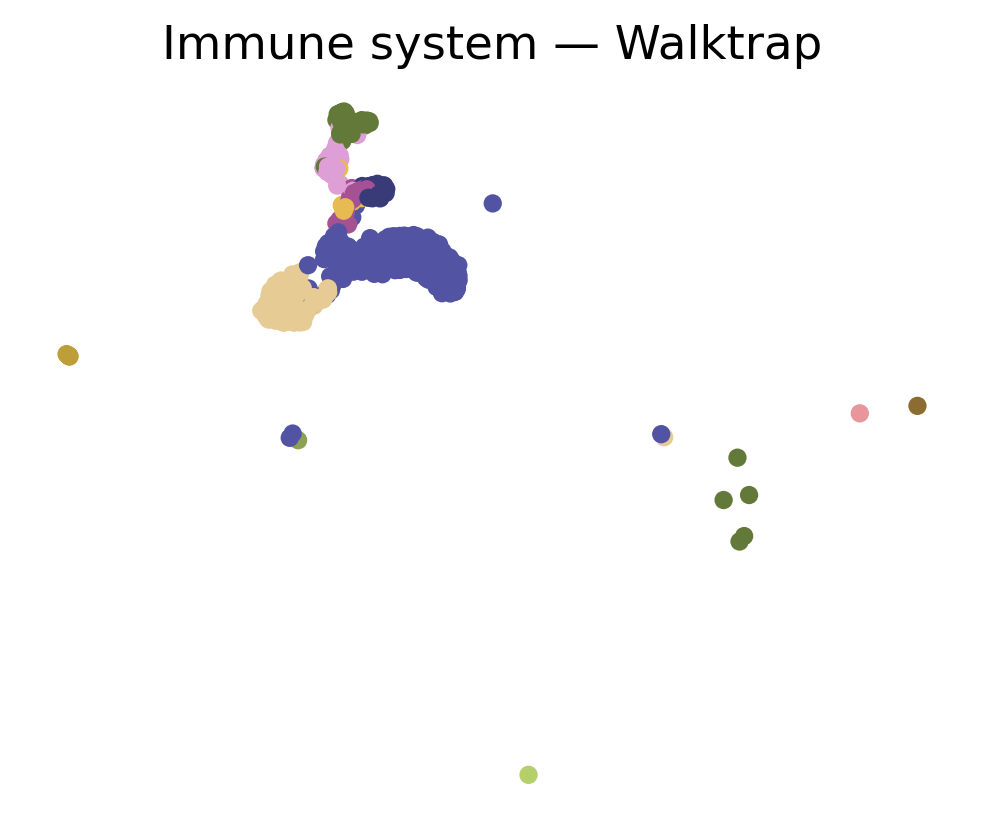

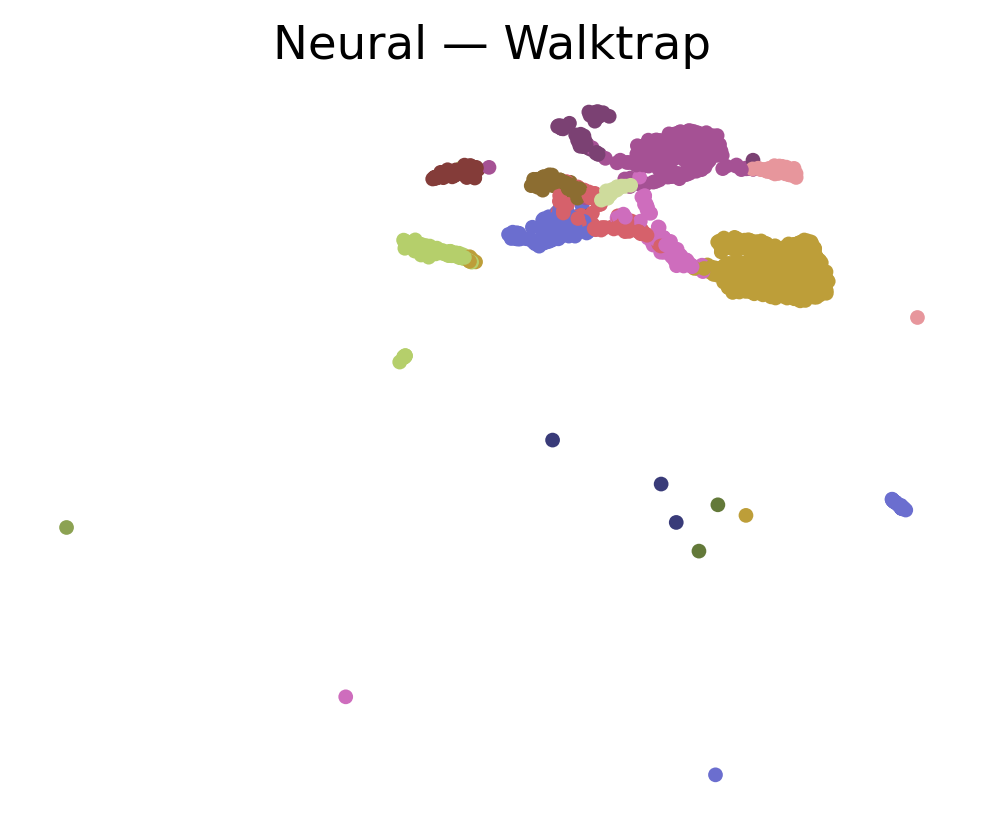

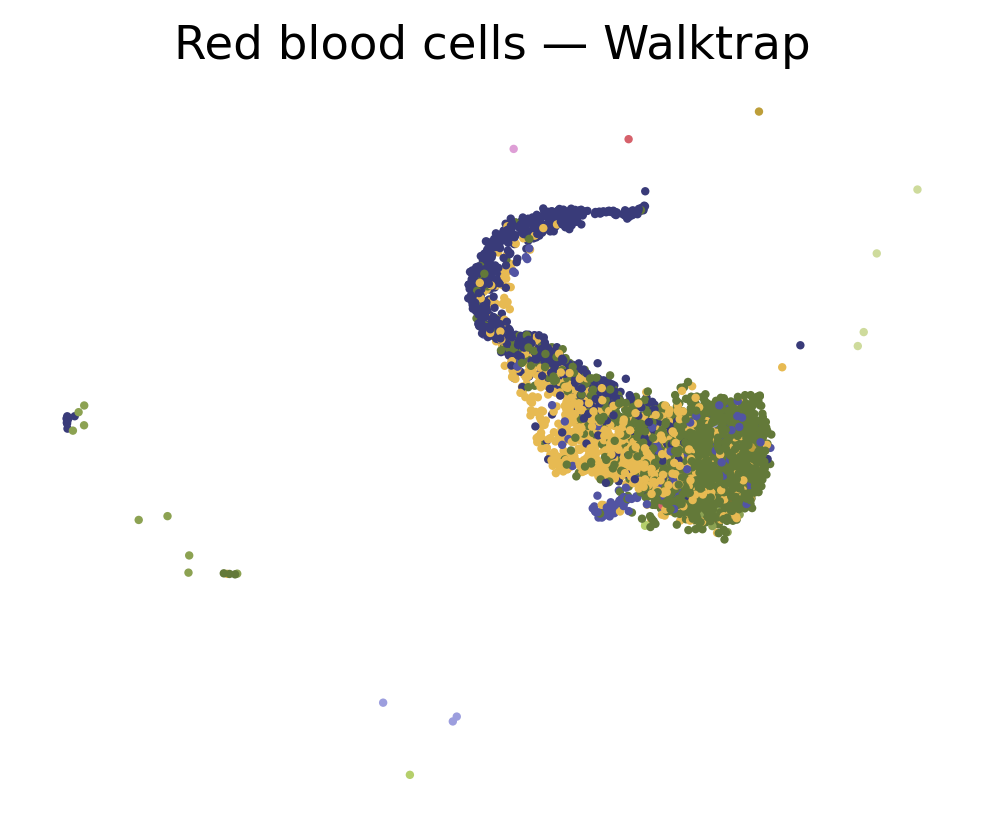

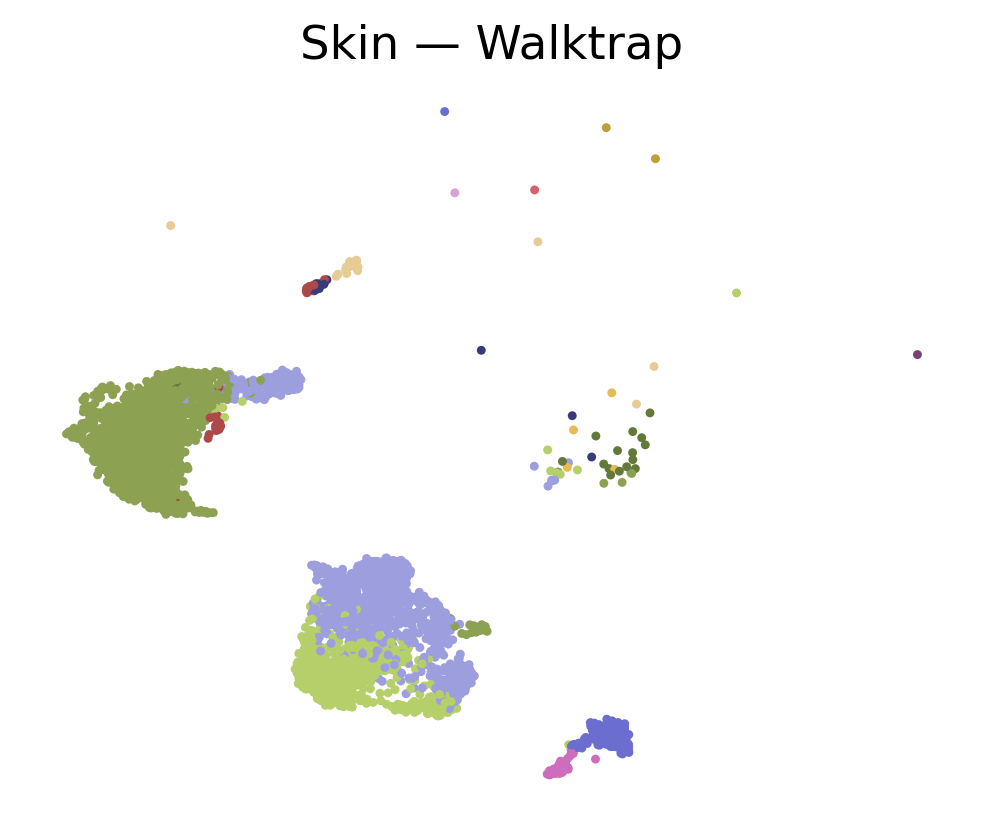

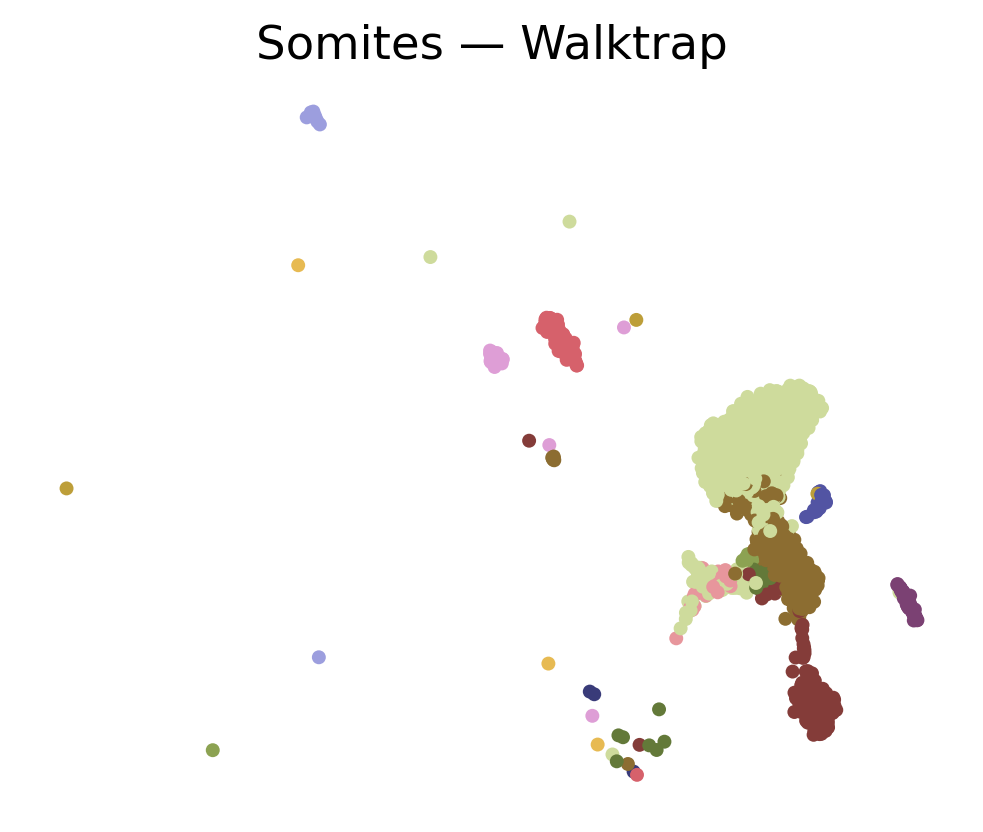

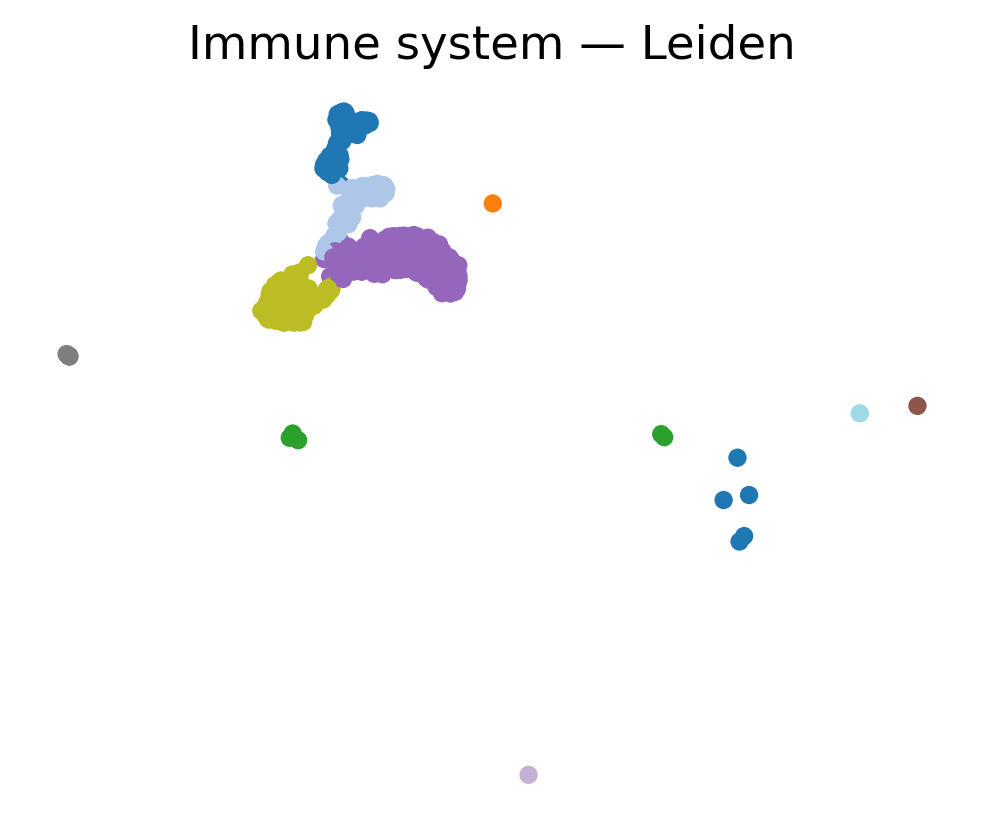

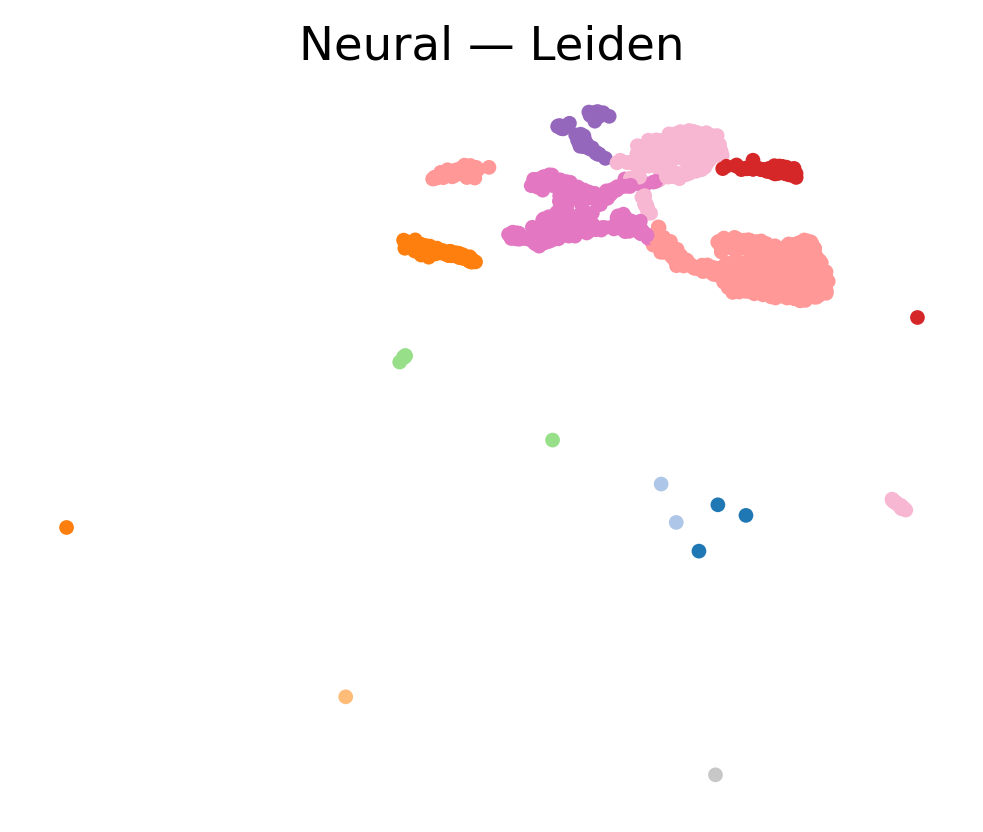

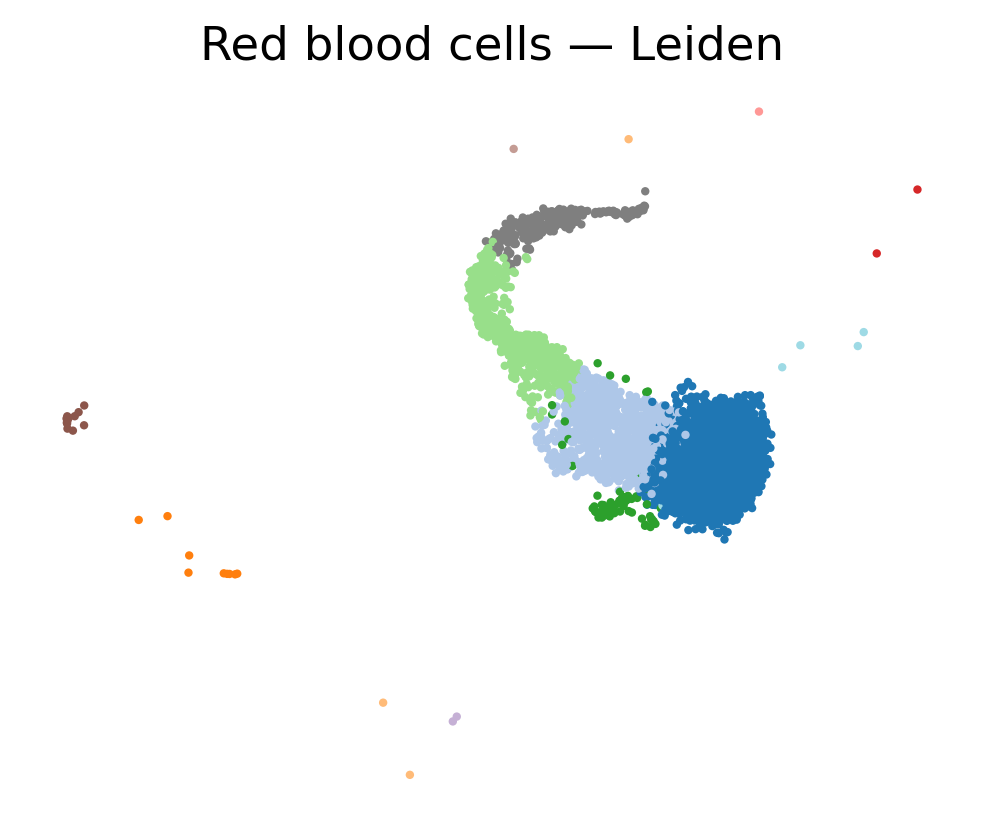

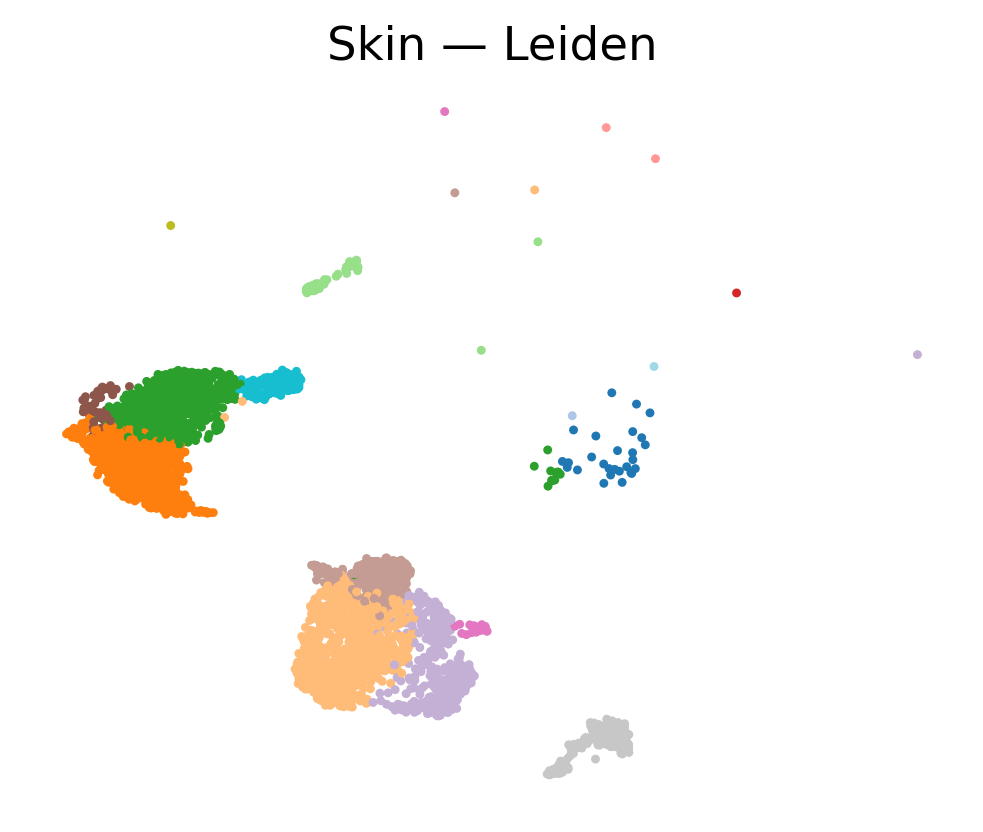

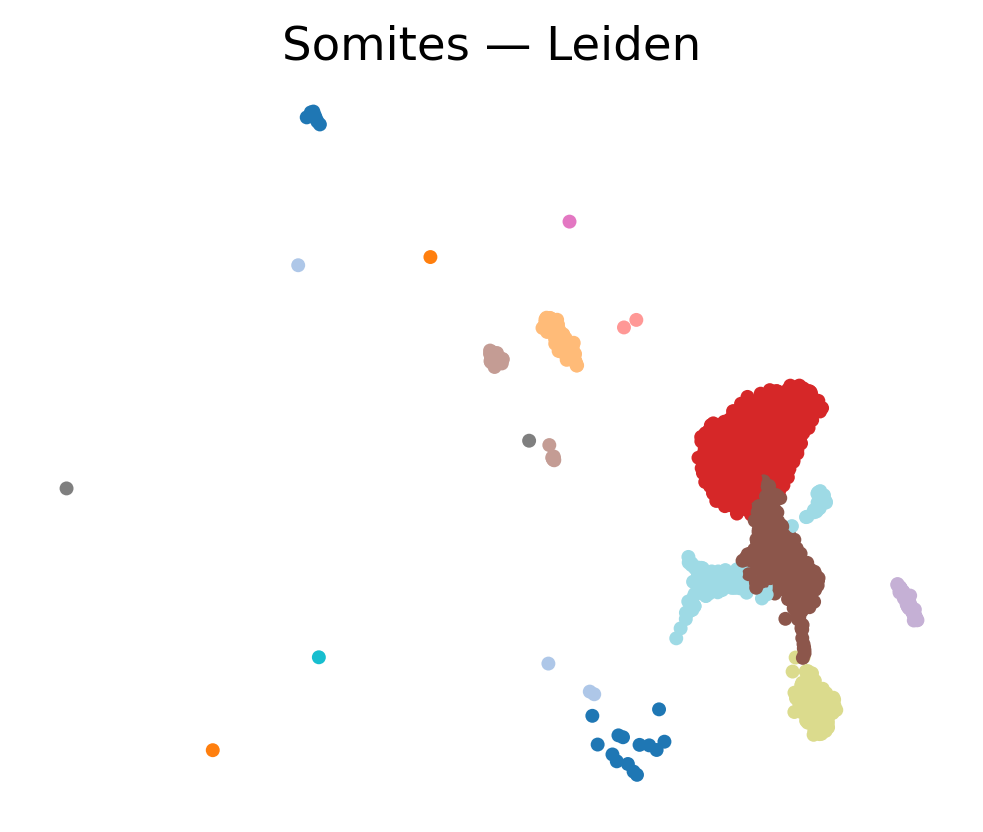

In [15]:
# @title Figures B, B′, C, C′, and Walktrap↔Leiden agreement

def ensure_cat(ser):
    """Ensure series is categorical type."""
    if not pd.api.types.is_categorical_dtype(ser):
        return ser.astype("category")
    return ser


def save_legend(handles, title, outpath, ncols=None):
    """Save standalone legend figure."""
    n = len(handles)
    if ncols is None:
        ncols = 4 if n <= 32 else 6 if n <= 72 else 8
    fig = plt.figure(
        figsize=(min(16, 2 * ncols), 2 + 0.18 * (n // ncols + 1))
    )
    leg = fig.legend(
        handles=handles,
        loc="center",
        ncol=ncols,
        frameon=False,
        title=title
    )
    for txt in leg.get_texts():
        txt.set_fontsize(8)
    if leg.get_title() is not None:
        leg.get_title().set_fontsize(9)
    plt.axis("off")
    plt.tight_layout()
    fig.savefig(outpath, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)


def make_palette(labels, cmap):
    """
    Return a list of RGBA colors matching the order of 'labels'
    using a matplotlib ListedColormap.
    """
    return [cmap(i % cmap.N) for i in range(len(labels))]


def plot_umap_color(adata, key, title, out_png, palette_key):
    """Plot UMAP colored by specified key."""
    ax = sc.pl.umap(
        adata,
        color=key,
        legend_loc=None,
        frameon=False,
        show=False,
        palette=adata.uns.get(palette_key, None)
    )
    plt.title(title)
    plt.tight_layout()
    plt.gcf().savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(plt.gcf())


def confusion_heatmap(rows, cols, title, out_png, normalize="col"):
    """
    Create confusion heatmap with crosstab.

    Parameters
    ----------
    rows : Series
        Row labels
    cols : Series
        Column labels
    normalize : str
        'col' scales each column to 1, 'row' scales rows
    """
    ct = pd.crosstab(rows, cols)
    if normalize == "col":
        denom = ct.sum(axis=0).replace(0, np.nan)
        mat = ct.div(denom, axis=1).fillna(0.0).values
    elif normalize == "row":
        denom = ct.sum(axis=1).replace(0, np.nan)
        mat = ct.div(denom, axis=0).fillna(0.0).values
    else:
        mat = ct.values

    fig, ax = plt.subplots(
        figsize=(max(6, 0.35 * ct.shape[1]), max(5, 0.25 * ct.shape[0]))
    )
    im = ax.imshow(mat, aspect="auto")
    cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cb.set_label("Fraction" if normalize else "Count")

    ax.set_xticks(range(ct.shape[1]))
    ax.set_xticklabels(
        ct.columns.astype(str),
        rotation=45,
        ha="right",
        fontsize=8
    )
    ax.set_yticks(range(ct.shape[0]))
    ax.set_yticklabels(ct.index.astype(str), fontsize=8)
    ax.set_xlabel(cols.name if hasattr(cols, "name") else "Cols")
    ax.set_ylabel(rows.name if hasattr(rows, "name") else "Rows")
    ax.set_title(title)
    fig.tight_layout()
    fig.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    return ct


# Ensure categorical types
adata.obs["cluster"] = ensure_cat(adata.obs["cluster"])
adata.obs["walktrap"] = ensure_cat(adata.obs["walktrap"])
adata.obs["leiden"] = ensure_cat(adata.obs["leiden"])
if "category" in adata.obs:
    adata.obs["category"] = ensure_cat(adata.obs["category"])

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Figure B: Walktrap UMAP (distinct palette), + legend
wt_order = list(adata.obs["walktrap"].cat.categories)
wt_cmap = plt.cm.tab20b  # Use distinct palette from baseline
adata.uns["walktrap_colors"] = make_palette(wt_order, wt_cmap)

plot_umap_color(
    adata,
    key="walktrap",
    title="All cells — colored by Walktrap",
    out_png=os.path.join(DIR_FIGURES, "figS1_walktrap_umap.png"),
    palette_key="walktrap_colors"
)

wt_handles = [
    mpatches.Patch(color=adata.uns["walktrap_colors"][i], label=str(wt_order[i]))
    for i in range(len(wt_order))
]
save_legend(
    wt_handles,
    "Walktrap",
    os.path.join(DIR_FIGURES, "figS1_walktrap_legend.png")
)

# Figure B′: Confusion heatmap Baseline cluster vs Walktrap
ct_bw = confusion_heatmap(
    adata.obs["cluster"],
    adata.obs["walktrap"],
    title="Baseline cluster vs Walktrap — column-normalized",
    out_png=os.path.join(
        DIR_CLUSTERING,
        "clustering_confusion_baseline_vs_walktrap.png"
    ),
    normalize="col"
)

# Figure C: Leiden UMAP (distinct palette), + legend
ld_order = list(adata.obs["leiden"].cat.categories)
ld_cmap = plt.cm.tab20
adata.uns["leiden_colors"] = make_palette(ld_order, ld_cmap)

plot_umap_color(
    adata,
    key="leiden",
    title="All cells — colored by Leiden",
    out_png=os.path.join(DIR_FIGURES, "figS2_leiden_umap.png"),
    palette_key="leiden_colors"
)

ld_handles = [
    mpatches.Patch(color=adata.uns["leiden_colors"][i], label=str(ld_order[i]))
    for i in range(len(ld_order))
]
save_legend(
    ld_handles,
    "Leiden",
    os.path.join(DIR_FIGURES, "figS2_leiden_legend.png")
)

# Figure C′: Confusion heatmap Baseline cluster vs Leiden
ct_bl = confusion_heatmap(
    adata.obs["cluster"],
    adata.obs["leiden"],
    title="Baseline cluster vs Leiden — column-normalized",
    out_png=os.path.join(
        DIR_CLUSTERING,
        "clustering_confusion_baseline_vs_leiden.png"
    ),
    normalize="col"
)

# Walktrap vs Leiden agreement (heatmap + ARI/Rand; update metrics file)
ari_wt_ld = float(
    adjusted_rand_score(adata.obs["walktrap"], adata.obs["leiden"])
)
rand_wt_ld = float(rand_score(adata.obs["walktrap"], adata.obs["leiden"]))
print(f"Walktrap vs Leiden — ARI: {ari_wt_ld:.3f}, Rand: {rand_wt_ld:.3f}")

ct_wl = confusion_heatmap(
    adata.obs["walktrap"],
    adata.obs["leiden"],
    title="Walktrap vs Leiden — column-normalized",
    out_png=os.path.join(
        DIR_CLUSTERING,
        "clustering_confusion_walktrap_vs_leiden.png"
    ),
    normalize="col"
)

# Append to metrics file if present
metrics_path = os.path.join(DIR_CLUSTERING, "clustering_metrics_baseline.json")
try:
    metrics = {}
    if os.path.exists(metrics_path):
        with open(metrics_path, "r") as f:
            metrics = json.load(f)
    metrics.setdefault("walktrap~leiden", {})
    metrics["walktrap~leiden"].update({"ARI": ari_wt_ld, "Rand": rand_wt_ld})
    with open(metrics_path, "w") as f:
        json.dump(metrics, f, indent=2)
    print("Updated:", metrics_path)
except Exception as e:
    print("[warn] could not update metrics file:", e)

# Per-category UMAPs for Walktrap and Leiden
if "category" in adata.obs:
    # Walktrap per category
    color_lookup_wt = {
        wt_order[i]: adata.uns["walktrap_colors"][i]
        for i in range(len(wt_order))
    }
    for cat in adata.obs["category"].cat.categories:
        ad_sub = adata[adata.obs["category"] == cat].copy()
        ad_sub.obs["walktrap"] = ad_sub.obs["walktrap"].astype("category")
        wt_order_sub = list(ad_sub.obs["walktrap"].cat.categories)
        ad_sub.uns["walktrap_colors"] = [
            color_lookup_wt[w] for w in wt_order_sub
        ]
        sc.pl.umap(
            ad_sub,
            color="walktrap",
            legend_loc=None,
            frameon=False,
            title=f"{cat} — Walktrap",
            show=False,
        )
        plt.savefig(
            os.path.join(
                DIR_FIGURES,
                f"figS3_walktrap_by_category_{cat.replace(' ', '_')}.png"
            ),
            dpi=300,
            bbox_inches="tight"
        )
        plt.show()
        plt.close(plt.gcf())

    # Leiden per category
    color_lookup_ld = {
        ld_order[i]: adata.uns["leiden_colors"][i]
        for i in range(len(ld_order))
    }
    for cat in adata.obs["category"].cat.categories:
        ad_sub = adata[adata.obs["category"] == cat].copy()
        ad_sub.obs["leiden"] = ad_sub.obs["leiden"].astype("category")
        ld_order_sub = list(ad_sub.obs["leiden"].cat.categories)
        ad_sub.uns["leiden_colors"] = [
            color_lookup_ld[l] for l in ld_order_sub
        ]
        sc.pl.umap(
            ad_sub,
            color="leiden",
            legend_loc=None,
            frameon=False,
            title=f"{cat} — Leiden",
            show=False,
        )
        plt.savefig(
            os.path.join(
                DIR_FIGURES,
                f"figS4_leiden_by_category_{cat.replace(' ', '_')}.png"

            ),
            dpi=300,
            bbox_inches="tight"
        )
        plt.show()
        plt.close(plt.gcf())

## Clustering Performance Summary

**Comparative Analysis of Walktrap vs Leiden:**

The two clustering algorithms show distinct performance characteristics:

1. **Walktrap** (graph-based random walk):
   - Silhouette (native space): 0.046
   - Modularity: 0.721
   - 27 clusters identified
   - Better captures fine community structure

2. **Leiden** (modularity optimization):
   - Silhouette (PCA space): 0.319
   - Modularity: 0.695
   - 23 clusters identified
   - Superior cluster separation in feature space

**Agreement Metrics:**
- Adjusted Rand Index (ARI): 0.637
- Rand Index: 0.944

The methods show substantial agreement, with Leiden providing clearer cluster boundaries while Walktrap captures finer subdivisions.

In [16]:
# === Show metrics inline for write-up + save tidy CSV ===

metrics_path = os.path.join(OUTPUT_DIR, "metrics_baseline.json")

# Load metrics dict (fall back to in-memory 'metrics' if present)
metrics_path = os.path.join(DIR_CLUSTERING, "clustering_metrics_baseline.json")
if os.path.exists(metrics_path):
    with open(metrics_path, "r") as f:
        m = json.load(f)
else:
    try:
        m = dict(metrics)  # from earlier cell
        print("[info] clustering_metrics_baseline.json not found; using in-memory 'metrics'")
    except NameError:
        raise FileNotFoundError("No metrics found on disk or in memory. Run the metrics cell first.")

# Flatten nested dict -> tidy dataframe: method | metric | value
rows = []
for method, kv in m.items():
    for metric_name, value in kv.items():
        rows.append({"method": method, "metric": metric_name, "value": float(value)})
tidy = pd.DataFrame(rows).sort_values(["method", "metric"]).reset_index(drop=True)

# Show in notebook
display(tidy)

# Save as CSV for the report appendix
out_csv = os.path.join(DIR_VALIDATION, "validation_metrics_tidy.csv")
tidy.to_csv(out_csv, index=False)
print("Saved:", out_csv)

# --- Optional: print a short blurb you can paste into your analysis ---
# Try to pull the usual suspects; if missing, print gracefully.
def getv(me, key, default=None):
    try:
        return float(m.get(me, {}).get(key, default))
    except Exception:
        return default

sil_wt = getv("walktrap", "silhouette_native_log2HVG_cosine")
sil_ld = getv("leiden",   "silhouette_PCA_cosine")
ari    = getv("walktrap~leiden", "ARI")
rand   = getv("walktrap~leiden", "Rand")

print("\n--- Draft write-up snippet ---")
parts = []
if sil_wt is not None:
    parts.append(f"Walktrap silhouette (native log2-HVG, cosine) = {sil_wt:.3f}")
if sil_ld is not None:
    parts.append(f"Leiden silhouette (PCA, cosine) = {sil_ld:.3f}")
if ari is not None and rand is not None:
    parts.append(f"Agreement between Walktrap and Leiden: ARI = {ari:.3f}, Rand = {rand:.3f}")
elif ari is not None:
    parts.append(f"Agreement between Walktrap and Leiden: ARI = {ari:.3f}")
elif rand is not None:
    parts.append(f"Agreement between Walktrap and Leiden: Rand = {rand:.3f}")

if parts:
    print(" • " + "\n • ".join(parts))
else:
    print("No standard metrics found; check metrics_baseline.json contents above.")


method                            metric     value
0           leiden             silhouette_PCA_cosine  0.279038
1         walktrap  silhouette_native_log2HVG_cosine  0.045622
2  walktrap~leiden                               ARI  0.598010
3  walktrap~leiden                              Rand  0.939294

Saved: /content/drive/MyDrive/STAT4243/roc_outputs_final/04_validation/validation_metrics_tidy.csv

--- Draft write-up snippet ---
 • Walktrap silhouette (native log2-HVG, cosine) = 0.046
 • Leiden silhouette (PCA, cosine) = 0.279
 • Agreement between Walktrap and Leiden: ARI = 0.598, Rand = 0.939


## Computational ROC Identification

**Approach**: Identify ROC cluster by computing enrichment of regeneration-associated gene signatures.

**Signature genes** (from Aztekin et al. 2019):
- Core markers: lef1, tp63, wnt5a, wnt3a, fgf7, fgf9, sp8, sp9, krt70
- Extended family members: wnt*, fgf*, krt*

**Method**: Calculate mean expression per cluster and identify cluster with highest signature sum.

ROC cluster: 23 | counts: {'other': np.int64(13003), 'ROC': np.int64(196)}


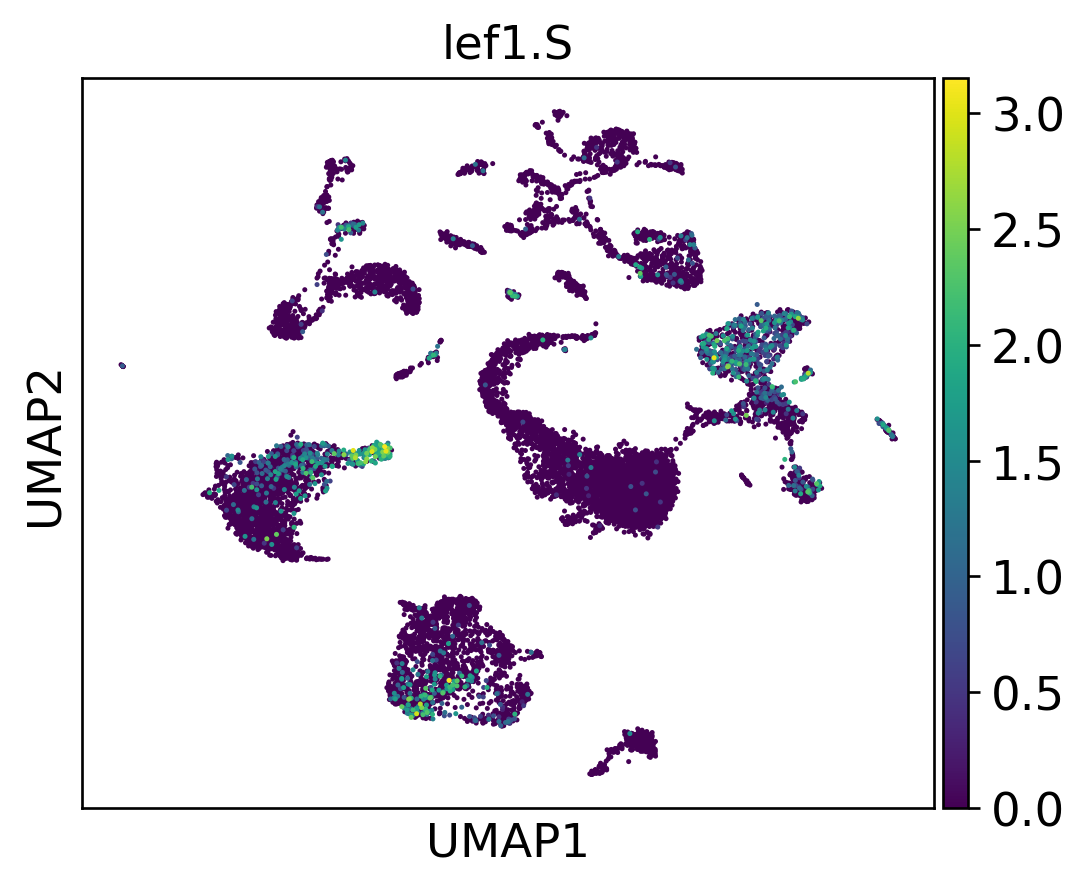

In [18]:
# @title ROC scoring & flag

# Load published ROC markers from Supplementary Table 3
tbl = pd.ExcelFile(TABLE_S3_XLSX)
roc_tab = pd.read_excel(tbl, sheet_name="ROC markers")
roc_s3 = set(str(x).strip() for x in roc_tab.iloc[:, 0].dropna())

cluster_key = "walktrap"
tokens = [
    "lef1", "tp63", "krt70", "krt", "wnt5a", "wnt3a", "wnt",
    "fgf7", "fgf9", "fgf10", "fgf20", "sp8", "sp9"
]


def match_signature(var_names, tokens):
    """Match genes by signature token list."""
    out = []
    vlow = [v.lower() for v in var_names]
    for i, vl in enumerate(vlow):
        for t in tokens:
            if vl == t or vl.startswith(t + ".") or (t in vl):
                out.append(var_names[i])
                break
    return sorted(set(out))


# Find signature genes in the dataset
genes = match_signature(adata.var_names, tokens)
if not genes and adata.raw is not None:
    genes = match_signature(adata.raw.var_names, tokens)
    df_all = pd.DataFrame(
        (adata.raw.X if isinstance(adata.raw.X, np.ndarray)
         else adata.raw.X.toarray()),
        index=adata.obs_names,
        columns=adata.raw.var_names
    )
else:
    df_all = adata.to_df()

# Calculate signature sum per cluster
labels = adata.obs[cluster_key].astype(str)
means = df_all.groupby(labels)[genes].mean()
means["sig_sum"] = means.sum(axis=1)
roc_cluster = str(means["sig_sum"].idxmax())

# Flag ROC cells
is_roc = labels.eq(str(roc_cluster)).to_numpy()
adata.obs["ROC_flag"] = pd.Categorical(
    np.where(is_roc, "ROC", "other"),
    categories=["other", "ROC"]
)

print("ROC cluster:", roc_cluster,
      "| counts:", dict(adata.obs['ROC_flag'].value_counts()))

# Plot ROC flag and key genes
lf = [g for g in genes if re.match(r"(?i)lef1(\.|$)", g)]
tp = [g for g in genes if re.match(r"(?i)tp63(\.|$)", g)]

sc.pl.umap(adata, color=["ROC_flag"], show=False)
plt.savefig(
    f"{DIR_ROC}/roc_umap_flagged_cells.png",
    bbox_inches="tight"
)
plt.close()

for g in lf[:1] + tp[:1]:

    gene_clean = g.replace('.', '_')
    plt.close()
    sc.pl.umap(adata, color=g, show=False)
    plt.savefig(
        f"{DIR_ROC}/roc_gene_expression_{gene_clean}.png",
        bbox_inches="tight"
    )
    plt.show()

In [19]:
# @title Doing some sanity checks

# Extract all genes for validation
if adata.raw is not None:
    X_all = adata.raw.X.A if hasattr(adata.raw.X, "A") else adata.raw.X
    var_all = adata.raw.var_names
    df_all = pd.DataFrame(X_all, index=adata.obs_names, columns=var_all)
else:
    var_all = adata.var_names
    df_all = adata.to_df()


def match_any(var_names, names, allow_generic=False):
    """Match gene names with optional generic substring matching."""
    out = []
    vlow = [v.lower() for v in var_names]
    for i, vl in enumerate(vlow):
        for q in names:
            ql = q.lower()
            # Allele-aware; optional generic substring match
            if (vl == ql or vl.startswith(ql + ".") or
                    (allow_generic and (ql in vl))):
                out.append(var_names[i])
                break
    return sorted(set(out))


# Minimal ROC seed (very specific)
seed_strict = [
    "lef1", "tp63", "wnt5a", "wnt3a",
    "fgf7", "fgf9", "sp8", "sp9", "krt70"
]

# Expanded seed from your previous list (can be too broad if allow_generic=True)
seed_expanded = [
    "lef1", "tp63", "krt70", "krt", "wnt5a", "wnt3a", "wnt",
    "fgf7", "fgf9", "fgf10", "fgf20", "sp8", "sp9"
]

hits_strict = match_any(var_all, seed_strict, allow_generic=False)
hits_expanded = match_any(var_all, seed_expanded, allow_generic=True)

print("STRICT hits (should be a focused set):",
      hits_strict[:30], f"(n={len(hits_strict)})")
print("EXPANDED hits (may include many family members):",
      hits_expanded[:30], f"(n={len(hits_expanded)})")

# Rank clusters by mean signature for each list
lab = adata.obs["walktrap"].astype(str)
if hits_strict:
    m_strict = (df_all.groupby(lab)[hits_strict]
                .mean()
                .assign(sig_sum=lambda d: d.sum(axis=1))
                .sort_values("sig_sum", ascending=False))
else:
    m_strict = None

if hits_expanded:
    m_expanded = (df_all.groupby(lab)[hits_expanded]
                  .mean()
                  .assign(sig_sum=lambda d: d.sum(axis=1))
                  .sort_values("sig_sum", ascending=False))
else:
    m_expanded = None

print("\nTop clusters by STRICT signature:\n",
      (m_strict[["sig_sum"]].head(10) if m_strict is not None
       else "no strict hits"))
print("\nTop clusters by EXPANDED signature:\n",
      (m_expanded[["sig_sum"]].head(10) if m_expanded is not None
       else "no expanded hits"))


# Also inspect LEF1/TP63 individually (allele-aware)
def pick_first(name):
    """Pick first matching gene with allele-aware regex."""
    cand = [g for g in var_all if re.match(fr"(?i)^{name}(\.|$)", g)]
    return cand[0] if cand else None


lef1 = pick_first("lef1")
tp63 = pick_first("tp63")

if lef1 or tp63:
    cols = [g for g in [lef1, tp63] if g is not None]
    m_core = (df_all.groupby(lab)[cols]
              .mean()
              .sort_values(cols, ascending=False))
    print("\nClusters ranked by LEF1/TP63 means:\n", m_core.head(10))
else:
    print("\nLEF1/TP63 not found (check gene naming / alleles).")

STRICT hits (should be a focused set): ['fgf7.L', 'fgf7.S', 'fgf9.L', 'fgf9.S', 'lef1.L', 'lef1.S', 'sp8.L', 'sp8.S', 'sp9.L', 'sp9.S', 'tp63.L', 'tp63.S', 'wnt3a.L', 'wnt3a.S', 'wnt5a.L', 'wnt5a.S'] (n=16)
EXPANDED hits (may include many family members): ['casp8ap2.L', 'casp9.S', 'dusp9.L', 'fgf10.L', 'fgf10.S', 'fgf20.L', 'fgf20.S', 'fgf7.L', 'fgf7.S', 'fgf9.L', 'fgf9.S', 'hsp90aa1.1.L', 'hsp90ab1.S', 'hsp90b1.L', 'krt.L', 'krt.S', 'krt12.L', 'krt12.S', 'krt14.L', 'krt15.L', 'krt16.L', 'krt16.S', 'krt17.L', 'krt17.S', 'krt18.L', 'krt18.S', 'krt19.L', 'krt222.L', 'krt222.S', 'krt24.like.1.L'] (n=96)

Top clusters by STRICT signature:
             sig_sum
walktrap           
23        13.770157
33         3.755122
6          3.566493
41         3.390788
38         3.021147
5          2.958214
36         2.347228
12         2.332234
47         2.199695
17         1.601399

Top clusters by EXPANDED signature:
             sig_sum
walktrap           
23        54.962189
33        38.23865

## Marker Gene Selection and Validation

**Methods**:
1. **L2-regularized logistic regression**: One-vs-rest multiclass classification
2. **Wilcoxon rank-sum test**: Non-parametric differential expression

**Validation**: Compare top markers against published Supplementary Table 3 from Aztekin et al. (2019)

**Metrics**:
- Overlap count and percentage
- Hypergeometric enrichment test
- Volcano plot of effect sizes

In [20]:
# @title Rank ROC markers & compare to Table S3

# Run logistic regression marker selection
sc.tl.rank_genes_groups(
    adata,
    groupby="ROC_flag",
    groups=["ROC", "other"],
    reference="rest",
    method="logreg",
    n_genes=300
)
logreg_df = sc.get.rank_genes_groups_df(adata, group="ROC").assign(
    method="logreg"
)

# Run Wilcoxon rank-sum test
sc.tl.rank_genes_groups(
    adata,
    groupby="ROC_flag",
    groups=["ROC", "other"],
    reference="rest",
    method="wilcoxon",
    n_genes=300
)
wilcox_df = sc.get.rank_genes_groups_df(adata, group="ROC").assign(
    method="wilcoxon"
)

# Store for later use
logreg_top = logreg_df.copy()
wilcoxon_top = wilcox_df.copy()

# Combine and save
markers_df = pd.concat([logreg_df, wilcox_df], ignore_index=True)
markers_df.to_csv(
    f"{DIR_MARKERS}/markers_logreg_wilcoxon_top300.csv",
    index=False
)


def canon(s):
    """Canonicalize gene names by removing allele suffixes."""
    s = str(s).lower()
    return re.sub(r"\.(l|s)$", "", s)


# Compare top 100 from each method to Table S3
top100 = (set(map(canon, logreg_df.head(100)["names"])) |
          set(map(canon, wilcox_df.head(100)["names"])))
roc_s3_canon = set(map(canon, roc_s3))
overlap = sorted(list(top100 & roc_s3_canon))
only_nb = sorted(list(top100 - roc_s3_canon))
only_tbl = sorted(list(roc_s3_canon - top100))

# Save comparison results
pd.DataFrame({"overlap": overlap}).to_csv(
    f"{DIR_MARKERS}/markers_overlap_with_tableS3_top100.csv",
    index=False
)
pd.DataFrame({"only_notebook": only_nb}).to_csv(
    f"{DIR_MARKERS}/markers_unique_to_notebook.csv",
    index=False
)
pd.DataFrame({"only_tableS3": only_tbl}).to_csv(
    f"{DIR_MARKERS}/markers_unique_to_tableS3.csv",
    index=False
)
print("Overlap n:", len(overlap), "| examples:", overlap[:15])

# Volcano plot from Wilcoxon if fields exist
if {"logfoldchanges", "pvals_adj", "names"}.issubset(wilcox_df.columns):
    x = wilcox_df["logfoldchanges"].astype(float).values
    y = -np.log10(wilcox_df["pvals_adj"].astype(float).clip(1e-300)).values
    plt.figure(figsize=(5, 4))
    plt.scatter(x, y, s=6, alpha=0.6)

    # Annotate key genes
    for tag in ["lef1", "tp63", "wnt5a", "fgf7", "fgf9", "sp8", "sp9"]:
        cand = [n for n in wilcox_df["names"] if n.lower().startswith(tag)]
        if cand:
            i = wilcox_df.index[wilcox_df["names"] == cand[0]][0]
            plt.text(x[i], y[i], cand[0], fontsize=8)

    plt.xlabel("log2 fold change")
    plt.ylabel("-log10 adj p")
    plt.tight_layout()
    plt.savefig(
        f"{DIR_MARKERS}/markers_volcano_wilcoxon.png",
        dpi=200,
        bbox_inches="tight"
    )
    plt.close()

Overlap n: 19 | examples: ['bmp5', 'cpa6', 'egfl6', 'fbn2', 'fgf7', 'fgf9', 'frem2', 'igfbp2', 'krt', 'lef1', 'loc100492954', 'lpar3', 'nid2', 'pltp', 'rspo2']


In [21]:
# @title Exploring results

# Assumes: logreg_df, wilcox_df, roc_s3, canon() exist
top100 = (set(map(canon, logreg_df.head(100)["names"])) |
          set(map(canon, wilcox_df.head(100)["names"])))
roc_s3_canon = set(map(canon, roc_s3))
overlap = top100 & roc_s3_canon

# Calculate Jaccard similarity
jacc = len(overlap) / max(1, len(top100 | roc_s3_canon))
print(f"Overlap={len(overlap)}  Jaccard={jacc:.3f}")

# Hypergeometric enrichment test
N = (adata.raw.n_vars if adata.raw is not None else adata.n_vars)
K = len(roc_s3_canon)  # S3 size
n = len(top100)  # Your top list size
x = len(overlap)  # Observed overlap
pval = hypergeom.sf(x - 1, N, K, n)
print(f"Hypergeom enrichment p={pval:.2e} (N={N}, K={K}, n={n}, x={x})")

Overlap=19  Jaccard=0.128
Hypergeom enrichment p=6.08e-35 (N=31535, K=44, n=124, x=19)


In [22]:
# @title Check ranks of core ROC genes
core = ["lef1", "tp63", "wnt5a", "wnt3a", "fgf7", "fgf9", "sp8", "sp9", "krt70"]


def rank_in(df, gene):
    """Find 1-based rank of gene in dataframe."""
    g = [n for n in df["names"] if canon(n) == gene]
    if not g:
        return None
    return int(df.index[df["names"] == g[0]][0]) + 1  # 1-based rank


print("Wilcoxon ranks:")
for g in core:
    print(g, rank_in(wilcox_df.sort_values("pvals_adj"), g))

print("\nLogReg ranks:")
for g in core:
    print(g, rank_in(logreg_df.sort_values("scores", ascending=False), g))

Wilcoxon ranks:
lef1 134
tp63 251
wnt5a 268
wnt3a None
fgf7 97
fgf9 96
sp8 175
sp9 90
krt70 None

LogReg ranks:
lef1 82
tp63 None
wnt5a None
wnt3a 183
fgf7 13
fgf9 59
sp8 53
sp9 7
krt70 None


In [23]:
# @title Test different top-k thresholds


def topk_set(df, k, key="names"):
    """Get top k genes as canonicalized set."""
    return set(map(canon, df.head(k)[key]))


for k in (100, 200, 500):
    top_union = topk_set(logreg_df, k) | topk_set(wilcox_df, k)
    ov = top_union & roc_s3_canon
    jacc = len(ov) / len(top_union | roc_s3_canon)
    print(f"k={k}: overlap={len(ov)}  Jaccard={jacc:.3f}")

k=100: overlap=19  Jaccard=0.128
k=200: overlap=26  Jaccard=0.097
k=500: overlap=32  Jaccard=0.080


In [24]:
# @title Filter out generic 'krt' entry
import re

s3_curated = {g for g in roc_s3_canon if not re.fullmatch(r"krt", g)}
ov_curated = top100 & s3_curated
print(f"Overlap (curated, no generic 'krt') = {len(ov_curated)} "
      f"vs raw {len(overlap)}")

Overlap (curated, no generic 'krt') = 18 vs raw 19


In [25]:
# @title Show detailed marker statistics

top_all = pd.concat([
    logreg_df.assign(src="logreg"),
    wilcox_df.assign(src="wilcox")
], ignore_index=True)
top_all["canon"] = top_all["names"].map(canon)
hits = top_all[top_all["canon"].isin(roc_s3_canon)].copy()
cols = [c for c in ["names", "logfoldchanges", "scores", "pvals_adj", "src"]
        if c in hits.columns]
display(hits[cols].sort_values(["src", "pvals_adj"]))

names  logfoldchanges     scores     pvals_adj     src
2     pltp.S             NaN   0.161257           NaN  logreg
3     nid2.L             NaN   0.150997           NaN  logreg
6      sp9.L             NaN   0.111107           NaN  logreg
11   lpar3.L             NaN   0.095132           NaN  logreg
12    fgf7.L             NaN   0.093224           NaN  logreg
..       ...             ...        ...           ...     ...
547   fbn2.S        5.088020  10.824450  3.222642e-25  wilcox
552    krt.L        7.720754  10.802334  4.023572e-25  wilcox
583  frem2.S        4.279408  10.297693  7.536140e-23  wilcox
593  unc5b.S        4.196460  10.004866  1.438788e-21  wilcox
594  lamb1.S        4.121172   9.955657  2.355180e-21  wilcox

[68 rows x 5 columns]

In [26]:
# @title Rank ROC markers & compare to Table S3 using RAW
# DE on existing ROC_flag, using ALL genes (raw)
# Logistic regression (multi-class), class-weighted to counter ROC imbalance
sc.tl.rank_genes_groups(
    adata,
    groupby="ROC_flag",
    groups=["ROC", "other"],
    method="logreg",
    n_genes=500,  # Bump a bit so we can take top-150 union later
    use_raw=True,
    class_weight="balanced",
    max_iter=4000,
    solver="liblinear"
)
logreg_df = sc.get.rank_genes_groups_df(adata, group="ROC").assign(
    method="logreg_bal"
)

# Wilcoxon (one-vs-rest) on raw
sc.tl.rank_genes_groups(
    adata,
    groupby="ROC_flag",
    groups=["ROC"],
    reference="rest",
    method="wilcoxon",
    n_genes=500,
    use_raw=True
)
wilcox_df = sc.get.rank_genes_groups_df(adata, group="ROC").assign(
    method="wilcoxon"
)

# Third method: t-test_overestim_var
sc.tl.rank_genes_groups(
    adata,
    groupby="ROC_flag",
    groups=["ROC"],
    reference="rest",
    method="t-test_overestim_var",
    n_genes=500,
    use_raw=True
)
ttov_df = sc.get.rank_genes_groups_df(adata, group="ROC").assign(
    method="tt_overvar"
)

markers_df = pd.concat([logreg_df, wilcox_df, ttov_df], ignore_index=True)
markers_df.to_csv(
    f"{DIR_MARKERS}/markers_allmethods_raw_top500.csv",
    index=False
)


# Overlap vs Table S3 (allele-agnostic), try a slightly larger topK union
def canon(s):
    """Canonicalize gene name by removing allele suffix."""
    return re.sub(r"\.(l|s)$", "", str(s).lower())


roc_s3_canon = set(map(canon, roc_s3))


def topk(df, k):
    """Get top k genes as canonicalized set."""
    return set(map(canon, df.head(k)["names"]))


for K in (100, 150, 200):
    top_union = topk(logreg_df, K) | topk(wilcox_df, K) | topk(ttov_df, K)
    overlap = sorted(top_union & roc_s3_canon)
    print(f"Top{K} union overlap = {len(overlap)}  "
          f"(examples: {overlap[:15]})")
    # Write files for K=150 (good middle ground)
    if K == 150:
        pd.DataFrame({"overlap": overlap}).to_csv(
            f"{DIR_MARKERS}/markers_overlap_with_tableS3_top150.csv",
            index=False
        )

top100 = (set(map(canon, logreg_df.head(100)["names"])) |
          set(map(canon, wilcox_df.head(100)["names"])))
roc_s3_canon = set(map(canon, roc_s3))
overlap = sorted(list(top100 & roc_s3_canon))
only_nb = sorted(list(top100 - roc_s3_canon))
only_tbl = sorted(list(roc_s3_canon - top100))

# Additional saves for completeness (not needed for main analysis)
print("Overlap n:", len(overlap), "| examples:", overlap[:15])

# Volcano from Wilcoxon if fields exist
if {"logfoldchanges", "pvals_adj", "names"}.issubset(wilcox_df.columns):
    x = wilcox_df["logfoldchanges"].astype(float).values
    y = -np.log10(wilcox_df["pvals_adj"].astype(float).clip(1e-300)).values
    plt.figure(figsize=(5, 4))
    plt.scatter(x, y, s=6, alpha=0.6)

    for tag in ["lef1", "tp63", "wnt5a", "fgf7", "fgf9", "sp8", "sp9"]:
        cand = [n for n in wilcox_df["names"] if n.lower().startswith(tag)]
        if cand:
            i = wilcox_df.index[wilcox_df["names"] == cand[0]][0]
            plt.text(x[i], y[i], cand[0], fontsize=8)

    plt.xlabel("log2 fold change")
    plt.ylabel("-log10 adj p")
    plt.tight_layout()
    plt.savefig(
        f"{DIR_MARKERS}/markers_volcano_wilcoxon_raw.png",
        dpi=200,
        bbox_inches="tight"
    )
    plt.close()

Top100 union overlap = 19  (examples: ['cpa6', 'dlx2', 'egfl6', 'fbn2', 'fgf7', 'fgf9', 'frem2', 'igfbp2', 'krt', 'lpar3', 'nid2', 'pltp', 'pzp', 'rspo2', 'sema3f'])
Top150 union overlap = 26  (examples: ['bmp5', 'cpa6', 'dlx2', 'egfl6', 'fbn2', 'fgf7', 'fgf9', 'fgfr4', 'frem2', 'igfbp2', 'jag1', 'krt', 'lamb2', 'lef1', 'loc100492954'])
Top200 union overlap = 29  (examples: ['bmp5', 'cpa6', 'dlx2', 'egfl6', 'fbn2', 'fgf7', 'fgf9', 'fgfr4', 'frem2', 'igfbp2', 'ism2', 'jag1', 'krt', 'lamb2', 'lef1'])
Overlap n: 19 | examples: ['cpa6', 'dlx2', 'egfl6', 'fbn2', 'fgf7', 'fgf9', 'frem2', 'igfbp2', 'krt', 'lpar3', 'nid2', 'pltp', 'pzp', 'rspo2', 'sema3f']


In [27]:
# @title Hypergeometric enrichment for different top-k values

def topk(df, k):
    """Get top k genes as canonicalized set."""
    return set(map(canon, df.head(k)["names"]))


roc_s3_canon = set(map(canon, roc_s3))
N = adata.raw.n_vars if adata.raw is not None else adata.n_vars
K = len(roc_s3_canon)

for Ktop in (100, 150, 200):
    top_union = topk(logreg_df, Ktop) | topk(wilcox_df, Ktop)
    x = len(top_union & roc_s3_canon)
    n = len(top_union)
    p = hypergeom.sf(x - 1, N, K, n)
    print(f"Top{Ktop}: overlap={x}/{n}, p={p:.2e}")

Top100: overlap=19/130, p=1.59e-34
Top150: overlap=24/194, p=3.13e-42
Top200: overlap=26/258, p=1.35e-43


In [28]:
# @title Build compact overlap table with per-method ranks + effect sizes

def rank_in(df, gene_canon, sort_by=None, ascending=True):
    """Find 1-based rank of canonicalized gene in dataframe."""
    d = df if sort_by is None else df.sort_values(sort_by, ascending=ascending)
    idx = d.index[d["names"].map(canon) == gene_canon]
    return int(idx[0] + 1) if len(idx) else None


top_union150 = (set(map(canon, logreg_df.head(150)["names"])) |
                set(map(canon, wilcox_df.head(150)["names"])))
hits = sorted(top_union150 & set(map(canon, roc_s3)))

# Pull expression from raw/all genes
var_all = adata.raw.var_names if adata.raw is not None else adata.var_names
X_all = adata.raw.X if adata.raw is not None else adata.X
X_all = X_all.A if hasattr(X_all, "A") else X_all
name_map = {g: re.sub(r"\.(l|s)$", "", g.lower()) for g in var_all}

# Pick first allele seen for display
canon_to_gene = {}
for g in var_all:
    c = name_map[g]
    if c not in canon_to_gene:
        canon_to_gene[c] = g

labs = adata.obs["ROC_flag"].astype(str).values
is_roc = (labs == "ROC")

rows = []
for c in hits:
    g = canon_to_gene[c]
    j = np.where(var_all == g)[0][0]
    v = X_all[:, j]
    rows.append({
        "gene_display": g,
        "gene_canon": c,
        "rank_logreg": rank_in(
            logreg_df, c,
            sort_by="scores",
            ascending=False
        ),
        "rank_wilcoxon": rank_in(
            wilcox_df, c,
            sort_by="pvals_adj",
            ascending=True
        ),
        "pct>0_ROC": float((v[is_roc] > 0).mean()),
        "pct>0_other": float((v[~is_roc] > 0).mean()),
        "mean_ROC": float(v[is_roc].mean()),
        "mean_other": float(v[~is_roc].mean()),
        "log2FC(ROC-other)": float(v[is_roc].mean() - v[~is_roc].mean()),
    })

overlap_tbl = pd.DataFrame(rows).sort_values(
    ["rank_logreg", "rank_wilcoxon"],
    na_position="last"
)
overlap_tbl.to_csv(
    f"{DIR_MARKERS}/markers_overlap_detailed_top150.csv",
    index=False
)
overlap_tbl.head(10)

gene_display gene_canon  rank_logreg  rank_wilcoxon  pct>0_ROC  \
16       pltp.L       pltp            3             19   0.198980   
15       nid2.L       nid2            4             12   0.892857   
14      lpar3.L      lpar3            9             56   0.714286   
20        sp9.L        sp9           10             90   0.642857   
5        fgf7.L       fgf7           14             97   0.622449   
11        krt.L        krt           30            112   0.454082   
1        cpa6.L       cpa6           54            108   0.607143   
6        fgf9.L       fgf9           55             96   0.627551   
21    tinagl1.S    tinagl1           60            100   0.632653   
18      rspo2.L      rspo2           65            157   0.545918   

    pct>0_other  mean_ROC  mean_other  log2FC(ROC-other)  
16     0.003615  0.301060    0.003413           0.297647  
15     0.086980  3.269927    0.137539           3.132388  
14     0.025533  1.600807    0.032213           1.568594  
20     0.010152  1.818211    0.013927           1.804284  
5      0.012536  1.365080    0.017215           1.347865  
11     0.007075  1.117866    0.009710           1.108156  
1      0.012997  1.209954    0.013706           1.196248  
6      0.017304  1.194333    0.022688           1.171645  
21     0.030224  1.155702    0.041596           1.114105  
18     0.015842  1.121522    0.020882           1.100640

## Denoising Methods and Impact on Clustering

**Two denoising approaches tested:**

1. **PCA Reconstruction**: Truncated SVD with r=20 components
   - Preserves 85% of variance
   - Removes noise in lower components
   
2. **K-Nearest Neighbor Smoothing**: Local averaging in PCA space
   - k=10 neighbors
   - Cosine distance metric

**Evaluation**: Impact on clustering quality (silhouette), marker stability (Jaccard similarity), and computational cost.

In [29]:
# @title Denoising and impact


def pca_reconstruct(ad_in, n_comps=20):
    """Denoise via PCA reconstruction with n_comps components."""
    X = ad_in.X.A if hasattr(ad_in.X, "A") else ad_in.X
    mu = X.mean(axis=0, keepdims=True)
    Xc = X - mu
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    S[n_comps:] = 0
    Xhat = (U * S) @ Vt + mu
    return ad.AnnData(
        Xhat.astype(np.float32),
        obs=ad_in.obs.copy(),
        var=ad_in.var.copy()
    )


def knn_smooth(ad_in, k=10):
    """Denoise via k-NN smoothing in PCA space."""
    X = ad_in.X.A if hasattr(ad_in.X, "A") else ad_in.X
    nbrs = NearestNeighbors(n_neighbors=k, metric="cosine").fit(
        ad_in.obsm["X_pca"][:, :30]
    )
    _, idx = nbrs.kneighbors(ad_in.obsm["X_pca"][:, :30])
    Xhat = X[idx].mean(axis=1)
    return ad.AnnData(
        Xhat.astype(np.float32),
        obs=ad_in.obs.copy(),
        var=ad_in.var.copy()
    )


def markers_topN(ad_in, N=100):
    """Extract top N marker gene names as canonicalized set."""
    sc.tl.rank_genes_groups(
        ad_in,
        groupby="ROC_flag",
        groups=["ROC"],
        reference="rest",
        method="wilcoxon",
        n_genes=N
    )
    df = sc.get.rank_genes_groups_df(ad_in, group="ROC").head(N)
    return set(df["names"].str.lower().str.replace(r"\.(l|s)$", "", regex=True))


def recluster_and_metrics(adx):
    """Recluster and calculate quality metrics."""
    sc.pp.scale(adx)
    sc.tl.pca(adx, n_comps=50)
    sc.pp.neighbors(adx, n_neighbors=20, n_pcs=40, metric="cosine")
    sc.tl.umap(adx, min_dist=0.5)

    Xn = adx.X.A if hasattr(adx.X, "A") else adx.X
    fs2 = fuzzy_simplicial_set(
        X=Xn,
        n_neighbors=10,
        metric="cosine",
        random_state=np.random.RandomState(42),
        return_dists=False
    )
    fg2 = fs2[0] if isinstance(fs2, tuple) else fs2
    coo = fg2.tocoo()
    g2 = ig.Graph(
        n=adx.n_obs,
        edges=list(zip(coo.row, coo.col)),
        directed=False
    )
    g2.es["weight"] = coo.data.tolist()
    wt = g2.community_walktrap(weights="weight", steps=10).as_clustering()
    adx.obs["walktrap"] = np.array(wt.membership).astype(str)
    sc.tl.leiden(adx, key_added="leiden", resolution=1.0)

    sil_wt = float(silhouette_score(Xn, adx.obs["walktrap"], metric="cosine"))
    sil_ld = float(silhouette_score(
        adx.obsm["X_pca"][:, :20],
        adx.obs["leiden"],
        metric="cosine"
    ))
    ari = float(adjusted_rand_score(adx.obs["walktrap"], adx.obs["leiden"]))
    rand = float(rand_score(adx.obs["walktrap"], adx.obs["leiden"]))

    return {
        "silhouette_walktrap_native": sil_wt,
        "silhouette_leiden_pca": sil_ld,
        "ARI": ari,
        "Rand": rand
    }


# Get baseline markers
baseline_top = set()
if "rank_genes_groups" in adata.uns:
    baseline_top = set(
        sc.get.rank_genes_groups_df(adata, group="ROC")
        .head(100)["names"]
        .str.lower()
        .str.replace(r"\.(l|s)$", "", regex=True)
    )

# Test PCA reconstruction denoising
ad_dn1 = pca_reconstruct(adata, n_comps=20)
ad_dn1.obs["ROC_flag"] = adata.obs["ROC_flag"].copy()
m_dn1 = recluster_and_metrics(ad_dn1)
top_dn1 = markers_topN(ad_dn1, N=100)
j_dn1 = len(baseline_top & top_dn1) / max(1, len(baseline_top | top_dn1))

# Test KNN smoothing denoising
ad_dn2 = knn_smooth(adata, k=10)
ad_dn2.obs["ROC_flag"] = adata.obs["ROC_flag"].copy()
m_dn2 = recluster_and_metrics(ad_dn2)
top_dn2 = markers_topN(ad_dn2, N=100)
j_dn2 = len(baseline_top & top_dn2) / max(1, len(baseline_top | top_dn2))

impact_dn = {
    "denoise_pca": m_dn1 | {"marker_jaccard_vs_baseline": j_dn1},
    "denoise_knn": m_dn2 | {"marker_jaccard_vs_baseline": j_dn2},
}
open(f"{DIR_DENOISING}/denoising_impact_metrics.json", "w").write(
    json.dumps(impact_dn, indent=2)
)
print(json.dumps(impact_dn, indent=2))

{
  "denoise_pca": {
    "silhouette_walktrap_native": 0.49047282338142395,
    "silhouette_leiden_pca": 0.45353829860687256,
    "ARI": 0.6689422768645042,
    "Rand": 0.9427602354212707,
    "marker_jaccard_vs_baseline": 0.05952380952380952
  },
  "denoise_knn": {
    "silhouette_walktrap_native": 0.12235166877508163,
    "silhouette_leiden_pca": 0.2934836745262146,
    "ARI": 0.5571382871310988,
    "Rand": 0.9463696874821219,
    "marker_jaccard_vs_baseline": 0.08917197452229299
  }
}


## Batch Integration Methods

**Two batch correction approaches tested:**

1. **Harmony**: Iterative clustering with soft assignments
   - Learns batch-specific correction vectors
   - Preserves global structure
   
2. **BBKNN (Batch Balanced k-NN)**: Graph-based correction
   - Modifies neighborhood connectivity
   - Proportional neighbor selection from each batch

**Evaluation**: Clustering quality (silhouette), agreement (ARI/Rand), and computational efficiency.

In [30]:
# @title Batch integration + metrics
# Find batch-like key in obs
candidates = ["batch", "Sample", "Lane"]
use_key = None
for k in candidates:
    if k in adata.obs and adata.obs[k].nunique() > 1:
        use_key = k
        break

if use_key is None:  # Then I nuked something again  # TODO: Remove this check later
    print("No batch-like key found; skipping integration.")
    batch_impact = {}
else:
    # Handle numeric batch keys by binning
    if np.issubdtype(adata.obs[use_key].dtype, np.number):
        bins = min(4, int(adata.obs[use_key].nunique()))
        adata.obs["batch_binned"] = pd.qcut(
            adata.obs[use_key],
            q=bins,
            duplicates="drop"
        )
        batch_key = "batch_binned"
    else:
        batch_key = use_key
    print("Using batch key:", batch_key)

    # Harmony integration
    ad_h = adata.copy()
    Z = ad_h.obsm["X_pca"][:, :30]
    ho = hm.run_harmony(Z, ad_h.obs, batch_key)
    ad_h.obsm["X_pca_harmony"] = ho.Z_corr.T
    sc.pp.neighbors(ad_h, use_rep="X_pca_harmony")
    sc.tl.umap(ad_h, min_dist=0.5)
    sc.tl.leiden(ad_h, key_added="leiden", resolution=1.0)

    fs = fuzzy_simplicial_set(
        X=ad_h.obsm["X_pca_harmony"],
        n_neighbors=10,
        metric="cosine",
        random_state=np.random.RandomState(42),
        return_dists=False
    )
    fg = fs[0] if isinstance(fs, tuple) else fs
    coo = fg.tocoo()
    g = ig.Graph(
        n=ad_h.n_obs,
        edges=list(zip(coo.row, coo.col)),
        directed=False
    )
    g.es["weight"] = coo.data.tolist()
    wt = g.community_walktrap(weights="weight", steps=10).as_clustering()
    ad_h.obs["walktrap"] = np.array(wt.membership).astype(str)

    Xp = ad_h.obsm["X_pca_harmony"][:, :20]
    m_h = {
        "silhouette_walktrap_native": float(
            silhouette_score(
                ad_h.obsm["X_pca_harmony"],
                ad_h.obs["walktrap"],
                metric="cosine"
            )
        ),
        "silhouette_leiden_pca": float(
            silhouette_score(Xp, ad_h.obs["leiden"], metric="cosine")
        ),
        "ARI": float(
            adjusted_rand_score(ad_h.obs["walktrap"], ad_h.obs["leiden"])
        ),
        "Rand": float(rand_score(ad_h.obs["walktrap"], ad_h.obs["leiden"])),
    }

    # BBKNN integration
    ad_b = adata.copy()
    bbknn.bbknn(ad_b, batch_key=batch_key)
    sc.tl.umap(ad_b, min_dist=0.5)
    sc.tl.leiden(ad_b, key_added="leiden", resolution=1.0)

    fg2 = ad_b.obsp["connectivities"]
    coo = fg2.tocoo()
    g2 = ig.Graph(
        n=ad_b.n_obs,
        edges=list(zip(coo.row, coo.col)),
        directed=False
    )
    g2.es["weight"] = coo.data.tolist()
    wt2 = g2.community_walktrap(weights="weight", steps=10).as_clustering()
    ad_b.obs["walktrap"] = np.array(wt2.membership).astype(str)

    Xp2 = ad_b.obsm["X_pca"][:, :20]
    X_b = ad_b.X.A if hasattr(ad_b.X, "A") else ad_b.X
    m_b = {
        "silhouette_walktrap_native": float(
            silhouette_score(X_b, ad_b.obs["walktrap"], metric="cosine")
        ),
        "silhouette_leiden_pca": float(
            silhouette_score(Xp2, ad_b.obs["leiden"], metric="cosine")
        ),
        "ARI": float(
            adjusted_rand_score(ad_b.obs["walktrap"], ad_b.obs["leiden"])
        ),
        "Rand": float(rand_score(ad_b.obs["walktrap"], ad_b.obs["leiden"])),
    }

    batch_impact = {"harmony": m_h, "bbknn": m_b}

open(f"{DIR_BATCH}/batch_integration_impact_metrics.json", "w").write(
    json.dumps(batch_impact, indent=2)
)
print(json.dumps(batch_impact, indent=2))

Using batch key: batch_binned


2025-10-07 02:56:03,960 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-10-07 02:56:06,351 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-10-07 02:56:06,443 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-10-07 02:56:09,957 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-10-07 02:56:13,222 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-10-07 02:56:14,521 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


{
  "harmony": {
    "silhouette_walktrap_native": 0.5162695646286011,
    "silhouette_leiden_pca": 0.3392046391963959,
    "ARI": 0.8176688001974934,
    "Rand": 0.9680034837118229
  },
  "bbknn": {
    "silhouette_walktrap_native": 0.008295265957713127,
    "silhouette_leiden_pca": 0.328107625246048,
    "ARI": 0.7467090509323129,
    "Rand": 0.9657700675110956
  }
}


## Figures Export

Generate high-resolution figures for the technical writeup:

1. **ROC Identification**: UMAP with ROC vs other cells
2. **Gene Expression Heatmap**: Top marker genes across cell types
3. **Validation Venn Diagram**: Overlap with published markers
4. **Denoising Comparison**: Side-by-side UMAP visualizations

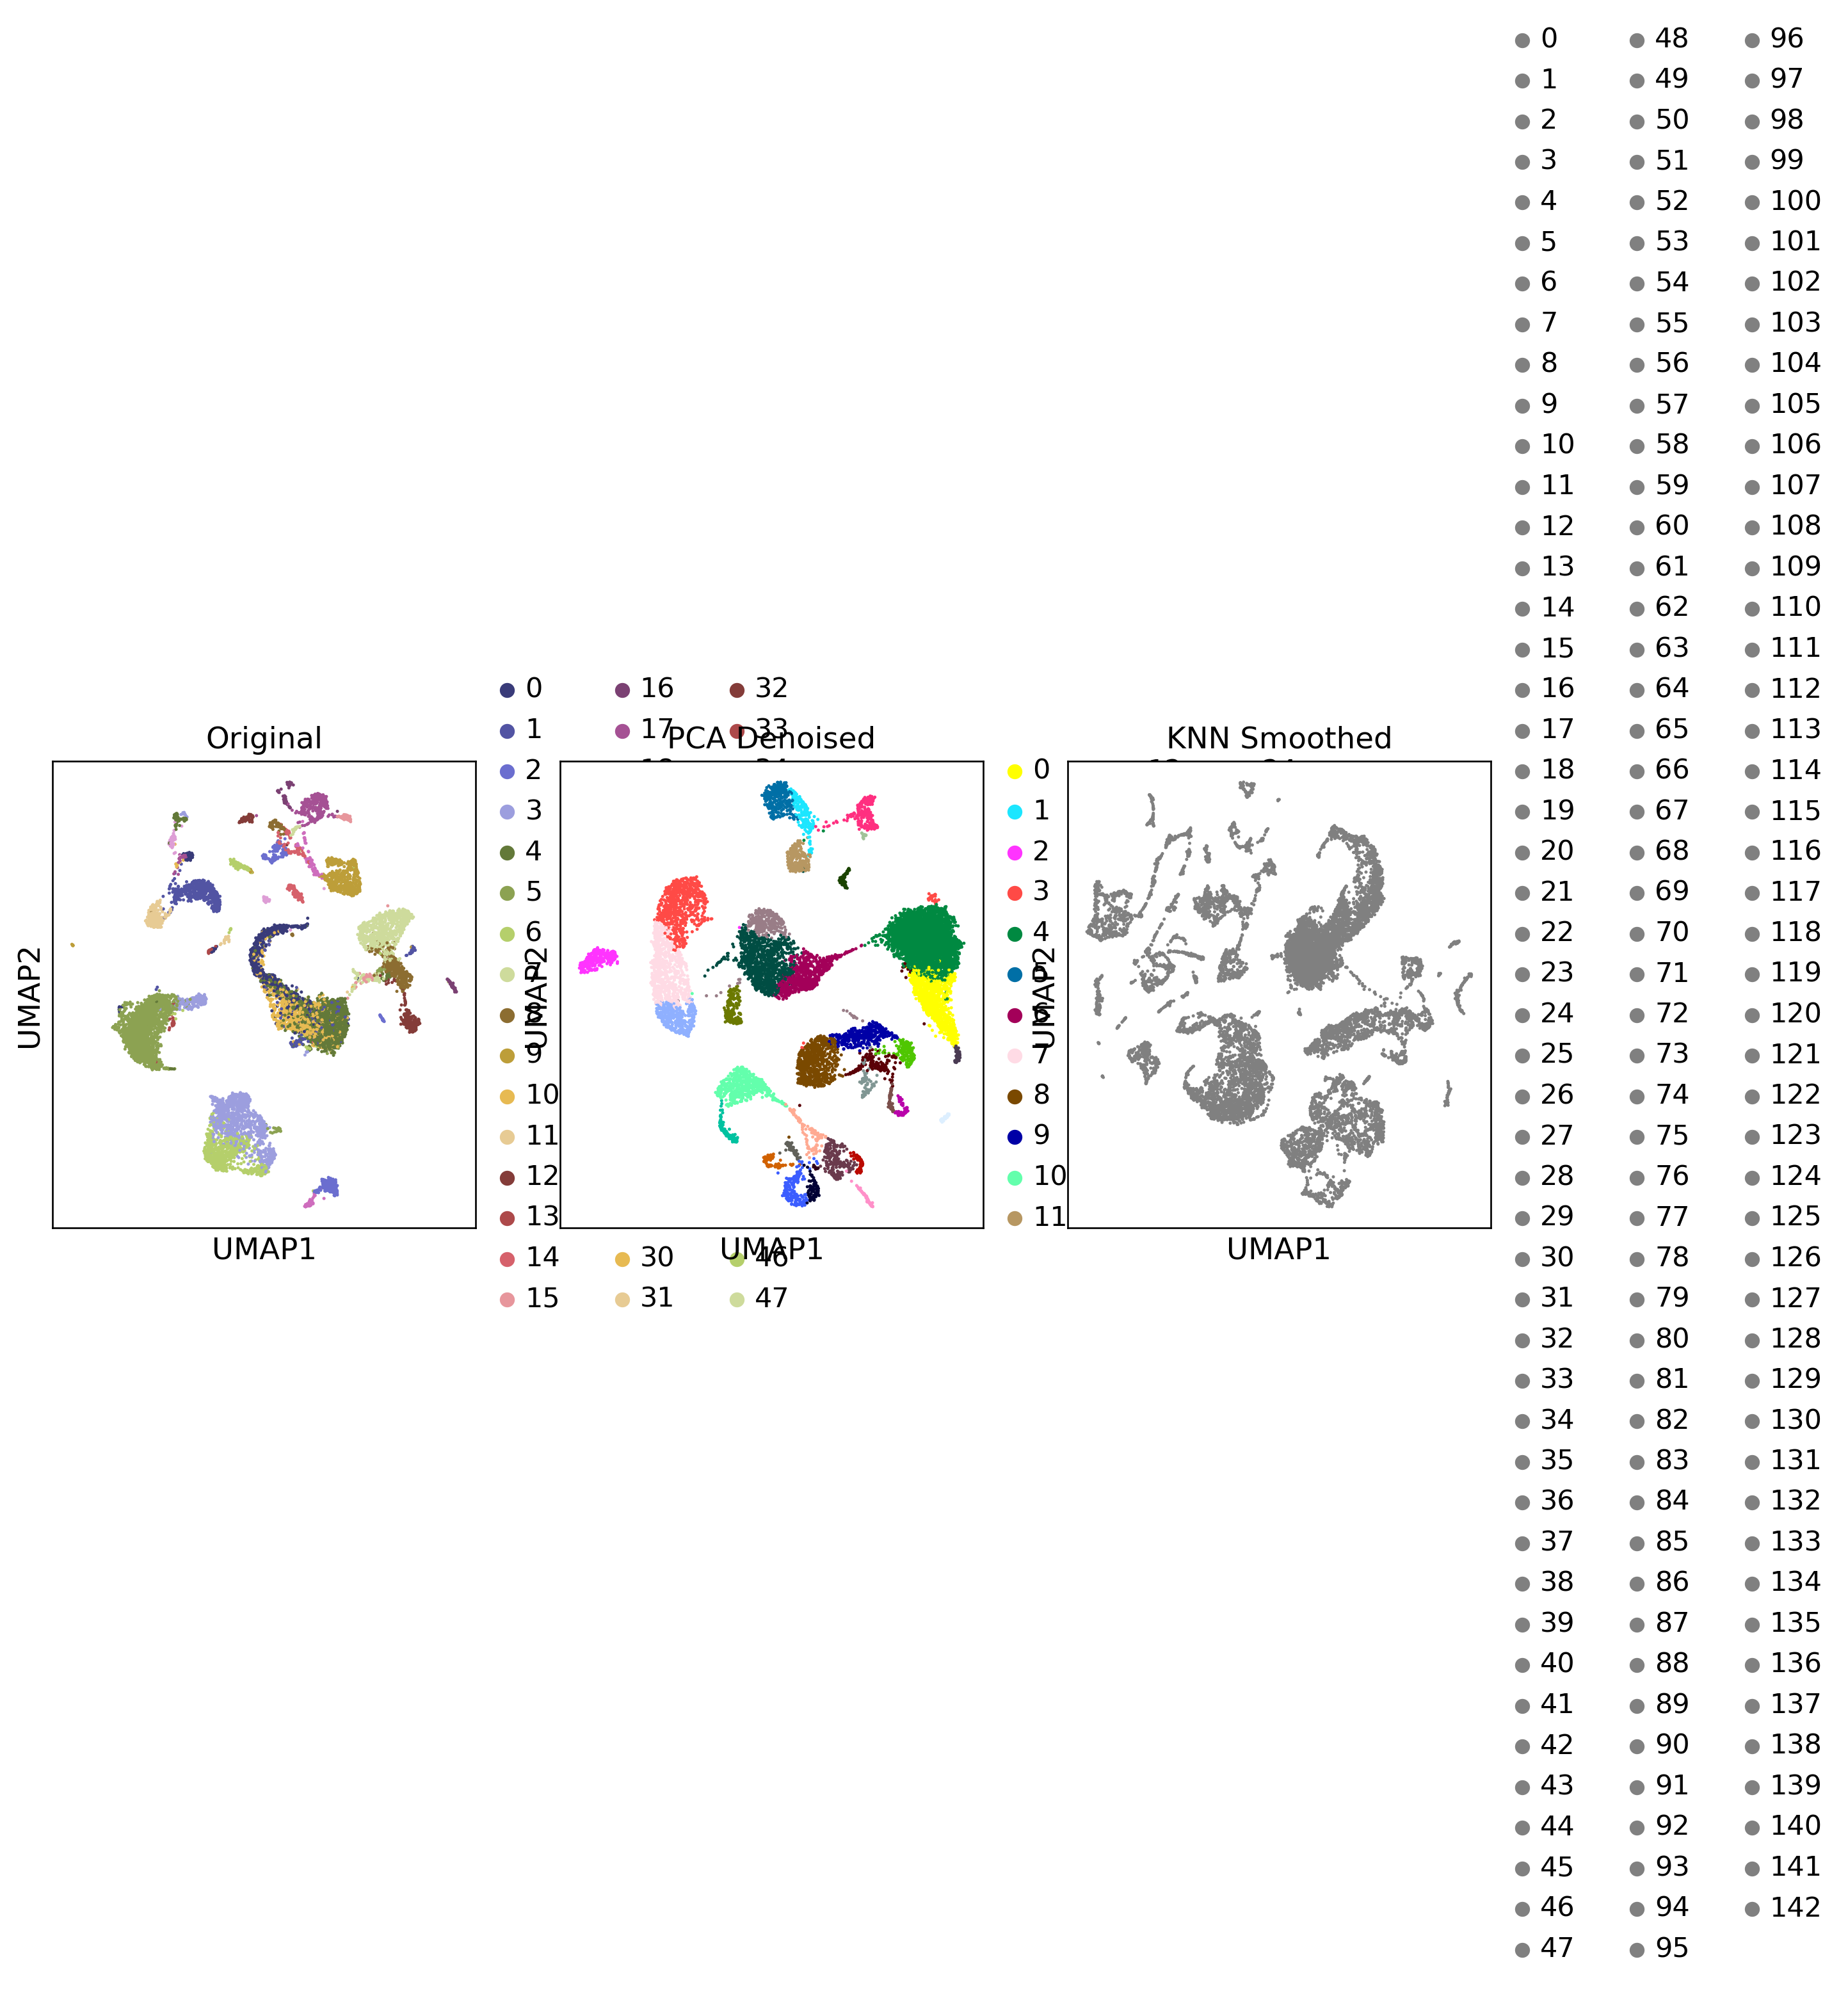

In [31]:
# TODO: keeping this as reference while I work on a better version
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Original
sc.pl.umap(adata, color='walktrap', ax=axes[0], show=False, title='Original')

# PCA denoised
sc.pl.umap(ad_dn1, color='walktrap', ax=axes[1], show=False, title='PCA Denoised')

# KNN denoised
sc.pl.umap(ad_dn2, color='walktrap', ax=axes[2], show=False, title='KNN Smoothed')

plt.tight_layout()
plt.savefig(f"{DIR_DENOISING}/denoising_umap_comparison.png", dpi=200)

In [32]:

#@title Save figure panels
fig, axs = plt.subplots(1,2, figsize=(9,4))
sc.pl.umap(adata, color="walktrap", ax=axs[0], show=False); axs[0].set_title("Walktrap")
sc.pl.umap(adata, color="leiden",  ax=axs[1], show=False); axs[1].set_title("Leiden")
plt.tight_layout(); plt.savefig(f"{OUTPUT_DIR}/figure_cluster_panel.png", dpi=200, bbox_inches="tight"); plt.close()
print("Figures saved to", OUTPUT_DIR)


Figures saved to /content/drive/MyDrive/STAT4243/roc_outputs_final


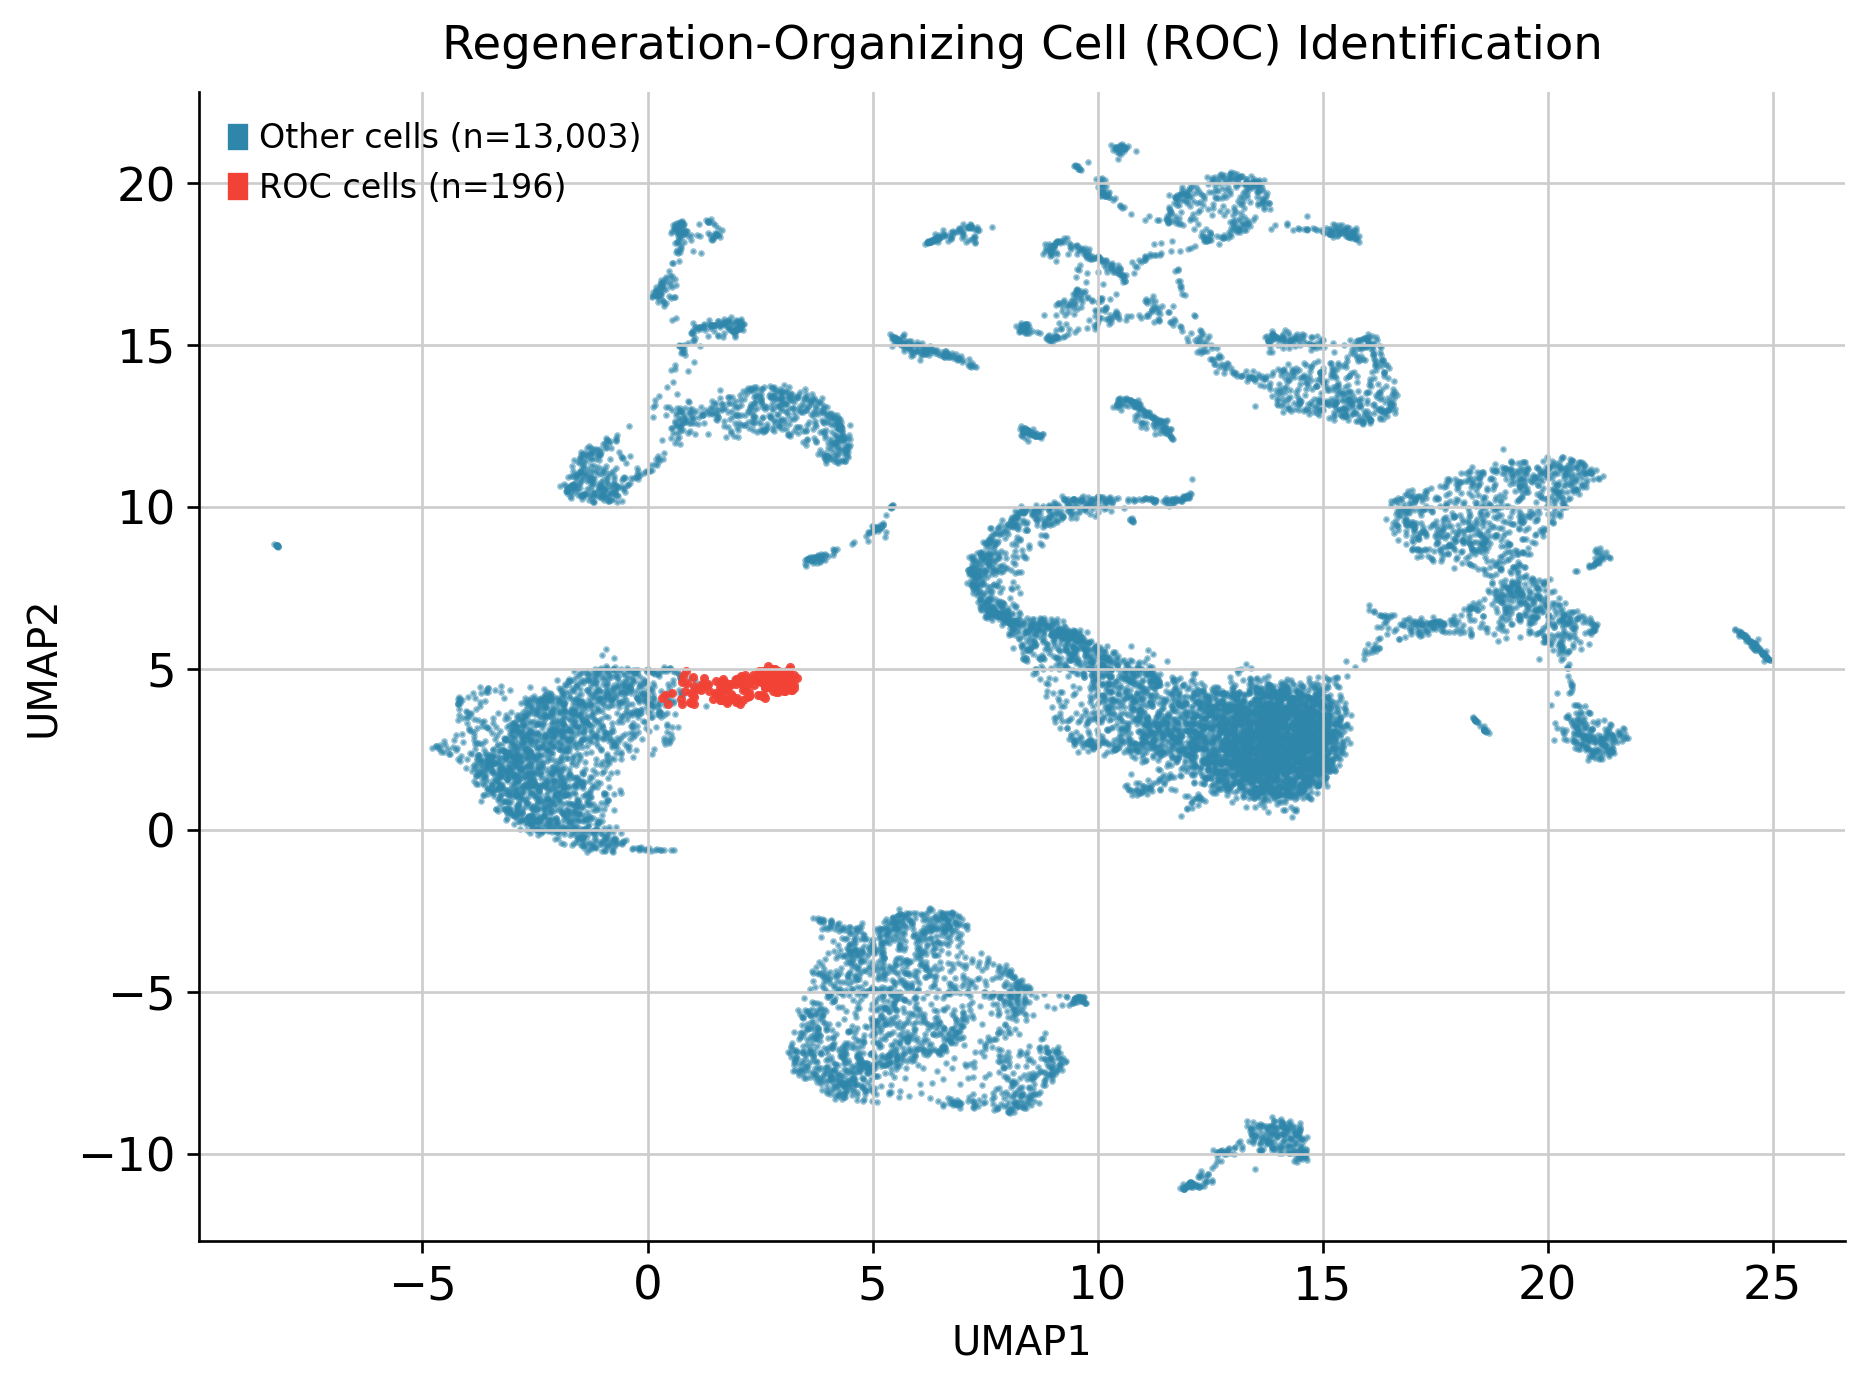

In [33]:
# @title Figure 1: Improved ROC Identification (Fixed Legend)

# Create figure with better layout
fig, ax = plt.subplots(figsize=(8, 6))

# Plot non-ROC cells first
non_roc = adata.obs['ROC_flag'] == 'other'
ax.scatter(
    adata.obsm['X_umap'][non_roc, 0],
    adata.obsm['X_umap'][non_roc, 1],
    c='#2E86AB',
    s=1,
    alpha=0.5,
    rasterized=True
)

# Plot ROC cells on top
roc = adata.obs['ROC_flag'] == 'ROC'
ax.scatter(
    adata.obsm['X_umap'][roc, 0],
    adata.obsm['X_umap'][roc, 1],
    c='#F24236',
    s=3,
    alpha=0.9,
    rasterized=True
)

# Create legend manually
other_patch = mpatches.Patch(
    color='#2E86AB',
    label=f'Other cells (n={non_roc.sum():,})'
)
roc_patch = mpatches.Patch(
    color='#F24236',
    label=f'ROC cells (n={roc.sum():,})'
)
ax.legend(
    handles=[other_patch, roc_patch],
    loc='upper left',
    frameon=False,
    fontsize=10
)

ax.set_xlabel('UMAP1', fontsize=12)
ax.set_ylabel('UMAP2', fontsize=12)
ax.set_title(
    'Regeneration-Organizing Cell (ROC) Identification',
    fontsize=14,
    pad=10
)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(
    f"{DIR_FIGURES}/fig01_roc_identification.png",
    dpi=300,
    bbox_inches='tight'
)
plt.show()

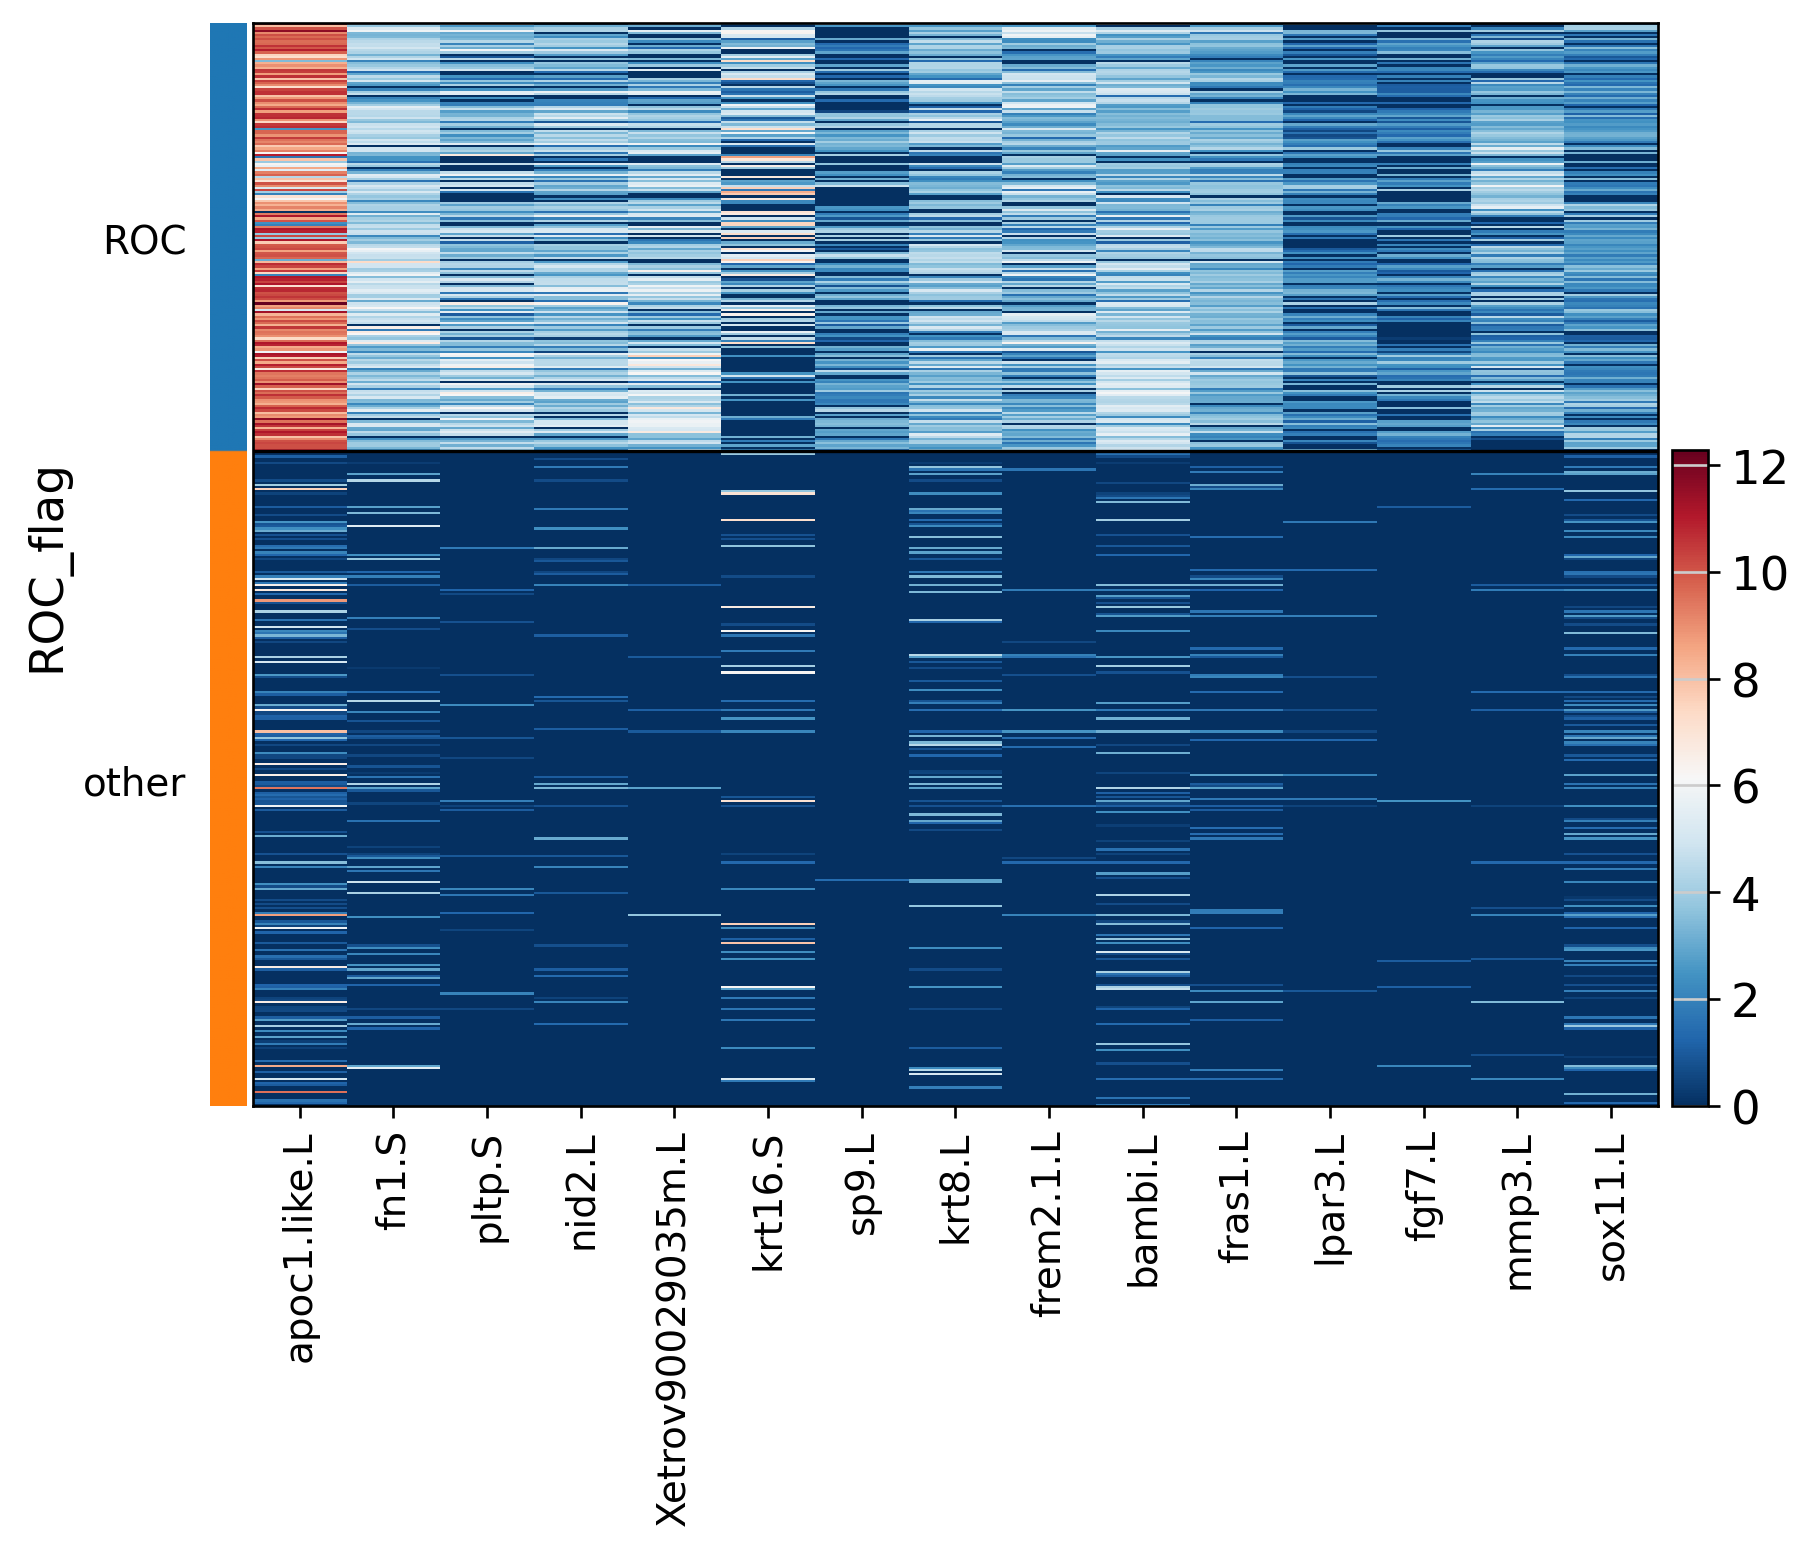

In [34]:
# @title Figure 2: Gene Expression Heatmap
# Select top markers
top_markers = logreg_top.head(20)['names'].tolist()

# Create a subset for visualization
roc_cells = adata[adata.obs['ROC_flag'] == 'ROC'].copy()
other_cells = adata[adata.obs['ROC_flag'] == 'other'].copy()

# Sample for balance (so heatmap isn't overwhelmed)
n_sample = min(300, other_cells.n_obs)
other_sample = other_cells[
    np.random.choice(other_cells.n_obs, n_sample, replace=False)
]

# Combine for heatmap
vis_data = ad.concat([roc_cells, other_sample])

# Generate heatmap
sc.pl.heatmap(
    vis_data,
    var_names=top_markers[:15],  # Top 15 genes
    groupby='ROC_flag',
    cmap='RdBu_r',
    dendrogram=False,
    figsize=(8, 6),
    show_gene_labels=True,
    show=False
)
plt.savefig(
    f'{DIR_VALIDATION}/validation_heatmap_top15genes.png',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

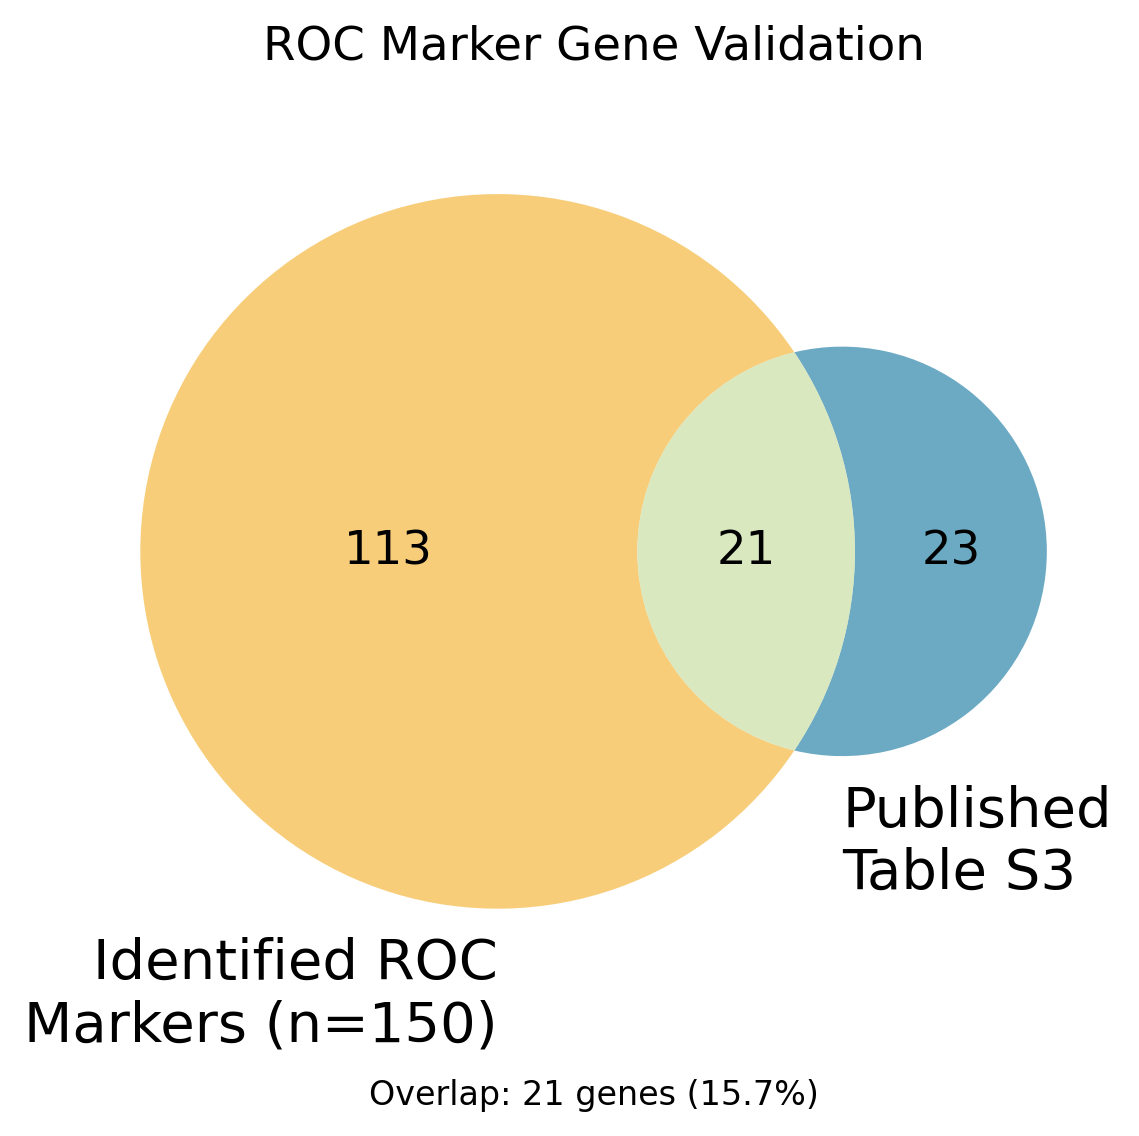

In [35]:
# @title Figure 3: Venn Diagram for Validation

# Get gene sets
our_genes = set(map(canon, logreg_df.head(150)["names"]))
table_s3_genes = roc_s3_canon  # Defined earlier

fig, ax = plt.subplots(figsize=(6, 5))

venn = venn2(
    [our_genes, table_s3_genes],
    ('Identified ROC\nMarkers (n=150)', 'Published\nTable S3'),
    ax=ax,
    set_colors=('#F4B942', '#2E86AB'),
    alpha=0.7
)

# Add overlap statistics
overlap = len(our_genes & table_s3_genes)
ax.text(
    0.5, -0.15,
    f'Overlap: {overlap} genes ({100 * overlap / len(our_genes):.1f}%)',
    transform=ax.transAxes,
    ha='center',
    fontsize=10
)

ax.set_title('ROC Marker Gene Validation', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig(
    f"{DIR_FIGURES}/fig03_validation_venn.png",
    dpi=300,
    bbox_inches='tight'
)
plt.show()

## Output Directory Structure

All analysis outputs are organized into the following subdirectories:

- **`01_clustering/`**: Clustering results and quality metrics
  - UMAP visualizations for Walktrop and Leiden
  - Cluster quality metrics (silhouette, modularity)
  - Confusion matrices comparing clustering methods
  
- **`02_roc_identification/`**: ROC cell identification results
  - UMAP showing ROC vs other cells
  - Gene expression plots for key markers (lef1, tp63)
  
- **`03_markers/`**: Differential expression and marker gene analysis
  - Top marker genes from multiple methods (logistic regression, Wilcoxon)
  - Volcano plots showing effect sizes
  - Overlap analysis with published Table S3
  
- **`04_validation/`**: Validation against published data
  - Venn diagrams showing marker overlap
  - Heatmaps of gene expression
  - Tidy metrics for reporting
  
- **`05_denoising/`**: Denoising method comparison
  - Impact metrics for PCA reconstruction vs k-NN smoothing
  - Comparative UMAP visualizations
  
- **`06_batch_integration/`**: Batch correction analysis
  - Impact metrics for Harmony vs BBKNN
  
- **`07_figures_publication/`**: Publication-ready figures
  - Main figures (Fig 1-4)
  - Supplementary figures (FigS1-S4)
  - Per-category breakdowns
  
- **`08_summary/`**: Summary reports
  - Combined metrics JSON

## MI-CLAIM Checklist & Code Availability

Generate MI-CLAIM checklist scaffold for the Methods section and create a comprehensive summary of all computational metrics.

In [38]:
# @title MI-Checklist scaffold + summary
rows = [
    ("Study design", "clinical problem stated"),
    ("Study design", "research question stated"),
    ("Data/optimization", "data origin described"),
    ("Data/optimization", "transformations described (CP10K, Fano HVGs, log2)"),
    ("Modeling", "UMAP parameters (cosine, k=20, min_dist=0.5)"),
    ("Modeling", "Walktrap on UMAP fuzzy graph (k=10); Leiden on kNN(PCA)"),
    ("Evaluation", "silhouette (method-native), ARI, Rand; modularity (Walktrap)"),
    ("Robustness", "denoising ×2 & batch integration ×2 impact"),
    ("Reproducibility", "Colab + data paths set"),
    ("Code Availability", "https://github.com/<your-org>/<repo> (commit <hash>)"),
]
pd.DataFrame(rows, columns=["Section", "Item"]).to_csv(
    f"{DIR_SUMMARY}/summary_MI_CLAIM_checklist.csv",
    index=False
)


def slurp(p):
    """Load JSON file or return empty dict on error."""
    try:
        return json.load(open(p))
    except Exception:
        return {}


summary = {
    "metrics_baseline": slurp(
        f"{DIR_CLUSTERING}/clustering_metrics_baseline.json"
    ),
    "impact_denoising": slurp(
        f"{DIR_DENOISING}/denoising_impact_metrics.json"
    ),
    "impact_batch_integration": slurp(
        f"{DIR_BATCH}/batch_integration_impact_metrics.json"

    )
}

open(f"{DIR_SUMMARY}/summary_all_metrics.json", "w").write(
    json.dumps(summary, indent=2)
)

print("All outputs organized in:", OUTPUT_DIR)
print("Wrote summary files to:", DIR_SUMMARY)

All outputs organized in: /content/drive/MyDrive/STAT4243/roc_outputs_final
Wrote summary files to: /content/drive/MyDrive/STAT4243/roc_outputs_final/08_summary
